In [1]:
using DifferentialEquations
using Distributions
using HypergeometricFunctions
using HypothesisTests
using Interpolations
using LinearAlgebra
using LsqFit
using NLsolve
using Printf
using PyPlot
using QuadGK
using SpecialFunctions
using Statistics

In [2]:
sr2 = √(2)
sr2π = √(2π)

2.5066282746310002

# Rate Moment Calculator

In [3]:
abstract type RateParams end

In [4]:
struct RicciardiParams <: RateParams
    θ::AbstractFloat
    Vr::AbstractFloat
    σn::AbstractFloat
    τs::AbstractFloat
    τr::AbstractFloat
end

In [5]:
function μtox(μ::AbstractFloat)::AbstractFloat
    sign(μ/100-0.2)*abs(μ/100-0.2)^0.5
end

function xtoμ(x::AbstractFloat)::AbstractFloat
    100(sign(x)*abs(x)^2.0+0.2)
end

xtoμ (generic function with 1 method)

In [133]:
function Φint(rp::RicciardiParams,μ::AbstractFloat)
    umax = (rp.θ-μ)/rp.σn
    umin = (rp.Vr-μ)/rp.σn
    if umin > 10
        return umax*exp(-umax^2)/rp.τs
    elseif umin > -4
        return 1/(rp.τr+rp.τs*(0.5*π*(erfi(umax)-erfi(umin)) +
                umax^2*pFq([1.0,1.0],[1.5,2.0],umax^2) -
                umin^2*pFq([1.0,1.0],[1.5,2.0],umin^2)))
    else
        return 1/(rp.τr+rp.τs*(log(abs(umin))-log(abs(umax)) +
                (0.25umin^-2-0.1875umin^-4+0.3125umin^-6-
                    0.8203125umin^-8+2.953125umin^-10) -
                (0.25umax^-2-0.1875umax^-4+0.3125umax^-6-
                    0.8203125umax^-8+2.953125umax^-10)))
    end
end

function Φitp(rps::Vector{RicciardiParams})
    xs = range(μtox(-1E3), μtox(5E5), length=2*10^5+1)
    Φint(rps[1],-100.0)
    Φint(rps[1],0.0)
    Φint(rps[1],100.0)
    global Φitps = Dict()
    for rp in rps
        Φs = [Φint(rp,xtoμ(x)) for x in xs]
        Φitps[hash(rp)] = CubicSplineInterpolation(xs, Φs, extrapolation_bc = Line())
    end
end

function Φ(rp::RicciardiParams,μ::AbstractFloat)
    return Φitps[hash(rp)](μtox(μ))
end

Φ (generic function with 1 method)

In [72]:
function Mint(rp::RicciardiParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return Φ(rp,μ)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*Φ(rp,μ+σ*x),-8,8,rtol=1e-8)[1]
end

function Mitp(rps::Vector{RicciardiParams})
    xs = range(μtox(-800.0), μtox(1000.0), length=3000+1)
    σs = range(0.0, 60.0, length=600+1)
    Mint(rps[1],0.0,1.0)
    global Mitps = Dict()
    for rp in rps
        Ms = [Mint(rp,xtoμ(x),σ) for x in xs, σ in σs]
        Mitps[hash(rp)] = CubicSplineInterpolation((xs,σs), Ms, extrapolation_bc = Line())
    end
end

function M(rp::RicciardiParams,μ::AbstractFloat,σ::AbstractFloat)
    return Mitps[hash(rp)](μtox(μ),σ)
end

M (generic function with 1 method)

In [55]:
function Cint(rp::RicciardiParams,μ1::AbstractFloat,μ2::AbstractFloat,
            σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return M(rp,μ1,σ1)*M(rp,μ2,σ2)
    end
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        M(rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
end

function Cint(rp::RicciardiParams,μ::AbstractFloat,σ::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return M(rp,μ,σ)^2
    end
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ+sign(c)*σ*√(abs(c))*x,σ*√(1-abs(c)))*
        M(rp,μ+σ*√(abs(c))*x,σ*√(1-abs(c))),-8,8,rtol=1e-8)[1]
end

function Citp(rps::Vector{RicciardiParams})
    xs = range(μtox(-400.0), μtox(200.0), length=300+1)
    σs = range(0.0, 60.0, length=300+1)
    cs = range(-0.1, 1.0, length=66+1)
    Cint(rps[1],0.0,0.0,1.0,1.0,0.0)
    global Citps = Dict()
    for rp in rps
        Cs = [Cint(rp,xtoμ(x),xtoμ(x),σ,σ,σ^2*c) for x in xs, σ in σs, c in cs]
        Citps[hash(rp)] = CubicSplineInterpolation((xs,σs,cs), Cs,
            extrapolation_bc = Line())
    end
end

function C(rp::RicciardiParams,μ::AbstractFloat,σ::AbstractFloat,ρ::AbstractFloat)
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    return Citps[hash(rp)](μtox(μ),σ,c)
end

C (generic function with 1 method)

In [9]:
rpE = RicciardiParams(20.0,10.0,10.0,0.02,0.002)
rpI = RicciardiParams(20.0,10.0,10.0,0.01,0.002)

RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002)

In [136]:
@time Φitp([rpE,rpI])

  0.612585 seconds (16.29 M allocations: 300.013 MiB, 13.49% gc time, 4.45% compilation time)


In [142]:
@time Mitp([rpE,rpI])

399.782426 seconds (10.61 G allocations: 164.225 GiB, 7.53% gc time, 0.02% compilation time)


In [12]:
@time Citp([rpE,rpI])

12098.037087 seconds (435.99 G allocations: 6.943 TiB, 9.50% gc time, 0.02% compilation time)


# Opto-Stimulated Rate Moment

In [14]:
abstract type OptoParams end

In [15]:
struct TruncNormOptoParams <: OptoParams
    f::AbstractFloat                # fraction potentially expressing opsin
    f̄::AbstractFloat                # true fraction unaffected by opsin
    s::AbstractFloat                # normalized std of opsin expression
    λL::AbstractFloat               # mean optogenetic stimulus voltage
end

function TruncNormOptoParams(f::AbstractFloat,s::AbstractFloat,λL::AbstractFloat)
    f̄ = 1-f*0.5*(1+erf(1/(s*sr2)))
    TruncNormOptoParams(f,f̄,s,λL)
end

TruncNormOptoParams

In [16]:
struct LogNormOptoParams <: OptoParams
    s::AbstractFloat                # normalized std of opsin expression
    λL::AbstractFloat               # mean optogenetic stimulus voltage
    μ::AbstractFloat                # mean of log opsin expression
    σ::AbstractFloat                # std of log opsin expression
end

function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
    σ2 = log(1+s^2)
    σ = √(σ2)
    μ = log(λL)-0.5σ2
    LogNormOptoParams(s,λL,μ,σ)
end

LogNormOptoParams

In [17]:
function ΦLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat)
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*Φ(rp,μ+x*op.λL),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*Φ(rp,μ)
    return int
end

function ΦLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat)
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*Φ(rp,μ+x),
        0,20op.λL,rtol=1e-8)[1]
end

function ΦLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-1E3), μtox(1E5), length=10^5+1)
    ΦLint(op,rps[1],0.0)
    global ΦLitps = Dict()
    for rp in rps
        ΦLs = [ΦLint(op,rp,xtoμ(x)) for x in xs]
        ΦLitps[hash(rp)] = CubicSplineInterpolation(xs, ΦLs, extrapolation_bc = Line())
    end
end

function ΦL(op::OptoParams,rp::RateParams,μ::AbstractFloat)
    return ΦLitps[hash(rp)](μtox(μ))
end

ΦL (generic function with 1 method)

In [18]:
function MLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*M(rp,μ+x*op.λL,σ),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*M(rp,μ,σ)
    return int
end

function MLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*M(rp,μ+x,σ),
        0,20op.λL,rtol=1e-8)[1]
end

function MLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-800.0), μtox(500.0), length=1900+1)
    σs = range(0.0, 60.0, length=800+1)
    MLint(op,rps[1],0.0,1.0)
    global MLitps = Dict()
    for rp in rps
        MLs = [MLint(op,rp,xtoμ(x),σ) for x in xs, σ in σs]
        MLitps[hash(rp)] = CubicSplineInterpolation((xs,σs), MLs,
            extrapolation_bc = Line())
    end
end

function ML(op::OptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    return MLitps[hash(rp)](μtox(μ),σ)
end

ML (generic function with 1 method)

In [19]:
function CLint(op::TruncNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*
                Cint(rp,μ1+x*op.λL,μ2+x*op.λL,σ1,σ2,ρ),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*Cint(rp,μ1,μ2,σ1,σ2,ρ)
    return int
end

function CLint(op::LogNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
                Cint(rp,μ1+x,μ2+x,σ1,σ2,ρ),0,20op.λL,rtol=1e-8)[1]
end

function CLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if ρ ≈ 0.0
        int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*M(rp,μ+x*op.λL,σ)^2,
                    0,10op.s,rtol=1e-8)[1]
    else
        int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*C(rp,μ+x*op.λL,σ,ρ),
                    0,10op.s,rtol=1e-8)[1]
    end
    int += op.f̄*C(rp,μ,σ,ρ)
    return int
end

function CLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if ρ ≈ 0.0
        return quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*M(rp,μ+x,σ)^2,
                    0,20op.λL,rtol=1e-8)[1]
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
                C(rp,μ+x,σ,ρ),0,20op.λL,rtol=1e-8)[1]
end

function CLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-400.0), μtox(100.0), length=250+1)
    σs = range(0.0, 60.0, length=300+1)
    cs = range(-0.1, 1.0, length=66+1)
    CLint(op,rps[1],0.0,1.0,0.0)
    global CLitps = Dict()
    for rp in rps
        CLs = [CLint(op,rp,xtoμ(x),σ,σ^2*c) for x in xs, σ in σs, c in cs]
        CLitps[hash(rp)] = CubicSplineInterpolation((xs,σs,cs), CLs,
            extrapolation_bc = Line())
    end
end

function CL(op::OptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    int = CLitps[hash(rp)](μtox(μ),σ,c)
    if isnan(int)
        println((μ,σ,ρ))
    end
    return int
#     return CLitps[hash(rp)](μtox(μ),σ,c)
#     return CLint(op,rp,μ,σ,ρ)
end

CL (generic function with 1 method)

In [20]:
function RLint(op::TruncNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    int = quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        ML(op,rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
    return int
end

function RLint(op::LogNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    int = quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        ML(op,rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
    return int
end

function RL(op::OptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    return RLint(op,rp,μ1,μ2,σ1,σ2,ρ)
end

RL (generic function with 1 method)

In [21]:
# op = TruncNormOptoParams(1.0,10.0^0.58,10.0^1.02)
op = LogNormOptoParams(10.0^0.58,10.0^1.02)

LogNormOptoParams(3.8018939632056115, 10.471285480508996, 0.9796899928036182, 1.6546581532451399)

In [22]:
@time ΦLitp(op,[rpE,rpI])

 43.935767 seconds (1.46 G allocations: 22.517 GiB, 7.60% gc time, 4.46% compilation time)


In [23]:
@time MLitp(op,[rpE,rpI])

761.360211 seconds (25.79 G allocations: 393.154 GiB, 7.62% gc time, 0.14% compilation time)


In [24]:
@time CLitp(op,[rpE,rpI])

2798.639563 seconds (88.75 G allocations: 1.319 TiB, 7.58% gc time, 0.11% compilation time)


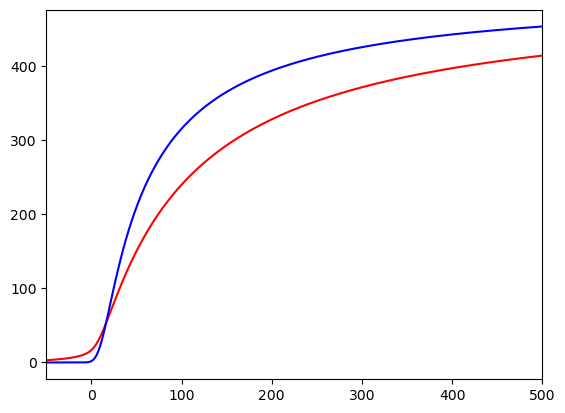

  0.371570 seconds (82.45 k allocations: 4.400 MiB, 76.57% compilation time)
  0.061108 seconds (55.41 k allocations: 2.857 MiB, 96.02% compilation time)


(-50.0, 500.0)

In [25]:
let μs = range(-50,500,length=1000)
    @time plot(μs,[ΦL(op,rpE,μs[i]) for i in eachindex(μs)],"r")
    @time plot(μs,[Φ(rpI,μs[i]) for i in eachindex(μs)],"b")
    xlim(-50,500)
end

# Network Parameters Struct

In [26]:
struct NetworkParams
    K::Int                          # mean number of E->E connections
    p::AbstractFloat                # connection probability
    γ::AbstractFloat                # ratio of I vs E cells
    sX::AbstractFloat               # std/mean of external firing rates
    rpE::RateParams                 # rate params for excitatory cells
    rpI::RateParams                 # rate params for inhibitory cells
    W::Matrix{AbstractFloat}        # O(1) recurrent coupling matrix (EIX -> EI)
end

function NetworkParams(K::Int,p::AbstractFloat,γ::AbstractFloat,gE::AbstractFloat,
        gI::AbstractFloat,β::AbstractFloat,ΓE::AbstractFloat,ΓI::AbstractFloat,
        sX::AbstractFloat,rpE::RateParams,rpI::RateParams)
    W = [1.0 -gE (ΓI*γ*gE-ΓE);
        1/β -gI/β (ΓI*γ*gI-ΓE)/β]
    NetworkParams(K,p,γ,sX,rpE,rpI,W)
end

NetworkParams

In [313]:
np = NetworkParams(500,0.1,0.25,7.49,2.39,10.0^-0.51,1.0,2.0,0.2,rpE,rpI)

NetworkParams(500, 0.1, 0.25, 0.2, RicciardiParams(20.0, 10.0, 10.0, 0.02, 0.002), RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002), AbstractFloat[1.0 -7.49 2.745; 3.2359365692962827 -7.733888400618116 0.6310076310127752])

# DMFT Solver for Normal Network

In [296]:
function dmft(np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,Twrm::AbstractFloat,
        Tsave::AbstractFloat,dt::AbstractFloat;DE::Function=t->0.0,DI::Function=t->0.0,
        μEinit::AbstractFloat=1E-8,μIinit::AbstractFloat=1E-8,
        σE2init::Vector{Float64}=[1E2],σI2init::Vector{Float64}=[1E2])
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    μE = Array{Float64}(undef,Nint)
    μI = Array{Float64}(undef,Nint)
    σE2 = Array{Float64}(undef,(Nint,Nint))
    σI2 = Array{Float64}(undef,(Nint,Nint))

    μE[1] = μEinit
    μI[1] = μIinit
    Nσ2init = length(σE2init)
    if Nclc >= Nσ2init
        σE2[1,1:Nσ2init] .= σE2init
        σE2[1,Nσ2init+1:Nclc] .= σE2init[end]
        σE2[1:Nσ2init,1] .= σE2init
        σE2[Nσ2init+1:Nclc,1] .= σE2init[end]
    else
        σE2[1,1:Nclc] .= σE2init[1:Nclc]
        σE2[1:Nclc,1] .= σE2init[1:Nclc]
    end
    Nσ2init = length(σI2init)
    if Nclc >= Nσ2init
        σI2[1,1:Nσ2init] .= σI2init
        σI2[1,Nσ2init+1:Nclc] .= σI2init[end]
        σI2[1:Nσ2init,1] .= σI2init
        σI2[Nσ2init+1:Nclc,1] .= σI2init[end]
    else
        σI2[1,1:Nclc] .= σI2init[1:Nclc]
        σI2[1:Nclc,1] .= σI2init[1:Nclc]
    end
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    J2K = J^2*np.K
    W2 = np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2

    for i in 1:Nint-1
        rE = M(np.rpE,μE[i],√(max(σE2[i,i],0)))
        rI = M(np.rpI,μI[i],√(max(σI2[i,i],0)))
        kE1 = -τEinv*μE[i]+JK*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
        kI1 = -τIinv*μI[i]+JK*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
        rEk = M(np.rpE,μE[i]+0.5dt*kE1,√(max(σE2[i,i],0)))
        rIk = M(np.rpI,μI[i]+0.5dt*kI1,√(max(σI2[i,i],0)))
        kE2 = -τEinv*(μE[i]+0.5dt*kE1)+JK*(np.W[1,3]*rX+np.W[1,1]*rEk+np.γ*np.W[1,2]*rIk)
        kI2 = -τIinv*(μI[i]+0.5dt*kI1)+JK*(np.W[2,3]*rX+np.W[2,1]*rEk+np.γ*np.W[2,2]*rIk)
        rEk = M(np.rpE,μE[i]+0.5dt*kE2,√(max(σE2[i,i],0)))
        rIk = M(np.rpI,μI[i]+0.5dt*kI2,√(max(σI2[i,i],0)))
        kE3 = -τEinv*(μE[i]+0.5dt*kE2)+JK*(np.W[1,3]*rX+np.W[1,1]*rEk+np.γ*np.W[1,2]*rIk)
        kI3 = -τIinv*(μI[i]+0.5dt*kI2)+JK*(np.W[2,3]*rX+np.W[2,1]*rEk+np.γ*np.W[2,2]*rIk)
        rEk = M(np.rpE,μE[i]+dt*kE3,√(max(σE2[i,i],0)))
        rIk = M(np.rpI,μI[i]+dt*kI3,√(max(σI2[i,i],0)))
        kE4 = -τEinv*(μE[i]+dt*kE3)+JK*(np.W[1,3]*rX+np.W[1,1]*rEk+np.γ*np.W[1,2]*rIk)
        kI4 = -τIinv*(μI[i]+dt*kI3)+JK*(np.W[2,3]*rX+np.W[2,1]*rEk+np.γ*np.W[2,2]*rIk)
        μE[i+1] = μE[i] + dt/6*(kE1+2kE2+2kE3+kE4)
        μI[i+1] = μI[i] + dt/6*(kI1+2kI2+2kI3+kI4)
        if abs(μE[i+1]) > 1E10 || isnan(μE[i+1])
            @printf "σE2[%d,%d] = %f\n" i i σE2[i,i]
            @printf "σI2[%d,%d] = %f\n" i i σI2[i,i]
            @printf "rE = %f\n" rE
            @printf "rI = %f\n" rI
            @printf "μE[%d+1] = %f\n" i μE[i+1]
            @printf "μI[%d+1] = %f\n" i μI[i+1]
            println("system diverged")
            return (μE,μI,σE2,σI2)
        end
        if i > Nclc
            σE2[i+1,i-Nclc] = σE2[i,i-Nclc]
            σI2[i+1,i-Nclc] = σI2[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            CEE = C(np.rpE,μE[i],√(max(σE2[i,i],0)),σE2[i,j])
            CII = C(np.rpI,μI[i],√(max(σI2[i,i],0)),σI2[i,j])
            rE2 = rE^2
            rI2 = rI^2
            σrE2 = CEE - rE2
            σrI2 = CII - rI2
            σE2[i+1,j+1] = σE2[i,j+1]+σE2[i+1,j]-σE2[i,j] -
                            dtτEinv*(σE2[i+1,j]+σE2[i,j+1]-2σE2[i,j]) - dtτEinv2*σE2[i,j] +
                            dt2*J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) +
                            W2[1,3]*σrX2+W2[1,1]*σrE2+np.γ*W2[1,2]*σrI2) +
                            dtτEinv2*DE((j-i)*dt)
            σI2[i+1,j+1] = σI2[i,j+1]+σI2[i+1,j]-σI2[i,j] -
                            dtτIinv*(σI2[i+1,j]+σI2[i,j+1]-2σI2[i,j]) - dtτIinv2*σI2[i,j] +
                            dt2*J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) +
                            W2[2,3]*σrX2+W2[2,1]*σrE2+np.γ*W2[2,2]*σrI2) +
                            dtτIinv2*DI((j-i)*dt)
            if σE2[i+1,j+1] > 1E10 || isnan(σE2[i+1,j+1])
                @printf "μE[%d] = %f\n" i μE[i]
                @printf "μI[%d] = %f\n" i μI[i]
                @printf "σE2[%d,%d] = %f\n" i j σE2[i,j]
                @printf "σI2[%d,%d] = %f\n" i j σI2[i,j]
                @printf "σE2[%d+1,%d] = %f\n" i j σE2[i+1,j]
                @printf "σI2[%d+1,%d] = %f\n" i j σI2[i+1,j]
                @printf "σE2[%d,%d+1] = %f\n" i j σE2[i,j+1]
                @printf "σI2[%d,%d+1] = %f\n" i j σI2[i,j+1]
                @printf "CEE = %f\n" CEE
                @printf "CII = %f\n" CII
                @printf "σE2[%d+1,%d+1] = %f\n" i j σE2[i+1,j+1]
                @printf "σI2[%d+1,%d+1] = %f\n" i j σI2[i+1,j+1]
                println("system diverged")
                return (μE,μI,σE2,σI2)
            end
            σE2[j+1,i+1] = σE2[i+1,j+1]
            σI2[j+1,i+1] = σI2[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
#     return (μ[end],σ2[end,end:-1:end-Nsave+1])
    return (μE[end-Nsave+1:end],μI[end-Nsave+1:end],
        σE2[end-Nsave+1:end,end-Nsave+1:end],σI2[end-Nsave+1:end,end-Nsave+1:end])
end

dmft (generic function with 1 method)

# DMFT Solver for Opto-Stimulated Network

In [445]:
function optodmft(op::OptoParams,np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,
        Twrm::AbstractFloat,Tsave::AbstractFloat,dt::AbstractFloat,μE::AbstractFloat,
        μI::AbstractFloat,σE2::Vector{Float64},σI2::Vector{Float64};
        ΔμEinit::AbstractFloat=μE,ΔμIinit::AbstractFloat=μI,
        σΔE2init::Vector{Float64}=σE2,σΔI2init::Vector{Float64}=σI2,
        ρEinit::Vector{Float64}=-σE2/2,ρIinit::Vector{Float64}=-σI2/2)
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    
    Nσ2 = length(σE2)
    σE20 = σE2[1]
    σI20 = σI2[1]
    
    ΔμE = Array{Float64}(undef,Nint)
    ΔμI = Array{Float64}(undef,Nint)
    σΔE2 = Array{Float64}(undef,(Nint,Nint))
    σΔI2 = Array{Float64}(undef,(Nint,Nint))
    ρE = Array{Float64}(undef,(Nint,Nint))
    ρI = Array{Float64}(undef,(Nint,Nint))

    ΔμE[1] = ΔμEinit
    ΔμI[1] = ΔμIinit
    Nσ2init = length(σΔE2init)
    if Nclc >= Nσ2init
        σΔE2[1,1:Nσ2init] .= σΔE2init
        σΔE2[1,Nσ2init+1:Nclc] .= σΔE2init[end]
        σΔE2[1:Nσ2init,1] .= σΔE2init
        σΔE2[Nσ2init+1:Nclc,1] .= σΔE2init[end]
    else
        σΔE2[1,1:Nclc] .= σΔE2init[1:Nclc]
        σΔE2[1:Nclc,1] .= σΔE2init[1:Nclc]
    end
    Nσ2init = length(σΔI2init)
    if Nclc >= Nσ2init
        σΔI2[1,1:Nσ2init] .= σΔI2init
        σΔI2[1,Nσ2init+1:Nclc] .= σΔI2init[end]
        σΔI2[1:Nσ2init,1] .= σΔI2init
        σΔI2[Nσ2init+1:Nclc,1] .= σΔI2init[end]
    else
        σΔI2[1,1:Nclc] .= σΔI2init[1:Nclc]
        σΔI2[1:Nclc,1] .= σΔI2init[1:Nclc]
    end
    Nρinit = length(ρEinit)
    if Nclc >= Nρinit
        ρE[1,1:Nρinit] .= ρEinit
        ρE[1,Nρinit+1:Nclc] .= ρEinit[end]
        ρE[1:Nρinit,1] .= ρEinit
        ρE[Nρinit+1:Nclc,1] .= ρEinit[end]
    else
        ρE[1,1:Nclc] .= ρEinit[1:Nclc]
        ρE[1:Nclc,1] .= ρEinit[1:Nclc]
    end
    Nρinit = length(ρIinit)
    if Nclc >= Nρinit
        ρI[1,1:Nρinit] .= ρIinit
        ρI[1,Nρinit+1:Nclc] .= ρIinit[end]
        ρI[1:Nρinit,1] .= ρIinit
        ρI[Nρinit+1:Nclc,1] .= ρIinit[end]
    else
        ρI[1,1:Nclc] .= ρIinit[1:Nclc]
        ρI[1:Nclc,1] .= ρIinit[1:Nclc]
    end
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    J2K = J^2*np.K
    W2 = np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2
    rE = M(np.rpE,μE,√(σE20))
    rI = M(np.rpI,μI,√(σI20))

    for i in 1:Nint-1
        σμpΔE0 = max(σE20+σΔE2[i,i]+2ρE[i,i],0)
        σμpΔI0 = max(σI20+σΔI2[i,i]+2ρI[i,i],0)
        rEL = ML(op,np.rpE,μE+ΔμE[i],√(σμpΔE0))
        rIL = M(np.rpI,μI+ΔμI[i],√(σμpΔI0))
        ΔrE = rEL - rE
        ΔrI = rIL - rI
        kE1 = -τEinv*ΔμE[i]+JK*(np.W[1,1]*ΔrE+np.γ*np.W[1,2]*ΔrI)
        kI1 = -τIinv*ΔμI[i]+JK*(np.W[2,1]*ΔrE+np.γ*np.W[2,2]*ΔrI)
        ΔrEk = ML(op,np.rpE,μE+ΔμE[i]+0.5dt*kE1,√(σμpΔE0))-rE
        ΔrIk = M(np.rpI,μI+ΔμI[i]+0.5dt*kI1,√(σμpΔI0))-rI
        kE2 = -τEinv*(ΔμE[i]+0.5dt*kE1)+JK*(np.W[1,1]*ΔrEk+np.γ*np.W[1,2]*ΔrIk)
        kI2 = -τIinv*(ΔμI[i]+0.5dt*kI1)+JK*(np.W[2,1]*ΔrEk+np.γ*np.W[2,2]*ΔrIk)
        ΔrEk = ML(op,np.rpE,μE+ΔμE[i]+0.5dt*kE2,√(σμpΔE0))-rE
        ΔrIk = M(np.rpI,μI+ΔμI[i]+0.5dt*kI2,√(σμpΔI0))-rI
        kE3 = -τEinv*(ΔμE[i]+0.5dt*kE2)+JK*(np.W[1,1]*ΔrEk+np.γ*np.W[1,2]*ΔrIk)
        kI3 = -τIinv*(ΔμI[i]+0.5dt*kI2)+JK*(np.W[2,1]*ΔrEk+np.γ*np.W[2,2]*ΔrIk)
        ΔrEk = ML(op,np.rpE,μE+ΔμE[i]+dt*kE3,√(σμpΔE0))-rE
        ΔrIk = M(np.rpI,μI+ΔμI[i]+dt*kI3,√(σμpΔI0))-rI
        kE4 = -τEinv*(ΔμE[i]+dt*kE3)+JK*(np.W[1,1]*ΔrEk+np.γ*np.W[1,2]*ΔrIk)
        kI4 = -τIinv*(ΔμI[i]+dt*kI3)+JK*(np.W[2,1]*ΔrEk+np.γ*np.W[2,2]*ΔrIk)
        ΔμE[i+1] = ΔμE[i] + dt/6*(kE1+2kE2+2kE3+kE4)
        ΔμI[i+1] = ΔμI[i] + dt/6*(kI1+2kI2+2kI3+kI4)
        if abs(ΔμE[i+1]) > 1E10 || isnan(ΔμE[i+1])
            @printf "σΔE2[%d,%d] = %f\n" i i σΔE2[i,i]
            @printf "σΔI2[%d,%d] = %f\n" i i σΔI2[i,i]
            @printf "ΔrE = %f\n" ΔrE
            @printf "ΔrI = %f\n" ΔrI
            @printf "ΔμE[%d+1] = %f\n" i ΔμE[i+1]
            @printf "ΔμI[%d+1] = %f\n" i ΔμI[i+1]
            println("system diverged")
            return (ΔμE,ΔμI,σΔE2,σΔI2)
        end
        if i > Nclc
            σΔE2[i+1,i-Nclc] = σΔE2[i,i-Nclc]
            σΔI2[i+1,i-Nclc] = σΔI2[i,i-Nclc]
            ρE[i+1,i-Nclc] = ρE[i,i-Nclc]
            ρI[i+1,i-Nclc] = ρI[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            σE2ij = abs(j-i) < Nσ2 ? σE2[abs(j-i)+1] : σE2[end]
            σI2ij = abs(j-i) < Nσ2 ? σI2[abs(j-i)+1] : σI2[end]
            σμpΔEij = σE2ij+σΔE2[i,j]+2ρE[i,j]
            σμpΔIij = σI2ij+σΔI2[i,j]+2ρI[i,j]
            CEE = C(np.rpE,μE,√(σE20),σE2ij)
            CII = C(np.rpI,μI,√(σI20),σI2ij)
            CELEL = CL(op,np.rpE,μE+ΔμE[i],√(σμpΔE0),σμpΔEij)
            CILIL = C(np.rpI,μI+ΔμI[i],√(σμpΔI0),σμpΔIij)
            REEL = RL(op,np.rpE,μE,μE+ΔμE[i],√(σE20),√(σμpΔE0),σE2ij+ρE[i,j])
            RIIL = Cint(np.rpI,μI,μI+ΔμI[i],√(σI20),√(σμpΔI0),σI2ij+ρI[i,j])
            CΔEΔE = CELEL - 2REEL + CEE
            CΔIΔI = CILIL - 2RIIL + CII
            REΔE = REEL - CEE
            RIΔI = RIIL - CII
            ΔrE2 = ΔrE^2
            ΔrI2 = ΔrI^2
            rEΔrE = rE*ΔrE
            rIΔrI = rI*ΔrI
            σΔrE2 = CΔEΔE - ΔrE2
            σΔrI2 = CΔIΔI - ΔrI2
            ρrEΔrE = REΔE - rEΔrE
            ρrIΔrI = RIΔI - rIΔrI
            σΔE2[i+1,j+1] = σΔE2[i,j+1]+σΔE2[i+1,j]-σΔE2[i,j] -
                            dtτEinv*(σΔE2[i+1,j]+σΔE2[i,j+1]-2σΔE2[i,j]) -
                            dtτEinv2*σΔE2[i,j] +
                            dt2*J2K*(q*(W2[1,1]*ΔrE2+np.γ*W2[1,2]*ΔrI2) +
                            W2[1,1]*σΔrE2+np.γ*W2[1,2]*σΔrI2)
            σΔI2[i+1,j+1] = σΔI2[i,j+1]+σΔI2[i+1,j]-σΔI2[i,j] -
                            dtτIinv*(σΔI2[i+1,j]+σΔI2[i,j+1]-2σΔI2[i,j]) -
                            dtτIinv2*σΔI2[i,j] +
                            dt2*J2K*(q*(W2[2,1]*ΔrE2+np.γ*W2[2,2]*ΔrI2) +
                            W2[2,1]*σΔrE2+np.γ*W2[2,2]*σΔrI2)
            if σΔE2[i+1,j+1] > 1E10 || isnan(σΔE2[i+1,j+1])
                @printf "ΔμE[%d] = %f\n" i ΔμE[i]
                @printf "ΔμI[%d] = %f\n" i ΔμI[i]
                @printf "σΔE2[%d,%d] = %f\n" i i σΔE2[i,i]
                @printf "σΔI2[%d,%d] = %f\n" i i σΔI2[i,i]
                @printf "CΔEΔE = %f\n" CΔEΔE
                @printf "CΔIΔI = %f\n" CΔIΔI
                @printf "σΔE2[%d+1,%d+1] = %f\n" i j σΔE2[i+1,j+1]
                @printf "σΔI2[%d+1,%d+1] = %f\n" i j σΔI2[i+1,j+1]
                println("system diverged")
                return (ΔμE,ΔμI,σΔE2,σΔI2)
            end
            σΔE2[j+1,i+1] = σΔE2[i+1,j+1]
            σΔI2[j+1,i+1] = σΔI2[i+1,j+1]
            ρE[i+1,j+1] = ρE[i,j+1]+ρE[i+1,j]-ρE[i,j] -
                            dtτEinv*(ρE[i+1,j]+ρE[i,j+1]-2ρE[i,j]) - dtτEinv2*ρE[i,j] +
                            dt2*J2K*(q*(W2[1,1]*rEΔrE+np.γ*W2[1,2]*rIΔrI) +
                            W2[1,1]*ρrEΔrE+np.γ*W2[1,2]*ρrIΔrI)
            ρI[i+1,j+1] = ρI[i,j+1]+ρI[i+1,j]-ρI[i,j] -
                            dtτIinv*(ρI[i+1,j]+ρI[i,j+1]-2ρI[i,j]) - dtτIinv2*ρI[i,j] +
                            dt2*J2K*(q*(W2[2,1]*rEΔrE+np.γ*W2[2,2]*rIΔrI) +
                            W2[2,1]*ρrEΔrE+np.γ*W2[2,2]*ρrIΔrI)
            ρE[j+1,i+1] = ρE[i+1,j+1]
            ρI[j+1,i+1] = ρI[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
#     return (μ[end],σ2[end,end:-1:end-Nsave+1])
    return (ΔμE[end-Nsave+1:end],ΔμI[end-Nsave+1:end],
        σΔE2[end-Nsave+1:end,end-Nsave+1:end],σΔI2[end-Nsave+1:end,end-Nsave+1:end],
        ρE[end-Nsave+1:end,end-Nsave+1:end],ρI[end-Nsave+1:end,end-Nsave+1:end])
end

optodmft (generic function with 1 method)

# Compare with Simulation

In [327]:
Js = 10.0.^[-1.0:0.1:-0.4;]
μEs = zero(Js)
μIs = zero(Js)
ΔμEs = zero(Js)
ΔμIs = zero(Js)
σμE2s = zero(Js)
σμI2s = zero(Js)
σΔμE2s = zero(Js)
σΔμI2s = zero(Js)
ρμEΔμEs = zero(Js)
ρμIΔμIs = zero(Js)
rEs = zero(Js)
rIs = zero(Js)
ΔrEs = zero(Js)
ΔrIs = zero(Js)
σrE2s = zero(Js)
σrI2s = zero(Js)
σΔrE2s = zero(Js)
σΔrI2s = zero(Js)
ρrEΔrEs = zero(Js)
ρrIΔrIs = zero(Js)

7-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [387]:
for i in eachindex(Js)
    TWrm = 1.0
    TSave = 0.4
    dt = 0.0025
    
    @time μE,μI,σμE2,σμI2 = dmft(np,Js[i],10^1.14,TWrm,TSave,dt)
    @time ΔμE,ΔμI,σΔμE2,σΔμI2,ρμEΔμE,ρμIΔμI = optodmft(op,np,Js[i],10^1.14,TWrm,TSave,dt,
        μE[end],μI[end],σμE2[end,end:-1:1],σμI2[end,end:-1:1])
    
    function extend(a,T,dt)
        oldn = size(a)[1]
        newn = round(Int,T/dt)+1
        b = a[end,1]*ones((newn,newn))
        for i in 1:newn-oldn+1
            b[i:i+oldn,i:i+oldn] .= a
        end
    end
    
    μEs[i] = μE[end]
    μIs[i] = μI[end]
    ΔμEs[i] = ΔμE[end]
    ΔμIs[i] = ΔμI[end]
    σμE2s[i] = mean(σμE2)
    σμI2s[i] = mean(σμI2)
    σΔμE2s[i] = mean(σΔμE2)
    σΔμI2s[i] = mean(σΔμI2)
    ρμEΔμEs[i] = mean(ρμEΔμE)
    ρμIΔμIs[i] = mean(ρμIΔμI)
    
    n = size(σμE2)[1]
    
    rEmft = M(rpE,μE[end],√(σμE2[end,end]))
    rImft = M(rpI,μI[end],√(σμI2[end,end]))
    rELmft = ML(op,rpE,μE[end]+ΔμE[end],
        √(σμE2[end,end]+σΔμE2[end,end]+2ρμEΔμE[end,end]))
    rILmft = M(rpI,μI[end]+ΔμI[end],
        √(σμI2[end,end]+σΔμI2[end,end]+2ρμIΔμI[end,end]))
    ΔrEmft = rELmft - rEmft
    ΔrImft = rILmft - rImft
    CEEmft = [C(np.rpE,μE[end],√(σμE2[end,end]),σμE2[i,j]) for i in 1:n, j in 1:n]
    CIImft = [C(np.rpI,μI[end],√(σμI2[end,end]),σμI2[i,j]) for i in 1:n, j in 1:n]
    CELELmft = [CL(op,np.rpE,μE[end]+ΔμE[end],
            √(σμE2[end,end]+σΔμE2[end,end]+2ρμEΔμE[end,end]),
            σμE2[i,j]+σΔμE2[i,j]+2ρμEΔμE[i,j]) for i in 1:n, j in 1:n]
    CILILmft = [C(np.rpI,μI[end]+ΔμI[end],
            √(σμI2[end,end]+σΔμI2[end,end]+2ρμIΔμI[end,end]),
            σμI2[i,j]+σΔμI2[i,j]+2ρμIΔμI[i,j]) for i in 1:n, j in 1:n]
    REELmft = [RL(op,np.rpE,μE[end],μE[end]+ΔμE[end],√(σμE2[end,end]),
            √(σμE2[end,end]+σΔμE2[end,end]+2ρμEΔμE[end,end]),
            σμE2[i,j]+ρμEΔμE[i,j]) for i in 1:n, j in 1:n]
    RIILmft = [Cint(np.rpI,μI[end],μI[end]+ΔμI[end],√(σμI2[end,end]),
            √(σμI2[end,end]+σΔμI2[end,end]+2ρμIΔμI[end,end]),
            σμI2[i,j]+ρμIΔμI[i,j]) for i in 1:n, j in 1:n]
    CΔEΔEmft = CELELmft - 2REELmft + CEEmft
    CΔIΔImft = CILILmft - 2RIILmft + CIImft
    REΔEmft = REELmft - CEEmft
    RIΔImft = RIILmft - CIImft
    rE2mft = rEmft^2
    rI2mft = rImft^2
    ΔrE2mft = ΔrEmft^2
    ΔrI2mft = ΔrImft^2
    rEΔrEmft = rEmft*ΔrEmft
    rIΔrImft = rImft*ΔrImft
    σrE2mft = CEEmft .- rE2mft
    σrI2mft = CIImft .- rI2mft
    σΔrE2mft = CΔEΔEmft .- ΔrE2mft
    σΔrI2mft = CΔIΔImft .- ΔrI2mft
    ρrEΔrEmft = REΔEmft .- rEΔrEmft
    ρrIΔrImft = RIΔImft .- rIΔrImft
    rEs[i] = rEmft
    rIs[i] = rImft
    ΔrEs[i] = ΔrEmft
    ΔrIs[i] = ΔrImft
    σrE2s[i] = mean(σrE2mft)
    σrI2s[i] = mean(σrI2mft)
    σΔrE2s[i] = mean(σΔrE2mft)
    σΔrI2s[i] = mean(σΔrI2mft)
    ρrEΔrEs[i] = mean(ρrEΔrEmft)
    ρrIΔrIs[i] = mean(ρrIΔrImft)
    
    @printf "%d/%d completed\n" i length(Js)
end

  3.823465 seconds (11.41 M allocations: 182.184 MiB, 88.64% gc time)
 68.420375 seconds (2.52 G allocations: 41.890 GiB, 7.39% gc time)
1/7 completed
  0.353849 seconds (11.41 M allocations: 182.183 MiB, 5.89% gc time)
 73.500756 seconds (2.71 G allocations: 45.164 GiB, 7.73% gc time)
2/7 completed
  0.342862 seconds (11.41 M allocations: 182.183 MiB, 4.97% gc time)
 73.771576 seconds (2.74 G allocations: 45.649 GiB, 7.50% gc time)
3/7 completed
  0.342180 seconds (11.41 M allocations: 182.183 MiB, 4.76% gc time)
 80.965490 seconds (2.96 G allocations: 49.279 GiB, 7.86% gc time)
4/7 completed
  0.356880 seconds (11.41 M allocations: 182.183 MiB, 4.71% gc time)
103.793085 seconds (3.77 G allocations: 62.913 GiB, 8.02% gc time)
5/7 completed
  0.383497 seconds (11.41 M allocations: 182.183 MiB, 6.75% gc time)
 91.674997 seconds (3.41 G allocations: 56.721 GiB, 7.97% gc time)
6/7 completed
  0.393173 seconds (11.41 M allocations: 182.183 MiB, 4.83% gc time)
 87.030466 seconds (3.19 G all

In [378]:
for i in eachindex(Js)
    ΣE = [σμE2s[i] σμE2s[i]+ρμEΔμEs[i];
        σμE2s[i]+ρμEΔμEs[i] σμE2s[i]+σΔμE2s[i]+2ρμEΔμEs[i]]
    ΣI = [σμI2s[i] σμI2s[i]+ρμIΔμIs[i];
        σμI2s[i]+ρμIΔμIs[i] σμI2s[i]+σΔμI2s[i]+2ρμIΔμIs[i]]
    LE = zero(ΣE)
    LI = zero(ΣI)
    
    n = 100000
    
    μEsamp = [μEs[i],μEs[i]+ΔμEs[i]] .+ LE*randn((2,n))
    μIsamp = [μIs[i],μIs[i]+ΔμIs[i]] .+ LI*randn((2,n÷4))
    μEsamp[2,:] .+= rand(LogNormal(op.μ,op.σ),n)
    rEsamp = [Φ(rpE,μ) for μ in μEsamp[1,:]]
    rIsamp = [Φ(rpI,μ) for μ in μIsamp[1,:]]
    rELsamp = [Φ(rpE,μ) for μ in μEsamp[2,:]]
    rILsamp = [Φ(rpI,μ) for μ in μIsamp[2,:]]
    rEmask = rEsamp .> 1 .|| rELsamp .> 1
    rImask = rIsamp .> 1 .|| rILsamp .> 1
    rEsamp = rEsamp[rEmask]
    rIsamp = rIsamp[rImask]
    rELsamp = rELsamp[rEmask]
    rILsamp = rILsamp[rImask]
    
    rEs[i] = mean(rEsamp)
    rIs[i] = mean(rIsamp)
    ΔrEs[i] = mean(rELsamp-rEsamp)
    ΔrIs[i] = mean(rILsamp-rIsamp)
    σrE2s[i] = var(rEsamp)
    σrI2s[i] = var(rIsamp)
    σΔrE2s[i] = var(rELsamp-rEsamp)
    σΔrI2s[i] = var(rILsamp-rIsamp)
    ρrEΔrEs[i] = cov(rEsamp,rELsamp-rEsamp)
    ρrIΔrIs[i] = cov(rIsamp,rILsamp-rIsamp)
    
    @printf "%d/%d completed\n" i length(Js)
end

1/7 completed
2/7 completed
3/7 completed
4/7 completed
5/7 completed
6/7 completed
7/7 completed


In [363]:
for i in eachindex(Js)
    rEmft = M(rpE,μEs[i],√(σμE2s[i]))
    rImft = M(rpI,μIs[i],√(σμI2s[i]))
    rELmft = ML(op,rpE,μEs[i]+ΔμEs[i],√(σμE2s[i]+σΔμE2s[i]+2ρμEΔμEs[i]))
    rILmft = M(rpI,μIs[i]+ΔμIs[i],√(σμI2s[i]+σΔμI2s[i]+2ρμIΔμIs[i]))
    ΔrEmft = rELmft - rEmft
    ΔrImft = rILmft - rImft
    CEEmft = C(np.rpE,μEs[i],√(σμE2s[i]),σμE2s[i])
    CIImft = C(np.rpI,μIs[i],√(σμI2s[i]),σμI2s[i])
    CELELmft = CL(op,np.rpE,μEs[i]+ΔμEs[i],√(σμE2s[i]+σΔμE2s[i]+2ρμEΔμEs[i]),
        σμE2s[i]+σΔμE2s[i]+2ρμEΔμEs[i])
    CILILmft = C(np.rpI,μIs[i]+ΔμIs[i],√(σμI2s[i]+σΔμI2s[i]+2ρμIΔμIs[i]),
        σμI2s[i]+σΔμI2s[i]+2ρμIΔμIs[i])
    REELmft = RL(op,np.rpE,μEs[i],μEs[i]+ΔμEs[i],√(σμE2s[i]),
        √(σμE2s[i]+σΔμE2s[i]+2ρμEΔμEs[i]),σμE2s[i]+ρμEΔμEs[i])
    RIILmft = Cint(np.rpI,μIs[i],μIs[i]+ΔμIs[i],√(σμI2s[i]),
        √(σμI2s[i]+σΔμI2s[i]+2ρμIΔμIs[i]),σμI2s[i]+ρμIΔμIs[i])
    CΔEΔEmft = CELELmft - 2REELmft + CEEmft
    CΔIΔImft = CILILmft - 2RIILmft + CIImft
    REΔEmft = REELmft - CEEmft
    RIΔImft = RIILmft - CIImft
    rE2mft = rEmft^2
    rI2mft = rImft^2
    ΔrE2mft = ΔrEmft^2
    ΔrI2mft = ΔrImft^2
    rEΔrEmft = rEmft*ΔrEmft
    rIΔrImft = rImft*ΔrImft
    σrE2mft = CEEmft - rE2mft
    σrI2mft = CIImft - rI2mft
    σΔrE2mft = CΔEΔEmft - ΔrE2mft
    σΔrI2mft = CΔIΔImft - ΔrI2mft
    ρrEΔrEmft = REΔEmft - rEΔrEmft
    ρrIΔrImft = RIΔImft - rIΔrImft
    rEs[i] = rEmft
    rIs[i] = rImft
    ΔrEs[i] = ΔrEmft
    ΔrIs[i] = ΔrImft
    σrE2s[i] = σrE2mft
    σrI2s[i] = σrI2mft
    σΔrE2s[i] = σΔrE2mft
    σΔrI2s[i] = σΔrI2mft
    ρrEΔrEs[i] = ρrEΔrEmft
    ρrIΔrIs[i] = ρrIΔrImft
    
    @printf "%d/%d completed\n" i length(Js)
end

1/7 completed
2/7 completed
3/7 completed
4/7 completed
5/7 completed
6/7 completed
7/7 completed


In [578]:
μEsim = mean([11.54185567 10.88116128 9.24147997 6.85068185 1.60788822 -7.39594516 -22.37862612
    11.62082896 10.78612345 9.55049562 6.97102169 1.68192165 -7.11198573 -23.01439671],dims=1)[1,:]
μIsim = mean([9.62260002 9.77962549 9.58461293 9.07269471 7.50653478 4.33548845 -1.3646518
    9.65386739 9.80408787 9.69068007 9.20013058 7.44598373 4.52182655 -1.46262286],dims=1)[1,:]
ΔμEsim = mean([-9.54263393 -10.977431 -12.70765331 -14.51807816 -15.95330913 -17.23810144 -15.69859435
    -9.76934541 -11.34204359 -13.03093564 -14.86153783 -17.0420168 -16.80349032 -18.9865211],dims=1)[1,:]
ΔμIsim = mean([1.55200385 1.06412142 0.44433996 -0.29935542 -0.64990076 -1.07150937 -0.99530942
    1.50550908 1.01602239 0.49544816 -0.12531894 -1.40098088 -0.58292106 -1.74204194],dims=1)[1,:]
σμE2sim = mean([18.8476761 35.13578822 76.01005384 150.63159555 330.52778323 718.62774873 1362.41435853
    20.00942236 37.93348381 68.93062172 149.35474214 332.92365888 732.88214883 1355.34939046],dims=1)[1,:]
σμI2sim = mean([6.10146893 11.85113836 25.08863809 48.85088453 106.93933644 241.70855879 448.45501271
    6.2324826 11.10478366 22.2155994 45.80930694 112.07406084 236.93724299 431.3014089],dims=1)[1,:]
σΔμE2sim = mean([10.75560973 21.49727717 42.86768069 103.14070407 225.34994341 551.31577837 931.36964845
    11.82725585 22.09271014 43.96140279 103.91538095 241.08759964 552.12510471 1193.63517768],dims=1)[1,:]
σΔμI2sim = mean([11.33746891 19.52240875 33.18648325 68.00604654 108.16505339 229.74299386 379.71784466
    13.54918883 21.57143398 34.19080065 63.30350111 124.96410532 244.6909903 474.35131124],dims=1)[1,:]
ρμEΔμEsim = mean([5.90710837 7.56858151 14.30865329 8.87371026 -12.00573906 -134.92738716 -328.52473744
    5.67850749 9.85218473 11.21631013 13.24155545 -18.69606055 -173.00183113 -274.49812656],dims=1)[1,:]
ρμIΔμIsim = mean([1.74133263 1.80406352 4.17243496 -1.02401845 -11.18358435 -53.44634456 -117.30926147
    2.0702298 2.7336735 2.96059783 0.21901288 -3.58122961 -74.10167397 -99.70386168],dims=1)[1,:]
# rEsim = [17.16411346,17.36385114,18.74103731,21.7799763,26.29799228,33.19361191,27.53826877]
# rIsim = [23.16106516,24.70939712,26.11212611,28.45183212,32.39968404,38.75284031,39.72257447]
# ΔrEsim = [5.9419264,4.90622435,4.6067873,4.3646733,4.91066734,4.72463732,2.74352573]
# ΔrIsim = [8.24929356,7.1987007,6.50876653,5.9255032,5.69621048,5.2437545,3.70128221]
# σrE2sim = [96.85060677,160.92570988,279.25588832,472.19451493,874.57252842,1546.1160132,1452.73604877]
# σrI2sim = [87.12889451,164.11547149,343.57936135,593.16406712,1105.12022585,2031.93490699,2414.18855837]
# σΔrE2sim = [2079.95766614,2093.0229241,2173.90628468,2611.45743603,3222.72840245,4524.54579938,3135.890802]
# σΔrI2sim = [207.45583071,337.78941542,500.62795884,912.4988713,1390.35979014,2521.49071373,2681.68101472]
# ρrEΔrEsim = [-12.71864113,-32.33563901,-60.12724255,-231.66338108,-501.26749745,-1109.29410632,-806.10851581]
# ρrIΔrIsim = [32.5691752,23.05835623,50.43828589,-80.09775808,-289.18029214,-842.01349905,-1025.71244371]
rEsim = mean([17.07149634 16.85960298 16.39716815 16.3876381 16.0847581 16.00339512 16.0772109
    17.34074203 16.8596218 16.54922621 16.53554184 16.23012181 16.3418346 15.95880373],dims=1)[1,:]
rIsim = mean([23.16106516 24.69001271 25.86634993 27.17143308 28.48662112 30.03243442 31.80635429
    23.30237347 24.6416261 25.87251231 27.20005349 28.48818834 30.13713819 31.78653135],dims=1)[1,:]
ΔrEsim = mean([5.90542768 4.74808468 3.98529313 3.23478989 2.96939303 2.25808111 1.58288712
    5.94331413 4.94507875 4.01776788 3.48747913 2.68742798 2.15657228 1.79387444],dims=1)[1,:]
ΔrIsim = mean([8.24929356 7.19268388 6.44336705 5.64545493 4.99135911 4.05428587 2.95811366
    8.40891929 7.45093911 6.57318252 5.89948522 5.10922199 4.05458829 3.41053102],dims=1)[1,:]
σrE2sim = mean([97.83134884 164.40797722 281.42598499 441.53634916 696.84870201 1018.34529447 1029.54051521
    104.73294004 175.94123483 268.78158317 448.17084396 710.96953042 1021.7266851 981.15824474],dims=1)[1,:]
σrI2sim = mean([87.12889451 164.45349794 346.51391121 600.43207066 1081.35574274 1834.57531042 2182.02936985
    87.8903298 160.83614907 302.3242518 596.18899897 1136.38370329 1759.55033403 2101.34462276],dims=1)[1,:]
σΔrE2sim = mean([2068.54445906 2031.45474356 1899.99145343 1962.83757622 1972.17612954 2183.30878952 1828.61135529
    2300.7817227 2205.19699033 2145.65761305 2101.29129056 2137.65167972 2327.94567153 2255.84126682],dims=1)[1,:]
σΔrI2sim = mean([207.45583071 337.56440035 496.26447345 872.53690789 1224.89366426 1957.51324169 2147.57737923
    243.15449672 355.89453006 518.77404563 871.46137675 1322.16795828 1983.9046803 2887.05531743],dims=1)[1,:]
ρrEΔrEsim = mean([-12.04740798 -28.77763279 -42.4913001 -155.49090727 -274.77832889 -494.44525051 -450.9551069
    -19.37523984 -27.80946751 -81.48945945 -155.10263689 -291.14279271 -522.67046985 -483.0140245],dims=1)[1,:]
ρrIΔrIsim = mean([32.5691752 23.18568549 51.61243213 -68.9349748 -234.05575665 -616.2777263 -796.86653475
    35.32317478 38.80306937 17.28107285 -39.50410561 -216.78832682 -726.35431267 -724.7934946],dims=1)[1,:]


7-element Vector{Float64}:
   33.94617499
   30.99437743
   34.44675249
  -54.219540205
 -225.422041735
 -671.316019485
 -760.830014675

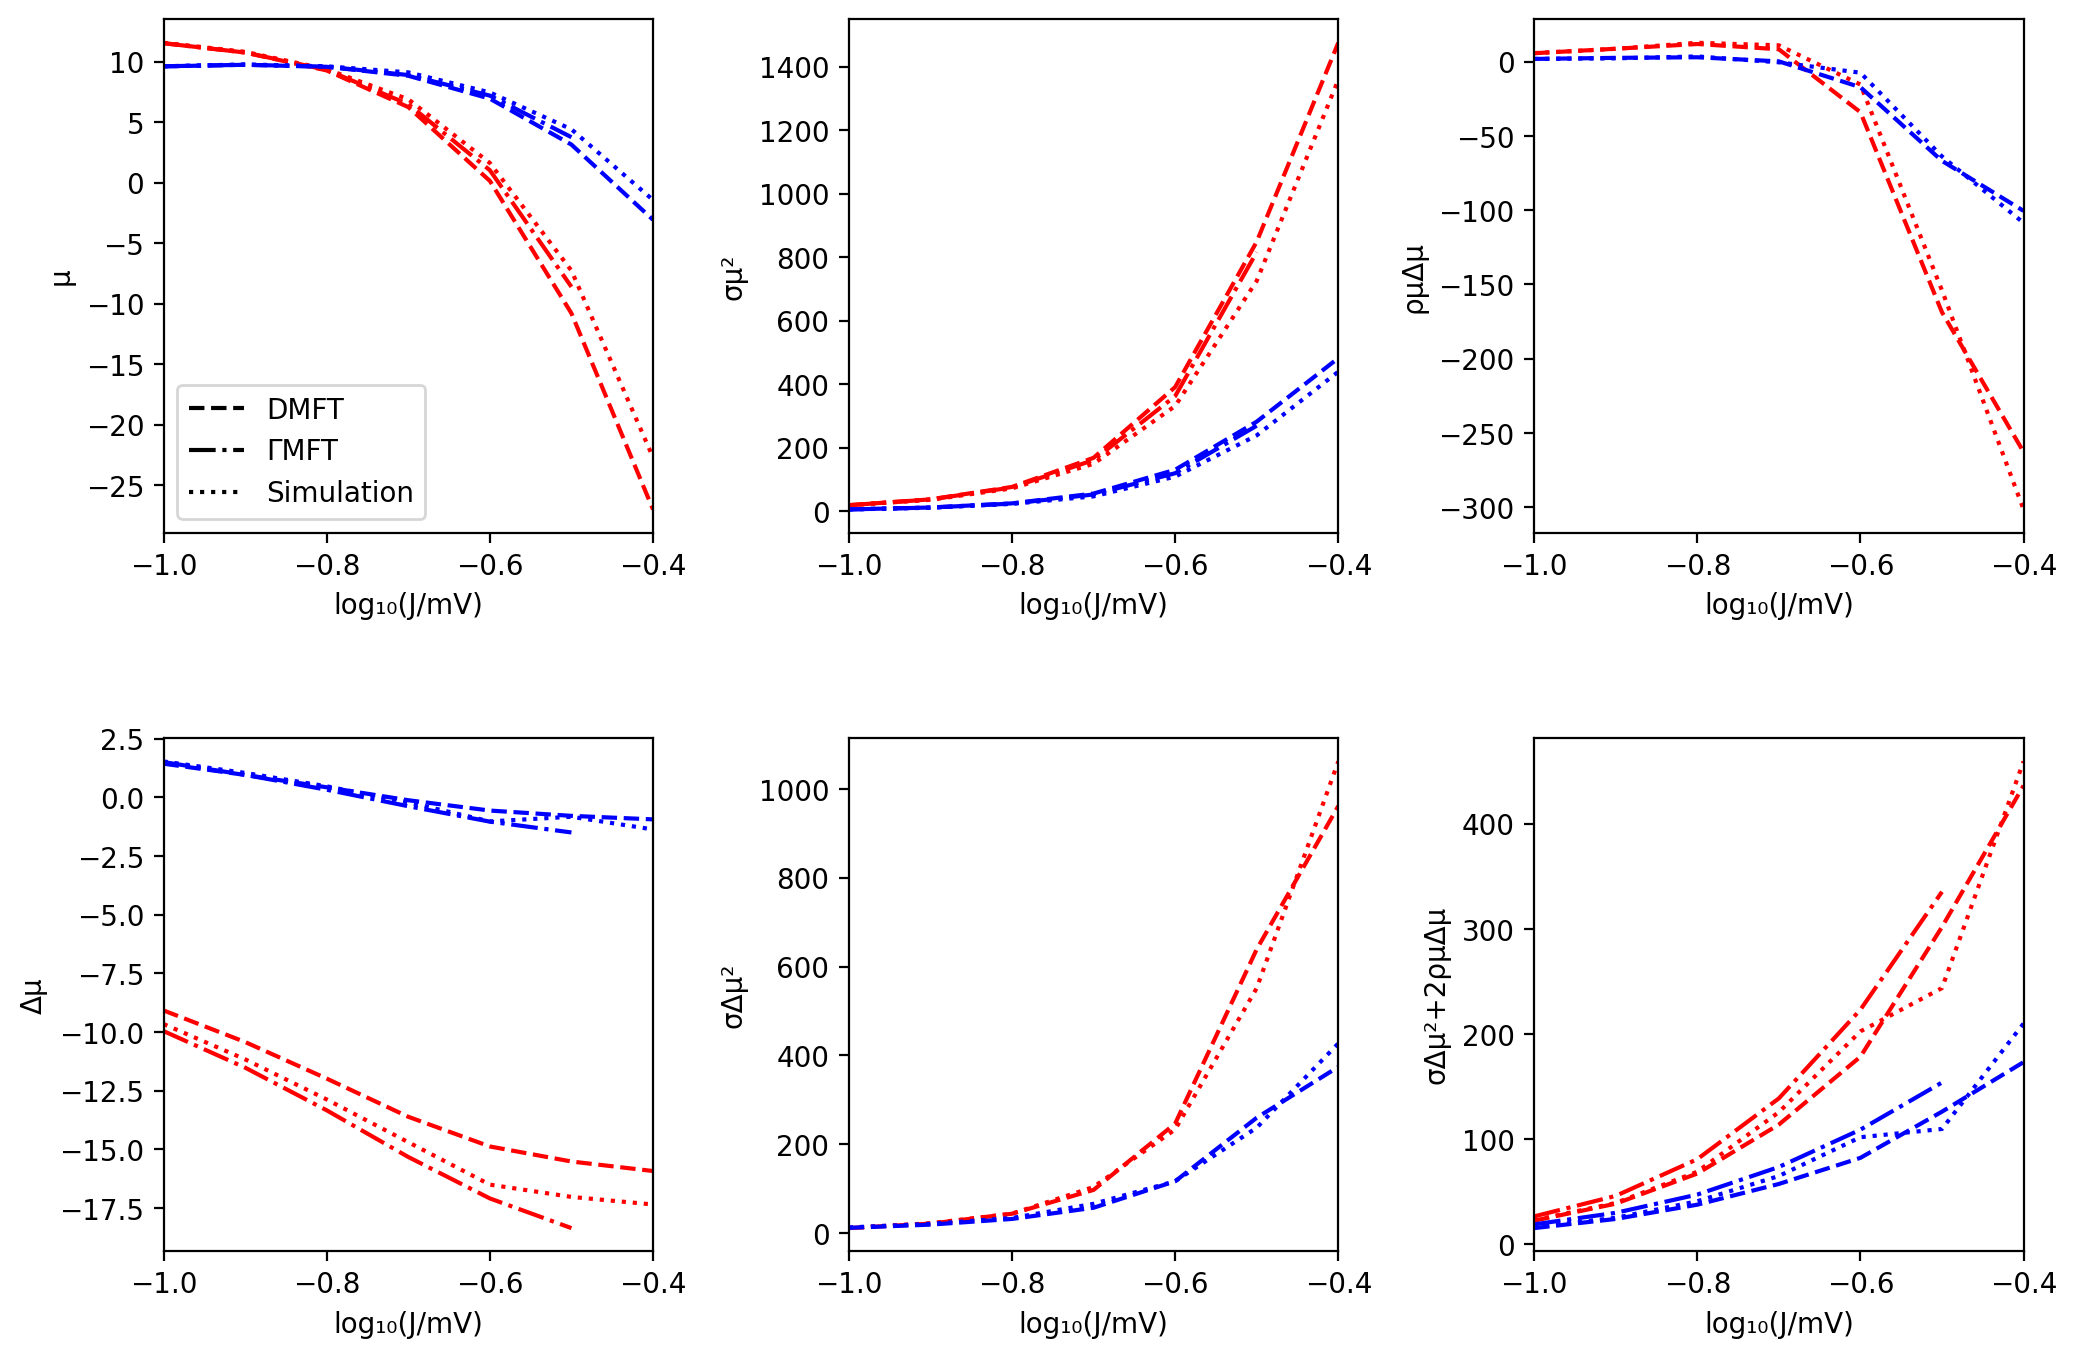

(-1.0, -0.4000000000000001)

In [581]:
figure(figsize=(4*3,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,3,1)
plot(log10.(Js),μEs,"r--")
plot(log10.(Js),μEsim,"r:")
plot(log10.(Js[1:6]),μEΓs,"r-.")
plot(log10.(Js),μIs,"b--")
plot(log10.(Js),μIsim,"b:")
plot(log10.(Js[1:6]),μIΓs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("μ")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,1)
plot([0],[0],"k--",label="DMFT")
plot([0],[0],"k-.",label="ΓMFT")
plot([0],[0],"k:",label="Simulation")
legend()

subplot(2,3,4)
plot(log10.(Js),ΔμEs,"r--")
plot(log10.(Js),ΔμEsim,"r:")
plot(log10.(Js[1:6]),ΔμEΓs,"r-.")
plot(log10.(Js),ΔμIs,"b--")
plot(log10.(Js),ΔμIsim,"b:")
plot(log10.(Js[1:6]),ΔμIΓs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("Δμ")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,2)
plot(log10.(Js),σμE2s,"r--")
plot(log10.(Js),σμE2sim,"r:")
plot(log10.(Js[1:6]),σμE2Γs,"r-.")
plot(log10.(Js),σμI2s,"b--")
plot(log10.(Js),σμI2sim,"b:")
plot(log10.(Js[1:6]),σμI2Γs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("σμ²")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,5)
plot(log10.(Js),σΔμE2s,"r--")
plot(log10.(Js),σΔμE2sim,"r:")
plot(log10.(Js),σΔμI2s,"b--")
plot(log10.(Js),σΔμI2sim,"b:")
xlabel("log₁₀(J/mV)")
ylabel("σΔμ²")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,3)
plot(log10.(Js),ρμEΔμEs,"r--")
plot(log10.(Js),ρμEΔμEsim,"r:")
plot(log10.(Js),ρμIΔμIs,"b--")
plot(log10.(Js),ρμIΔμIsim,"b:")
xlabel("log₁₀(J/mV)")
ylabel("ρμΔμ")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,6)
plot(log10.(Js),σΔμE2s+2ρμEΔμEs,"r--")
plot(log10.(Js),σΔμE2sim+2ρμEΔμEsim,"r:")
plot(log10.(Js[1:6]),ΔσμE2Γs,"r-.")
plot(log10.(Js),σΔμI2s+2ρμIΔμIs,"b--")
plot(log10.(Js),σΔμI2sim+2ρμIΔμIsim,"b:")
plot(log10.(Js[1:6]),ΔσμI2Γs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("σΔμ²+2ρμΔμ")
xlim((log10(Js[1]),log10(Js[end])))

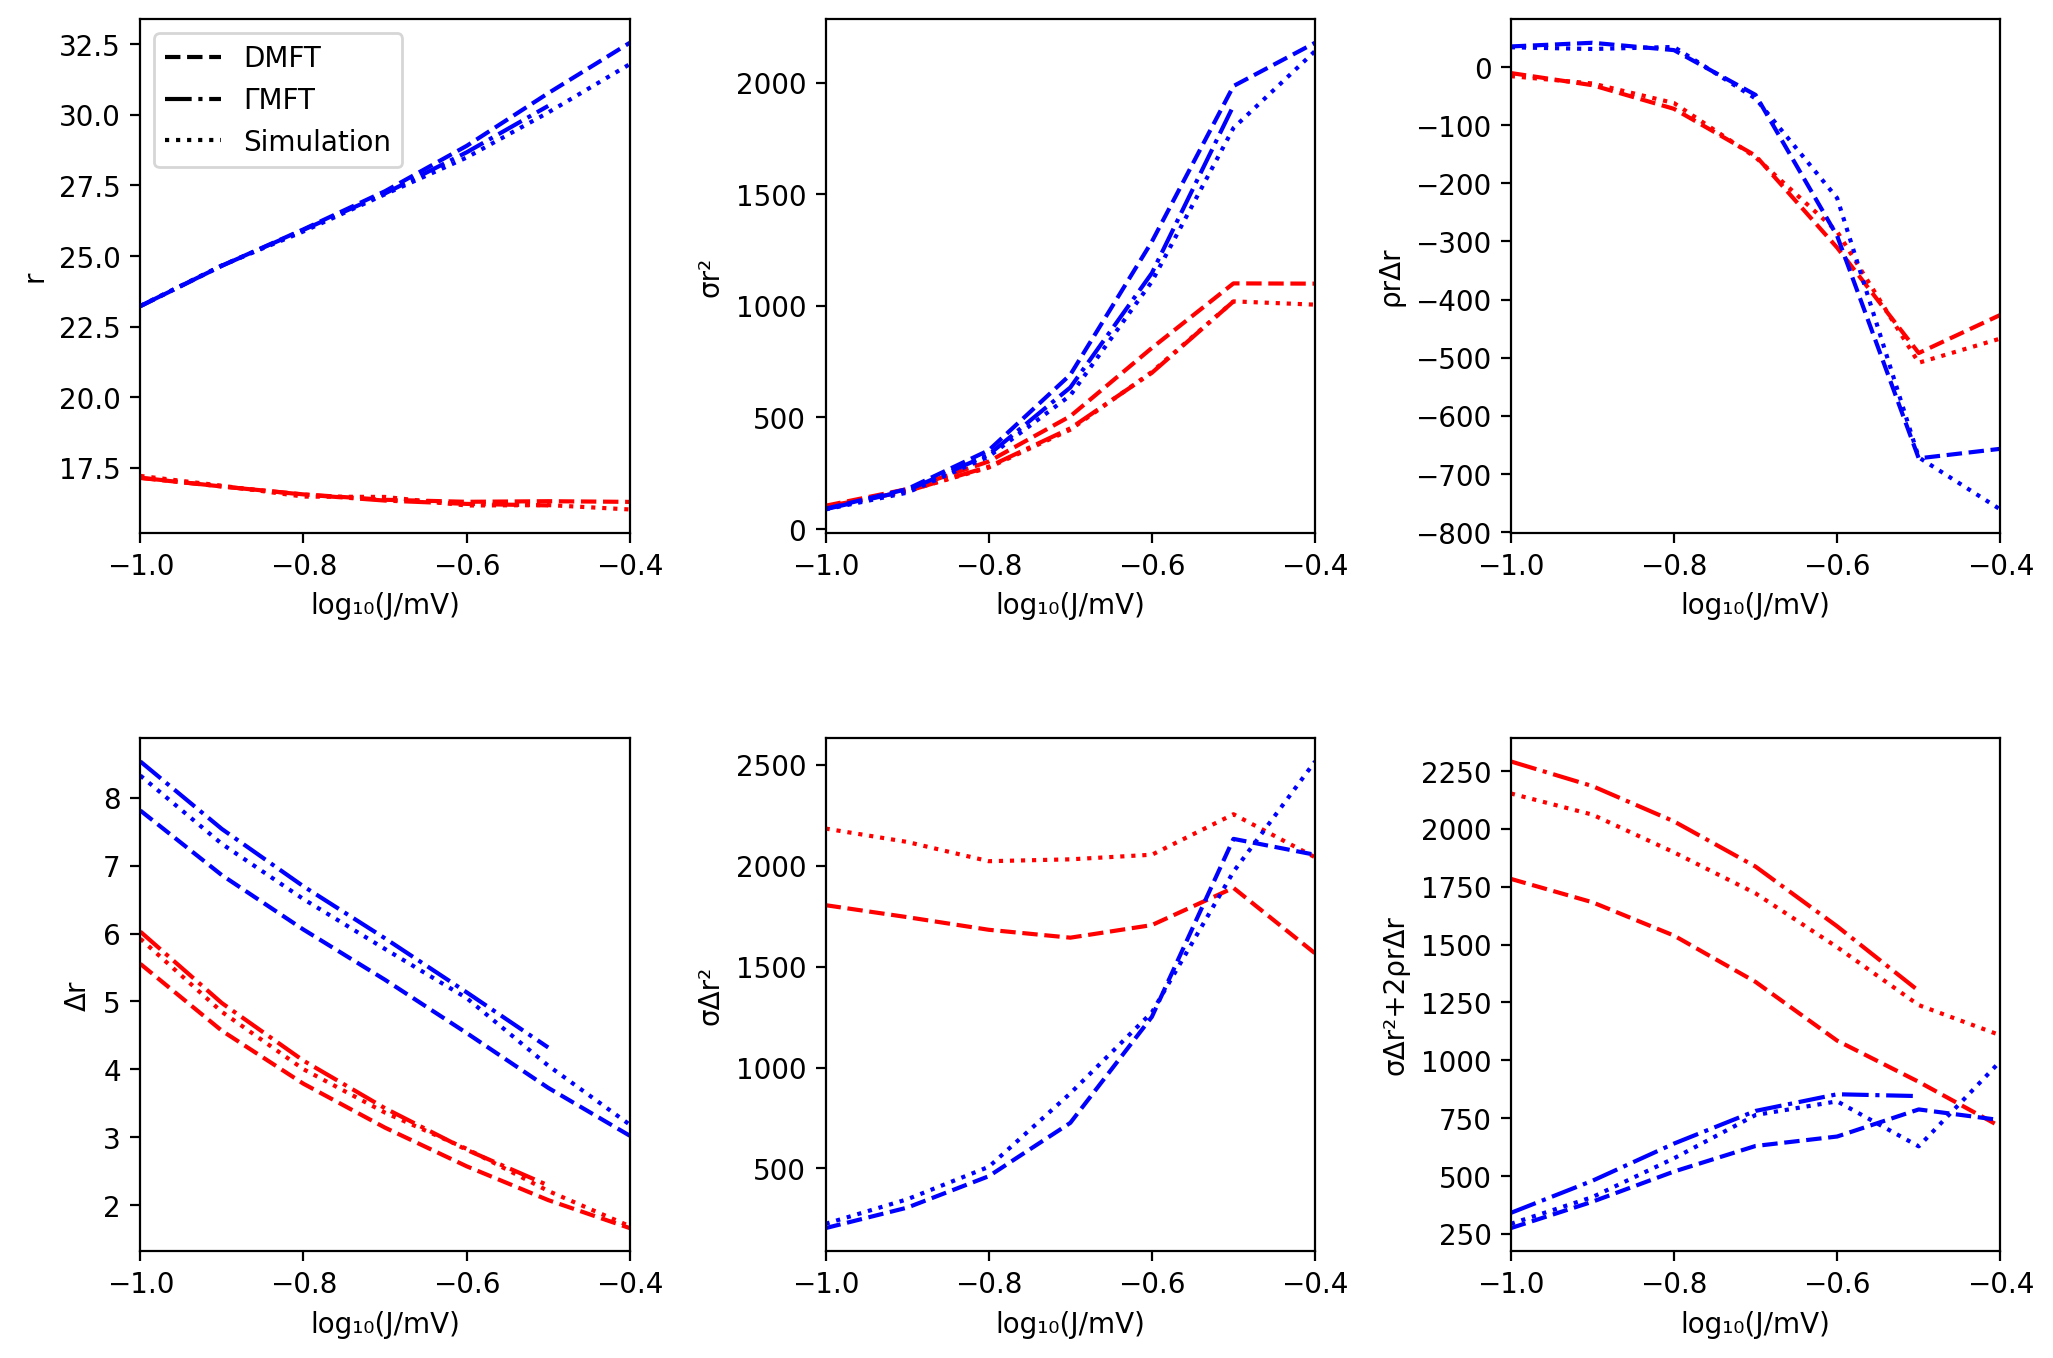

(-1.0, -0.4000000000000001)

In [580]:
figure(figsize=(4*3,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,3,1)
plot(log10.(Js),rEs,"r--")
plot(log10.(Js),rEsim,"r:")
plot(log10.(Js[1:6]),rEΓs,"r-.")
plot(log10.(Js),rIs,"b--")
plot(log10.(Js),rIsim,"b:")
plot(log10.(Js[1:6]),rIΓs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("r")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,1)
plot([0],[20],"k--",label="DMFT")
plot([0],[20],"k-.",label="ΓMFT")
plot([0],[20],"k:",label="Simulation")
legend()

subplot(2,3,4)
plot(log10.(Js),ΔrEs,"r--")
plot(log10.(Js),ΔrEsim,"r:")
plot(log10.(Js[1:6]),ΔrEΓs,"r-.")
plot(log10.(Js),ΔrIs,"b--")
plot(log10.(Js),ΔrIsim,"b:")
plot(log10.(Js[1:6]),ΔrIΓs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("Δr")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,2)
plot(log10.(Js),σrE2s,"r--")
plot(log10.(Js),σrE2sim,"r:")
plot(log10.(Js[1:6]),σrE2Γs,"r-.")
plot(log10.(Js),σrI2s,"b--")
plot(log10.(Js),σrI2sim,"b:")
plot(log10.(Js[1:6]),σrI2Γs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("σr²")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,5)
plot(log10.(Js),σΔrE2s,"r--")
plot(log10.(Js),σΔrE2sim,"r:")
plot(log10.(Js),σΔrI2s,"b--")
plot(log10.(Js),σΔrI2sim,"b:")
xlabel("log₁₀(J/mV)")
ylabel("σΔr²")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,3)
plot(log10.(Js),ρrEΔrEs,"r--")
plot(log10.(Js),ρrEΔrEsim,"r:")
plot(log10.(Js),ρrIΔrIs,"b--")
plot(log10.(Js),ρrIΔrIsim,"b:")
xlabel("log₁₀(J/mV)")
ylabel("ρrΔr")
xlim((log10(Js[1]),log10(Js[end])))

subplot(2,3,6)
plot(log10.(Js),σΔrE2s+2ρrEΔrEs,"r--")
plot(log10.(Js),σΔrE2sim+2ρrEΔrEsim,"r:")
plot(log10.(Js[1:6]),ΔσrE2Γs,"r-.")
plot(log10.(Js),σΔrI2s+2ρrIΔrIs,"b--")
plot(log10.(Js),σΔrI2sim+2ρrIΔrIsim,"b:")
plot(log10.(Js[1:6]),ΔσrI2Γs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("σΔr²+2ρrΔr")
xlim((log10(Js[1]),log10(Js[end])))

# Gamma Mean Field Theory

In [551]:
function MCΓ(rp::RateParams,μE::AbstractFloat,μI::AbstractFloat,μX::AbstractFloat,
        σE::AbstractFloat,σI::AbstractFloat,σX::AbstractFloat)
    kE = (μE/σE)^2
    kI = (μI/σI)^2
    kX = (μX/σX)^2
    θE = σE^2/μE
    θI = σI^2/μI
    θX = σX^2/μX
    n = 20000
    η = rand(Gamma(kE,θE),n)
    η .-= rand(Gamma(kI,θI),n)
    η .+= rand(Gamma(kX,θX),n)
    m = 0
    C = 0
    for i in 1:n
        r = Φ(rp,η[i])
        m += r
        C += r^2
    end
    return (m/n, C/n)
end

function MCLΓ(op::OptoParams,rp::RateParams,μE::AbstractFloat,μI::AbstractFloat,
        μX::AbstractFloat,σE::AbstractFloat,σI::AbstractFloat,σX::AbstractFloat)
    kE = (μE/σE)^2
    kI = (μI/σI)^2
    kX = (μX/σX)^2
    θE = σE^2/μE
    θI = σI^2/μI
    θX = σX^2/μX
    n = 50000
    η = rand(LogNormal(op.μ,op.σ),n)
    η .+= rand(Gamma(kE,θE),n)
    η .-= rand(Gamma(kI,θI),n)
    η .+= rand(Gamma(kX,θX),n)
    m = 0
    C = 0
    for i in 1:n
        r = Φ(rp,η[i])
        m += r
        C += r^2
    end
    return (m/n, C/n)
end

MCLΓ (generic function with 1 method)

In [564]:
function Γdmft(np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,Twrm::AbstractFloat,
        Tsave::AbstractFloat,dt::AbstractFloat;
        rEinit::AbstractFloat=1E-8,rIinit::AbstractFloat=1E-8,
        CE2init::AbstractFloat=1E2,CI2init::AbstractFloat=1E2,
        ΔrEinit::AbstractFloat=1E-8,ΔrIinit::AbstractFloat=1E-8,
        ΔCE2init::AbstractFloat=1E2,ΔCI2init::AbstractFloat=1E2)
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    rE = Array{Float64}(undef,Nint)
    rI = Array{Float64}(undef,Nint)
    CE = Array{Float64}(undef,Nint)
    CI = Array{Float64}(undef,Nint)
    ΔrE = Array{Float64}(undef,Nint)
    ΔrI = Array{Float64}(undef,Nint)
    ΔCE = Array{Float64}(undef,Nint)
    ΔCI = Array{Float64}(undef,Nint)

    rE[1] = rEinit
    rI[1] = rIinit
    CE[1] = CE2init
    CI[1] = CI2init
    ΔrE[1] = ΔrEinit
    ΔrI[1] = ΔrIinit
    ΔCE[1] = ΔCE2init
    ΔCI[1] = ΔCI2init
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    J2K = J^2*np.K
    W2 = np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2
    
    μEX = τE*JK*np.W[1,3]*rX
    μIX = τI*JK*np.W[2,3]*rX
    σEX = τE*√(J2K*W2[1,3]*(q*rX2+σrX2))
    σIX = τI*√(J2K*W2[2,3]*(q*rX2+σrX2))

    for i in 1:Nint-1
        μEE = τE*JK*np.W[1,1]*rE[i]
        μIE = τI*JK*np.W[2,1]*rE[i]
        μEI = -τE*JK*np.γ*np.W[1,2]*rI[i]
        μII = -τI*JK*np.γ*np.W[2,2]*rI[i]
        σEE = τE*√(J2K*W2[1,1]*(CE[i]-np.p*rE[i]^2))
        σIE = τI*√(J2K*W2[2,1]*(CE[i]-np.p*rE[i]^2))
        σEI = τE*√(J2K*np.γ*W2[1,2]*(CI[i]-np.p*rI[i]^2))
        σII = τI*√(J2K*np.γ*W2[2,2]*(CI[i]-np.p*rI[i]^2))
        mCE = MCΓ(np.rpE,μEE,μEI,μEX,σEE,σEI,σEX)
        mCI = MCΓ(np.rpI,μIE,μII,μIX,σIE,σII,σIX)
        rE[i+1] = rE[i] - dtτEinv*rE[i] + dtτEinv*mCE[1]
        rI[i+1] = rI[i] - dtτIinv*rI[i] + dtτIinv*mCI[1]
        CE[i+1] = CE[i] - 2dtτEinv*CE[i] + 2dtτEinv*mCE[2]
        CI[i+1] = CI[i] - 2dtτIinv*CI[i] + 2dtτIinv*mCI[2]
        if abs(rE[i+1]) > 1E10 || isnan(rE[i+1])
            @printf "CE[%d] = %f\n" i CE[i,i]
            @printf "CI[%d] = %f\n" i CI[i,i]
            @printf "rE[%d] = %f\n" i rE[i]
            @printf "rI[%d] = %f\n" i rI[i]
            @printf "rE[%d+1] = %f\n" i rE[i+1]
            @printf "rI[%d+1] = %f\n" i rI[i+1]
            println("system diverged")
            return (rE,rI,CE,CI)
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
    
    r̄E = mean(rE[end-Nsave+1:end])
    r̄I = mean(rI[end-Nsave+1:end])
    C̄E = mean(CE[end-Nsave+1:end])
    C̄I = mean(CI[end-Nsave+1:end])

    for i in 1:Nint-1
        μEE = τE*JK*np.W[1,1]*(r̄E+ΔrE[i])
        μIE = τI*JK*np.W[2,1]*(r̄E+ΔrE[i])
        μEI = -τE*JK*np.γ*np.W[1,2]*(r̄I+ΔrI[i])
        μII = -τI*JK*np.γ*np.W[2,2]*(r̄I+ΔrI[i])
        σEE = τE*√(J2K*W2[1,1]*((C̄E+ΔCE[i])-np.p*(r̄E+ΔrE[i])^2))
        σIE = τI*√(J2K*W2[2,1]*((C̄E+ΔCE[i])-np.p*(r̄E+ΔrE[i])^2))
        σEI = τE*√(J2K*np.γ*W2[1,2]*((C̄I+ΔCI[i])-np.p*(r̄I+ΔrI[i])^2))
        σII = τI*√(J2K*np.γ*W2[2,2]*((C̄I+ΔCI[i])-np.p*(r̄I+ΔrI[i])^2))
        mCEL = MCLΓ(op,np.rpE,μEE,μEI,μEX,σEE,σEI,σEX)
        mCIL = MCΓ(np.rpI,μIE,μII,μIX,σIE,σII,σIX)
        ΔrE[i+1] = ΔrE[i] - dtτEinv*ΔrE[i] + dtτEinv*(mCEL[1]-r̄E)
        ΔrI[i+1] = ΔrI[i] - dtτIinv*ΔrI[i] + dtτIinv*(mCIL[1]-r̄I)
        ΔCE[i+1] = ΔCE[i] - 2dtτEinv*ΔCE[i] + 2dtτEinv*(mCEL[2]-C̄E)
        ΔCI[i+1] = ΔCI[i] - 2dtτIinv*ΔCI[i] + 2dtτIinv*(mCIL[2]-C̄I)
        if abs(ΔrE[i+1]) > 1E10 || isnan(ΔrE[i+1])
            @printf "ΔCE[%d] = %f\n" i ΔCE[i,i]
            @printf "ΔCI[%d] = %f\n" i ΔCI[i,i]
            @printf "ΔrE[%d] = %f\n" i ΔrE[i]
            @printf "ΔrI[%d] = %f\n" i ΔrI[i]
            @printf "ΔrE[%d+1] = %f\n" i ΔrE[i+1]
            @printf "ΔrI[%d+1] = %f\n" i ΔrI[i+1]
            println("system diverged")
            return (ΔrE,ΔrI,ΔCE,ΔCI)
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
#     return (μ[end],σ2[end,end:-1:end-Nsave+1])
    return (rE[end-Nsave+1:end],rI[end-Nsave+1:end],
        CE[end-Nsave+1:end]-rE[end-Nsave+1:end].^2,
        CI[end-Nsave+1:end]-rI[end-Nsave+1:end].^2,
        ΔrE[end-Nsave+1:end],ΔrI[end-Nsave+1:end],
        ΔCE[end-Nsave+1:end]-(r̄E.+ΔrE[end-Nsave+1:end]).^2 .+r̄E^2,
        ΔCI[end-Nsave+1:end]-(r̄I.+ΔrI[end-Nsave+1:end]).^2 .+r̄I^2)
end

Γdmft (generic function with 1 method)

In [565]:
TWrm = 1.0
TSave = 0.10
dt = 0.0005

Γdmft(np,10^-0.6,10^1.14,5dt,2dt,dt) # compile
@time rE,rI,σrE2,σrI2,ΔrE,ΔrI,ΔσrE2,ΔσrI2 = Γdmft(np,10^-0.6,10^1.14,TWrm,TSave,dt)

 74.173505 seconds (1.45 G allocations: 27.873 GiB, 4.54% gc time)


([16.221223948895364, 16.22823219659942, 16.220027980106956, 16.212852877109338, 16.209583498068568, 16.206522083552183, 16.208642223540675, 16.202873079760682, 16.204446515973476, 16.196311713695113  …  16.217541977128167, 16.21675247763375, 16.21269504975956, 16.21499390214344, 16.220743597824658, 16.221744271827173, 16.21971413869855, 16.219872438714187, 16.224366586864598, 16.225817951268347], [28.64150311736691, 28.664519950338025, 28.681615228809502, 28.69706588380176, 28.687715193112503, 28.662711744229387, 28.667675587251924, 28.66738618576846, 28.659149365711187, 28.659394803848137  …  28.685816270155264, 28.676285202501813, 28.655103284331137, 28.65003609762248, 28.644234819680843, 28.67284411715613, 28.686809420618143, 28.688088533511927, 28.694359624086072, 28.680864907306148], [700.6088689077567, 701.5428681195102, 699.7718541079867, 698.7056291675799, 698.4791535260214, 698.130464320989, 698.6189391342546, 697.0228538866492, 697.075847657092, 695.9191879392445  …  699.639

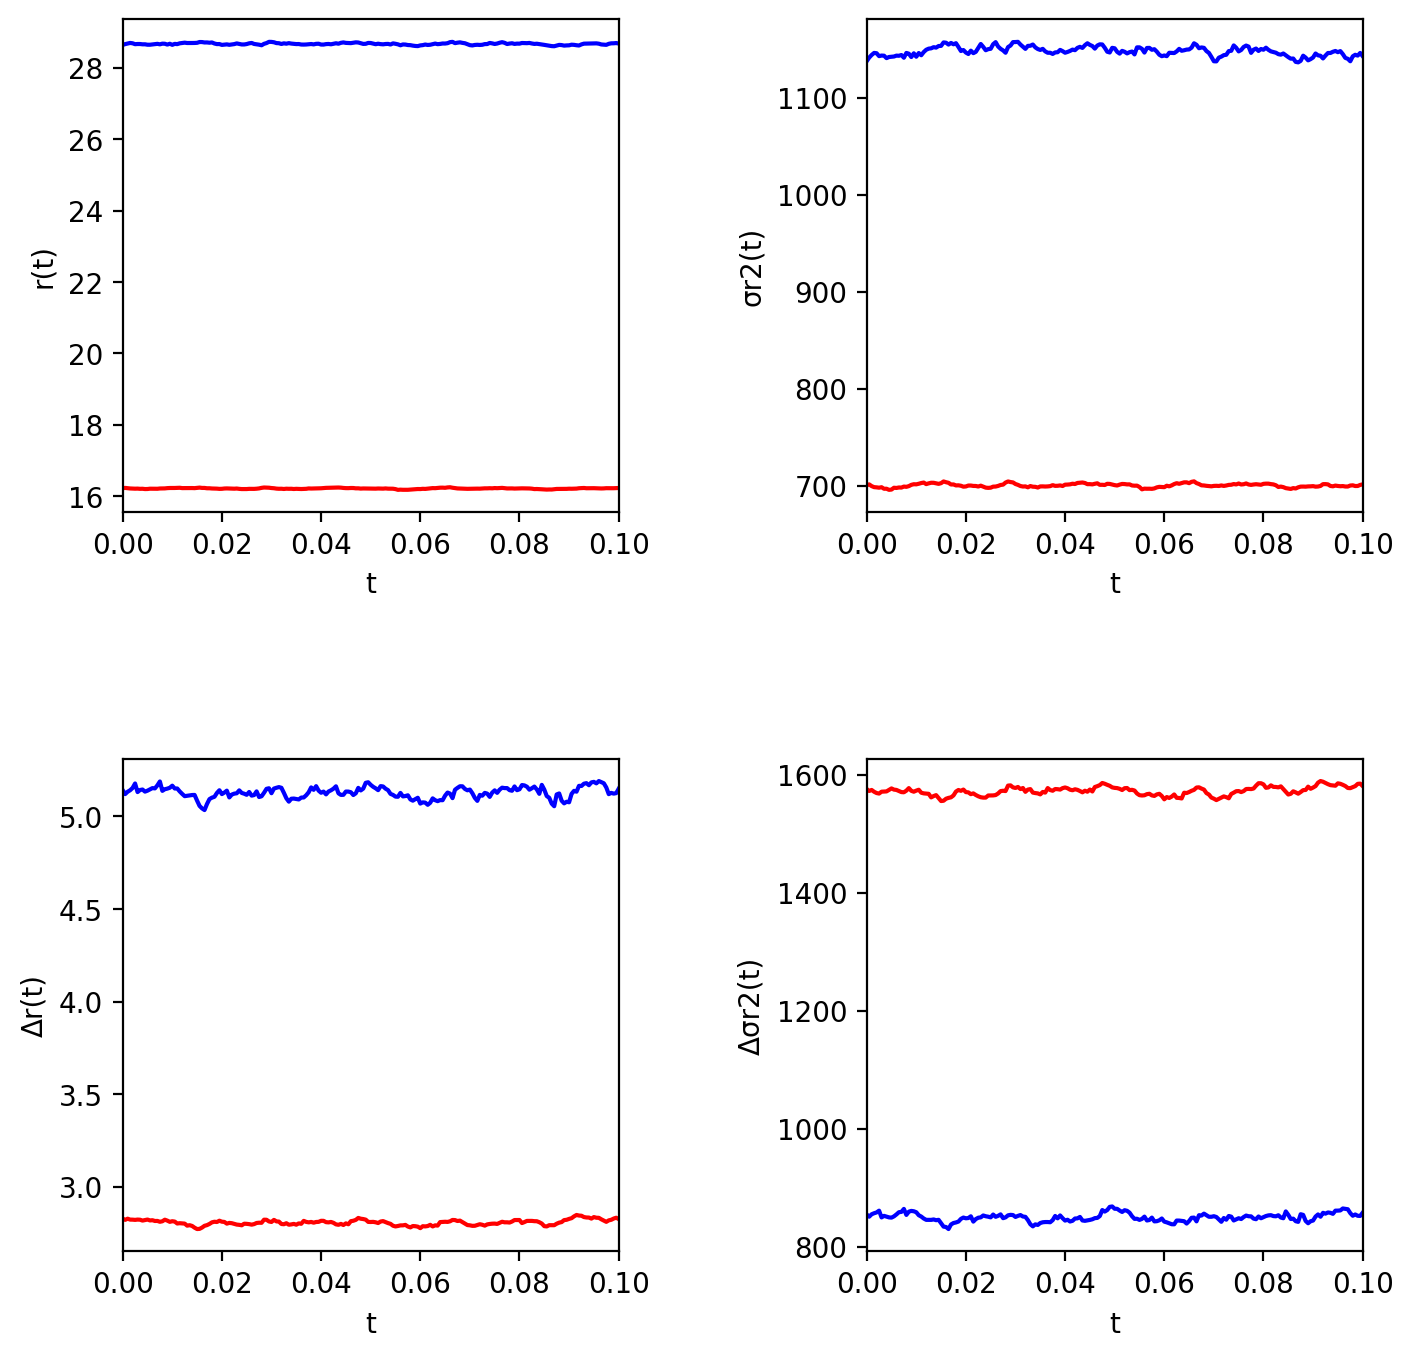

(0.0, 0.1)

In [566]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.5,wspace=0.5)

subplot(2,2,1)
plot(0.0:dt:TSave,rE,"r")
plot(0.0:dt:TSave,rI,"b")
xlabel("t")
ylabel("r(t)")
xlim((0.0,TSave))
# ylim((minimum(r)-1,maximum(r)+1))

subplot(2,2,2)
plot(0.0:dt:TSave,σrE2,"r")
plot(0.0:dt:TSave,σrI2,"b")
xlabel("t")
ylabel("σr2(t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σ2))-1,maximum(diag(σ2))+1))

subplot(2,2,3)
plot(0.0:dt:TSave,ΔrE,"r")
plot(0.0:dt:TSave,ΔrI,"b")
xlabel("t")
ylabel("Δr(t)")
xlim((0.0,TSave))
# ylim((minimum(r)-1,maximum(r)+1))

subplot(2,2,4)
plot(0.0:dt:TSave,ΔσrE2,"r")
plot(0.0:dt:TSave,ΔσrI2,"b")
xlabel("t")
ylabel("Δσr2(t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σ2))-1,maximum(diag(σ2))+1))

In [554]:
μEΓs = zeros(6)
μIΓs = zeros(6)
ΔμEΓs = zeros(6)
ΔμIΓs = zeros(6)
σμE2Γs = zeros(6)
σμI2Γs = zeros(6)
ΔσμE2Γs = zeros(6)
ΔσμI2Γs = zeros(6)

rEΓs = zeros(6)
rIΓs = zeros(6)
ΔrEΓs = zeros(6)
ΔrIΓs = zeros(6)
σrE2Γs = zeros(6)
σrI2Γs = zeros(6)
ΔσrE2Γs = zeros(6)
ΔσrI2Γs = zeros(6)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [567]:
for i in [1:6;]
    TWrm = 1.0
    TSave = 0.10
    dt = 0.0005

    @time rE,rI,σrE2,σrI2,ΔrE,ΔrI,ΔσrE2,ΔσrI2 = Γdmft(np,Js[i],10^1.14,TWrm,TSave,dt)
    
    rEΓs[i] = mean(rE)
    rIΓs[i] = mean(rI)
    ΔrEΓs[i] = mean(ΔrE)
    ΔrIΓs[i] = mean(ΔrI)
    σrE2Γs[i] = mean(σrE2)
    σrI2Γs[i] = mean(σrI2)
    ΔσrE2Γs[i] = mean(ΔσrE2)
    ΔσrI2Γs[i] = mean(ΔσrI2)
    
    rE = rEΓs[i]
    rI = rIΓs[i]
    rX = 10^1.14
    σrE2 = σrE2Γs[i]
    σrI2 = σrI2Γs[i]
    σrX2 = (np.sX*rX)^2
    μEΓs[i] = rpE.τs*Js[i]*np.K*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
    μIΓs[i] = rpI.τs*Js[i]*np.K*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
    σμE2Γs[i] = rpE.τs^2*Js[i]^2*np.K*(
        np.W[1,3]^2*σrX2+np.W[1,1]^2*σrE2+np.γ*np.W[1,2]^2*σrI2+
        (1-np.p)*(np.W[1,3]^2*rX^2+np.W[1,1]^2*rE^2+np.γ*np.W[1,2]^2*rI^2))
    σμI2Γs[i] = rpI.τs^2*Js[i]^2*np.K*(
        np.W[2,3]^2*σrX2+np.W[2,1]^2*σrE2+np.γ*np.W[2,2]^2*σrI2+
        (1-np.p)*(np.W[2,3]^2*rX^2+np.W[2,1]^2*rE^2+np.γ*np.W[2,2]^2*rI^2))
    
    ΔrE = ΔrEΓs[i]
    ΔrI = ΔrIΓs[i]
    ΔσrE2 = ΔσrE2Γs[i]
    ΔσrI2 = ΔσrI2Γs[i]
    ΔμEΓs[i] = rpE.τs*Js[i]*np.K*(np.W[1,1]*ΔrE+np.γ*np.W[1,2]*ΔrI)
    ΔμIΓs[i] = rpI.τs*Js[i]*np.K*(np.W[2,1]*ΔrE+np.γ*np.W[2,2]*ΔrI)
    ΔσμE2Γs[i] = rpE.τs^2*Js[i]^2*np.K*(
        np.W[1,1]^2*ΔσrE2+np.γ*np.W[1,2]^2*ΔσrI2+
        (1-np.p)*(np.W[1,1]^2*ΔrE*(ΔrE+2rE)+np.γ*np.W[1,2]^2*ΔrI*(ΔrI+2rI)))
    ΔσμI2Γs[i] = rpI.τs^2*Js[i]^2*np.K*(
        np.W[2,1]^2*ΔσrE2+np.γ*np.W[2,2]^2*ΔσrI2+
        (1-np.p)*(np.W[2,1]^2*ΔrE*(ΔrE+2rE)+np.γ*np.W[2,2]^2*ΔrI*(ΔrI+2rI)))
end

 78.390194 seconds (1.45 G allocations: 27.873 GiB, 4.37% gc time)
 70.441227 seconds (1.45 G allocations: 27.873 GiB, 4.48% gc time)
 70.507614 seconds (1.45 G allocations: 27.873 GiB, 4.48% gc time)
 76.168988 seconds (1.45 G allocations: 27.873 GiB, 4.41% gc time)
 70.285722 seconds (1.45 G allocations: 27.873 GiB, 4.71% gc time)
 68.793766 seconds (1.45 G allocations: 27.873 GiB, 4.57% gc time)


# Finite K Effects

In [592]:
Ks = [200,500,1000,2000]
skewEs = zeros(length(Ks))
skewIs = zeros(length(Ks))
kurtEs = zeros(length(Ks))
kurtIs = zeros(length(Ks))
μEsim = zeros(length(Ks))
μIsim = zeros(length(Ks))
σμE2sim = zeros(length(Ks))
σμI2sim = zeros(length(Ks))
rEsim = zeros(length(Ks))
rIsim = zeros(length(Ks))
σrE2sim = zeros(length(Ks))
σrI2sim = zeros(length(Ks))
μEs = zeros(length(Ks))
μIs = zeros(length(Ks))
σμE2s = zeros(length(Ks))
σμI2s = zeros(length(Ks))
rEs = zeros(length(Ks))
rIs = zeros(length(Ks))
σrE2s = zeros(length(Ks))
σrI2s = zeros(length(Ks))
μEΓs = zeros(length(Ks))
μIΓs = zeros(length(Ks))
σμE2Γs = zeros(length(Ks))
σμI2Γs = zeros(length(Ks))
rEΓs = zeros(length(Ks))
rIΓs = zeros(length(Ks))
σrE2Γs = zeros(length(Ks))
σrI2Γs = zeros(length(Ks))

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

In [588]:
function sim(np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,
        Twrm::AbstractFloat,Tsave::AbstractFloat,dts::AbstractFloat)
    N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    
    Eidx = 1:NE
    Iidx = NE+1:NX
    
    Crec = rand(Binomial(1,np.p),(NX,NX))
    W = zeros((NX,NX))
    W[Eidx,Eidx] .= np.W[1,1]*Crec[Eidx,Eidx]
    W[Eidx,Iidx] .= np.W[1,2]*Crec[Eidx,Iidx]
    W[Iidx,Eidx] .= np.W[2,1]*Crec[Iidx,Eidx]
    W[Iidx,Iidx] .= np.W[2,2]*Crec[Iidx,Iidx]
    W .*= J
    
    I = zeros(NX)
    I[Eidx] .= rand(Normal(J*np.K*np.W[1,3]*rX,
            √(np.K*(np.sX^2+(1-np.p)))*J*np.W[1,3]*rX),NE)
    I[Iidx] .= rand(Normal(J*np.K*np.W[2,3]*rX,
            √(np.K*(np.sX^2+(1-np.p)))*J*np.W[2,3]*rX),NI)
    
    Tsim = Twrm+Tsave
    τE = np.rpE.τs
    τI = np.rpI.τs
    τEinv = 1/τE
    τIinv = 1/τI
    τinv = [τEinv*ones(NE);τIinv*ones(NI)]
    tspan = (0.0,Tsim)              # define time span to simulate
    tsave = Twrm:dts:Tsim           # define times to save network state
    
#     τW = Diagonal([np.rpE.τs*ones(NE);np.rpI.τs*ones(NI)])*W
    
    beta2 = 0.045
    rtol = 1e-8
    tol = 1e-8
    gamma = 0.95
    dt = 0.017
    maxi = 10^7
    
    h0 = zeros(NX)
#     h0[Eidx] = μE[end].+√(σE2[end,end])*randn(NE)    # initialize network state
#     h0[Iidx] = μI[end].+√(σI2[end,end])*randn(NI)    # initialize network state
    r = Array{Float64}(undef,NX)     # preallocate vector of firing rates
    idxs = [1:NX;]                  # indices of neurons to measure
    function f(dh,h,nothing,t)      # function with equation of motion passed to 
                                    # DifferentialEquations
        dh .= I.-τinv.*h             # use dh vector initially to store αg-h
        for i in Eidx
            r[i] = Φ(rpE,h[i])
        end
        for i in Iidx
            r[i] = Φ(rpI,h[i])
        end
#         map!(μ->Φ(rpE,μ),r[Eidx],h[Eidx])# calculate firing rates
#         map!(μ->Φ(rpI,μ),r[Iidx],h[Iidx])# calculate firing rates
        @fastmath BLAS.gemv!('N',1.0,W,r,1.0,dh)
                                    # calculate increment of local fields
                                    # in place using BLAS
    end
    prob = ODEProblem(f,h0,tspan)
                                    # initialize ODE Problem for DifferentialEquations
    sol = solve(prob,Tsit5(),reltol=rtol,abstol=tol,beta2=beta2,gamma=gamma,dt=dt,
        save_idxs=idxs,save_everystep=false,saveat=tsave,
        maxiters=maxi)              # solve ODE using Tsitouras 5/4 Runge-Kutta method
    h = reduce(hcat,sol.u)'         # extract local fields from solution
    r = Array{Float64}(undef,size(h))     # preallocate vector of firing rates
    r[:,Eidx] .= [Φ(rpE,μ) for μ in h[:,Eidx]]
    r[:,Iidx] .= [Φ(rpI,μ) for μ in h[:,Iidx]]
#     map!(μ->Φ(rpE,μ),r[:,Eidx],h[:,Eidx])# calculate firing rates
#     map!(μ->Φ(rpI,μ),r[:,Iidx],h[:,Iidx])# calculate firing rates
    return (h[end,:],r[end,:])
end

sim (generic function with 1 method)

In [ ]:
for i in eachindex(Ks)
    J = 10^-0.6/√(Ks[i]/500)
    rX = 10^1.14
    np = NetworkParams(Ks[i],0.1,0.25,7.49,2.39,10.0^-0.51,1.0,2.0,0.2,rpE,rpI)
    
    N = round(Int,Ks[i]/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    
    TWrm = 70rpE.τs
    TSave = 1rpE.τs
    dt = rpI.τs/3
    
    nsim = round(Int,8000/Ks[i])
    hEsims = zeros(0)
    hIsims = zeros(0)
    rEsims = zeros(0)
    rIsims = zeros(0)
    for j in 1:nsim
        @time h,r = sim(np,J,rX,TWrm,TSave,dt)
        append!(hEsims,h[Eidx])
        append!(hIsims,h[Iidx])
        append!(rEsims,r[Eidx])
        append!(rIsims,r[Iidx])
    end
    
    skewEs[i] = skewness(hEsims)
    skewIs[i] = skewness(hIsims)
    kurtEs[i] = kurtosis(hEsims)
    kurtIs[i] = kurtosis(hIsims)
    
    μEsim[i] = mean(hEsims)
    μIsim[i] = mean(hIsims)
    σμE2sim[i] = var(hEsims)
    σμI2sim[i] = var(hIsims)
    
    rEsim[i] = mean(rEsims)
    rIsim[i] = mean(rIsims)
    σrE2sim[i] = var(rEsims)
    σrI2sim[i] = var(rIsims)
    
    @printf "%d/%d completed\n" i length(Ks)
end

In [599]:
for i in eachindex(Ks)
    J = 10^-0.6/√(Ks[i]/500)
    rX = 10^1.14
    np = NetworkParams(Ks[i],0.1,0.25,7.49,2.39,10.0^-0.51,1.0,2.0,0.2,rpE,rpI)
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.0025
    
    @time μE,μI,σμE2,σμI2 = dmft(np,J,rX,TWrm,TSave,dt)
    
    μEs[i] = μE[end]
    μIs[i] = μI[end]
    σμE2s[i] = σμE2[end,end]
    σμI2s[i] = σμI2[end,end]
    
    rEmft = M(rpE,μE[end],√(σμE2[end,end]))
    rImft = M(rpI,μI[end],√(σμI2[end,end]))
    CEEmft = C(np.rpE,μE[end],√(σμE2[end,end]),σμE2[end,end])
    CIImft = C(np.rpI,μI[end],√(σμI2[end,end]),σμI2[end,end])
    rE2mft = rEmft^2
    rI2mft = rImft^2
    σrE2mft = CEEmft .- rE2mft
    σrI2mft = CIImft .- rI2mft
    rEs[i] = rEmft
    rIs[i] = rImft
    σrE2s[i] = σrE2mft
    σrI2s[i] = σrI2mft
    
    TWrm = 1.0
    TSave = 0.10
    dt = 0.0005

    @time rE,rI,σrE2,σrI2,_,_,_,_ = Γdmft(np,J,rX,TWrm,TSave,dt)
    
    rEΓs[i] = mean(rE)
    rIΓs[i] = mean(rI)
    σrE2Γs[i] = mean(σrE2)
    σrI2Γs[i] = mean(σrI2)
    
    rE = rEΓs[i]
    rI = rIΓs[i]
    rX = 10^1.14
    σrE2 = σrE2Γs[i]
    σrI2 = σrI2Γs[i]
    σrX2 = (np.sX*rX)^2
    μEΓs[i] = rpE.τs*J*Ks[i]*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
    μIΓs[i] = rpI.τs*J*Ks[i]*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
    σμE2Γs[i] = rpE.τs^2*J^2*Ks[i]*(
        np.W[1,3]^2*σrX2+np.W[1,1]^2*σrE2+np.γ*np.W[1,2]^2*σrI2+
        (1-np.p)*(np.W[1,3]^2*rX^2+np.W[1,1]^2*rE^2+np.γ*np.W[1,2]^2*rI^2))
    σμI2Γs[i] = rpI.τs^2*J^2*Ks[i]*(
        np.W[2,3]^2*σrX2+np.W[2,1]^2*σrE2+np.γ*np.W[2,2]^2*σrI2+
        (1-np.p)*(np.W[2,3]^2*rX^2+np.W[2,1]^2*rE^2+np.γ*np.W[2,2]^2*rI^2))
    
    @printf "%d/%d completed\n" i length(Ks)
end

  0.253381 seconds (7.33 M allocations: 117.057 MiB, 7.81% gc time)
 70.969424 seconds (1.45 G allocations: 27.873 GiB, 4.26% gc time)
1/4 completed
  0.215413 seconds (7.33 M allocations: 117.057 MiB, 5.62% gc time)
 71.264659 seconds (1.45 G allocations: 27.873 GiB, 4.25% gc time)
2/4 completed
  0.290363 seconds (7.33 M allocations: 117.057 MiB, 4.42% gc time)
 76.014829 seconds (1.45 G allocations: 27.873 GiB, 4.29% gc time)
3/4 completed
  0.230108 seconds (7.33 M allocations: 117.057 MiB, 6.00% gc time)
 72.914507 seconds (1.45 G allocations: 27.873 GiB, 4.29% gc time)
4/4 completed


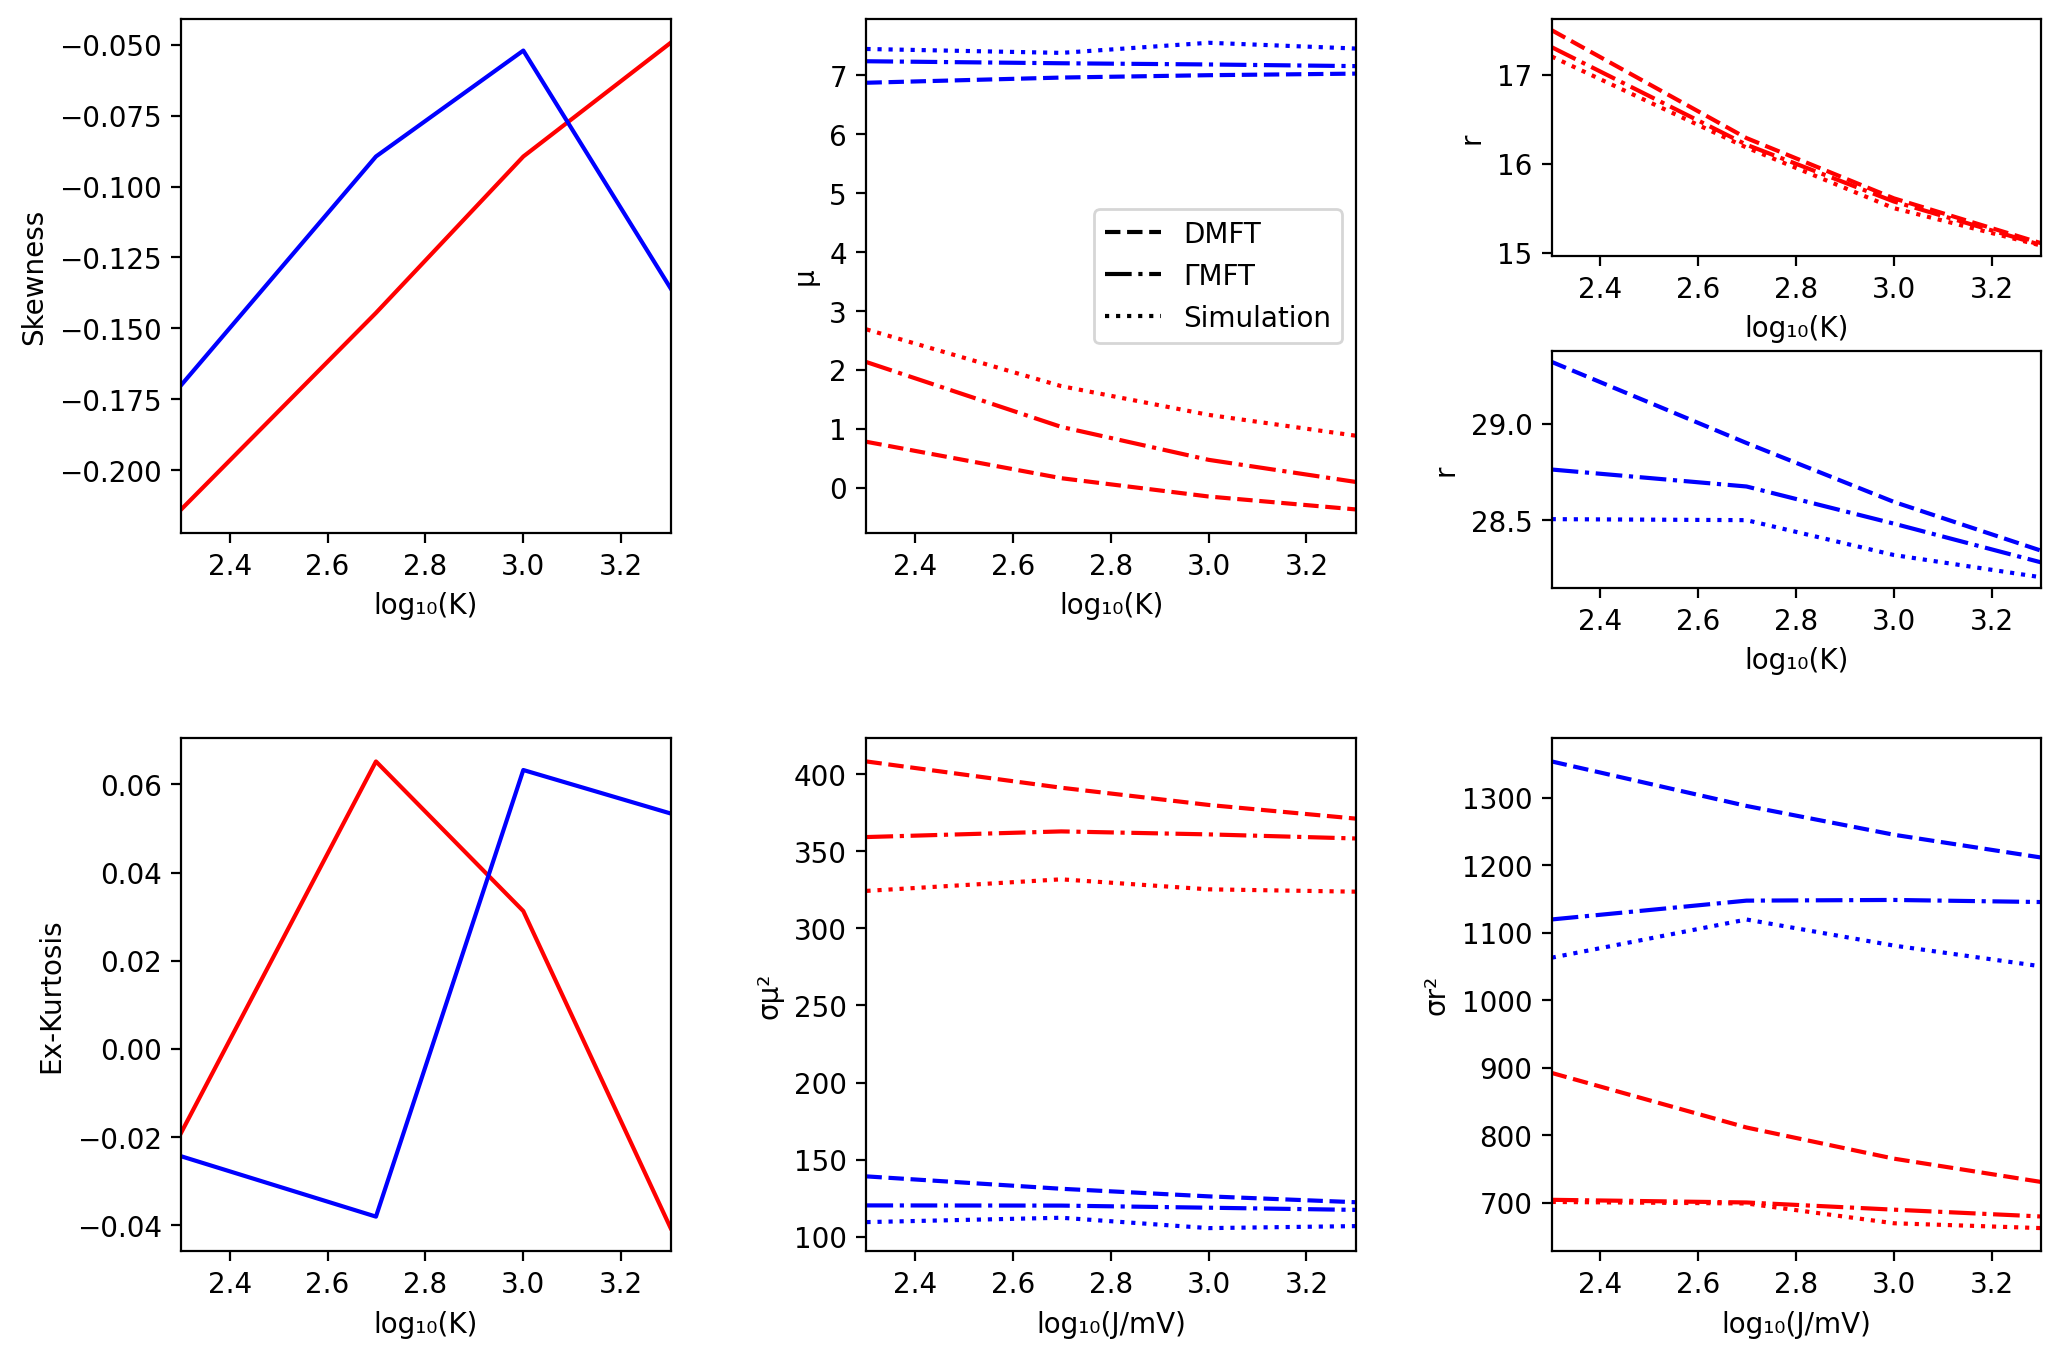

(2.3010299956639813, 3.3010299956639813)

In [601]:
figure(figsize=(4*3,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,3,1)
plot(log10.(Ks),skewEs,"r")
plot(log10.(Ks),skewIs,"b")
xlabel("log₁₀(K)")
ylabel("Skewness")
xlim((log10(Ks[1]),log10(Ks[end])))

subplot(2,3,4)
plot(log10.(Ks),kurtEs,"r")
plot(log10.(Ks),kurtIs,"b")
xlabel("log₁₀(K)")
ylabel("Ex-Kurtosis")
xlim((log10(Ks[1]),log10(Ks[end])))

subplot(2,3,2)
plot(log10.(Ks),μEs,"r--")
plot(log10.(Ks),μEsim,"r:")
plot(log10.(Ks),μEΓs,"r-.")
plot(log10.(Ks),μIs,"b--")
plot(log10.(Ks),μIsim,"b:")
plot(log10.(Ks),μIΓs,"b-.")
xlabel("log₁₀(K)")
ylabel("μ")
xlim((log10(Ks[1]),log10(Ks[end])))

subplot(2,3,2)
plot([0],[0],"k--",label="DMFT")
plot([0],[0],"k-.",label="ΓMFT")
plot([0],[0],"k:",label="Simulation")
legend()

subplot(2,3,5)
plot(log10.(Ks),σμE2s,"r--")
plot(log10.(Ks),σμE2sim,"r:")
plot(log10.(Ks),σμE2Γs,"r-.")
plot(log10.(Ks),σμI2s,"b--")
plot(log10.(Ks),σμI2sim,"b:")
plot(log10.(Ks),σμI2Γs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("σμ²")
xlim((log10(Ks[1]),log10(Ks[end])))

subplot(4,3,3)
plot(log10.(Ks),rEs,"r--")
plot(log10.(Ks),rEsim,"r:")
plot(log10.(Ks),rEΓs,"r-.")
xlabel("log₁₀(K)")
ylabel("r")
xlim((log10(Ks[1]),log10(Ks[end])))

subplot(4,3,6)
plot(log10.(Ks),rIs,"b--")
plot(log10.(Ks),rIsim,"b:")
plot(log10.(Ks),rIΓs,"b-.")
xlabel("log₁₀(K)")
ylabel("r")
xlim((log10(Ks[1]),log10(Ks[end])))

subplot(2,3,6)
plot(log10.(Ks),σrE2s,"r--")
plot(log10.(Ks),σrE2sim,"r:")
plot(log10.(Ks),σrE2Γs,"r-.")
plot(log10.(Ks),σrI2s,"b--")
plot(log10.(Ks),σrI2sim,"b:")
plot(log10.(Ks),σrI2Γs,"b-.")
xlabel("log₁₀(J/mV)")
ylabel("σr²")
xlim((log10(Ks[1]),log10(Ks[end])))

# Verify Steady State

In [486]:
TWrm = 1.0
TSave = 0.20
dt = 0.0025

dmft(np,10^-0.81,10^1.14,5dt,2dt,dt) # compile
@time μE,μI,σE2,σI2 = dmft(np,10^-0.81,10^1.14,TWrm,TSave,dt)

  0.099347 seconds (3.56 M allocations: 58.019 MiB, 4.89% gc time)


([9.492040083408698, 9.492040083408703, 9.492040083408709, 9.4920400834087, 9.492040083408705, 9.492040083408712, 9.492040083408702, 9.492040083408705, 9.492040083408702, 9.492040083408705  …  9.492040083408689, 9.492040083408689, 9.492040083408689, 9.492040083408687, 9.492040083408689, 9.492040083408689, 9.492040083408686, 9.492040083408684, 9.492040083408686, 9.492040083408687], [9.63123962295192, 9.631239622951927, 9.631239622951934, 9.63123962295192, 9.631239622951927, 9.631239622951936, 9.631239622951929, 9.631239622951934, 9.631239622951929, 9.631239622951934  …  9.631239622951922, 9.631239622951927, 9.631239622951934, 9.631239622951929, 9.631239622951929, 9.631239622951936, 9.631239622951933, 9.631239622951933, 9.631239622951927, 9.631239622951925], [71.56198395439844 71.56198395439844 … 71.56198395439904 71.56198395439907; 71.56198395439844 71.56198395439844 … 71.56198395439907 71.5619839543991; … ; 71.56198395439904 71.56198395439907 … 71.56198395439915 71.56198395439915; 71.5

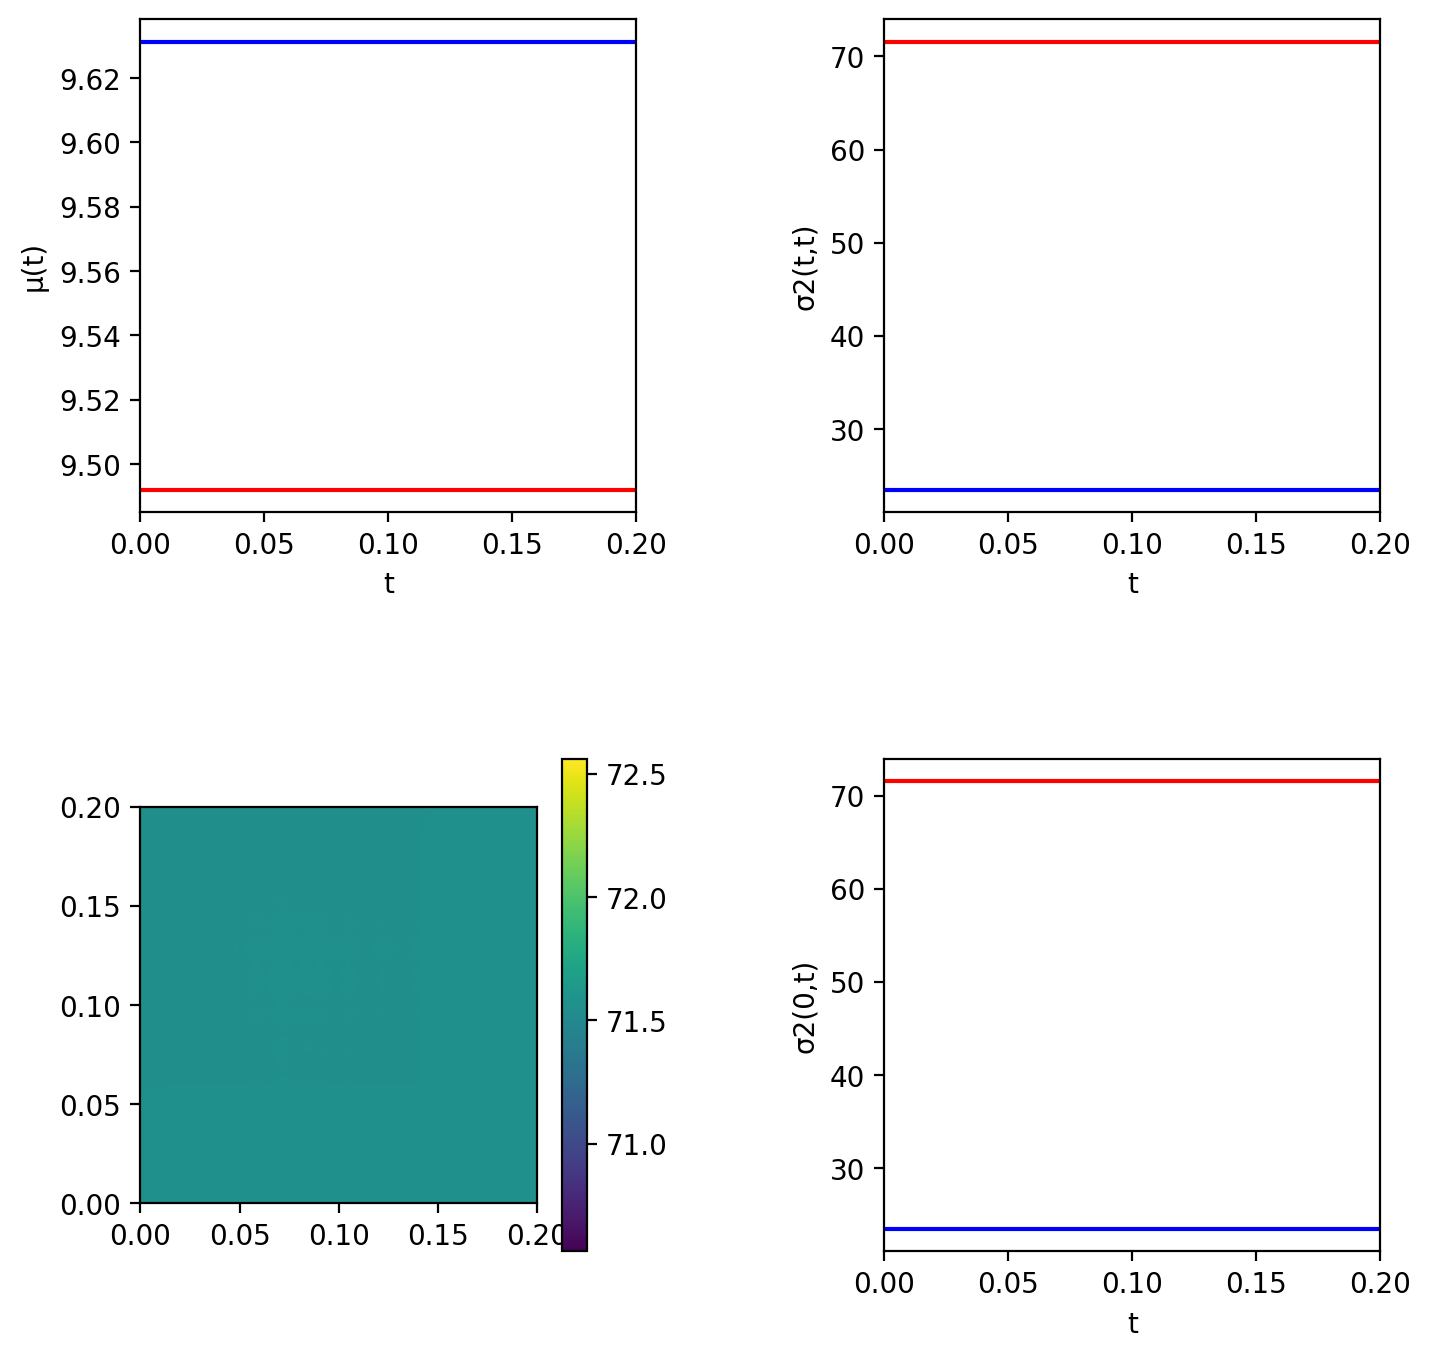

(0.0, 0.2)

In [489]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.5,wspace=0.5)

subplot(2,2,1)
plot(0.0:dt:TSave,μE,"r")
plot(0.0:dt:TSave,μI,"b")
xlabel("t")
ylabel("μ(t)")
xlim((0.0,TSave))
# ylim((minimum(μ)-1,maximum(μ)+1))

subplot(2,2,2)
plot(0.0:dt:TSave,diag(σE2),"r")
plot(0.0:dt:TSave,diag(σI2),"b")
xlabel("t")
ylabel("σ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σ2))-1,maximum(diag(σ2))+1))

subplot(2,2,3)
imshow(σE2,extent=([0.0,TSave,0.0,TSave]),vmin=minimum(σE2)-1,vmax=maximum(σE2)+1)
colorbar()

subplot(2,2,4)
plot(0.0:dt:TSave,σE2[1,:],"r")
plot(0.0:dt:TSave,σI2[1,:],"b")
xlabel("t")
ylabel("σ2(0,t)")
xlim((0.0,TSave))
# ylim((minimum(σ2[1,:])-1,
#         maximum(σ2[1,:])+1))

# subplot(2,2,4)
# plot(0.0:dt:TSave,σ2[end,end:-1:1])
# xlabel("t")
# ylabel("σ2(0,t)")
# xlim((0.0,TSave))
# ylim((minimum(σ2[end,end:-1:1])-1,
#         maximum(σ2[end,end:-1:1])+1))

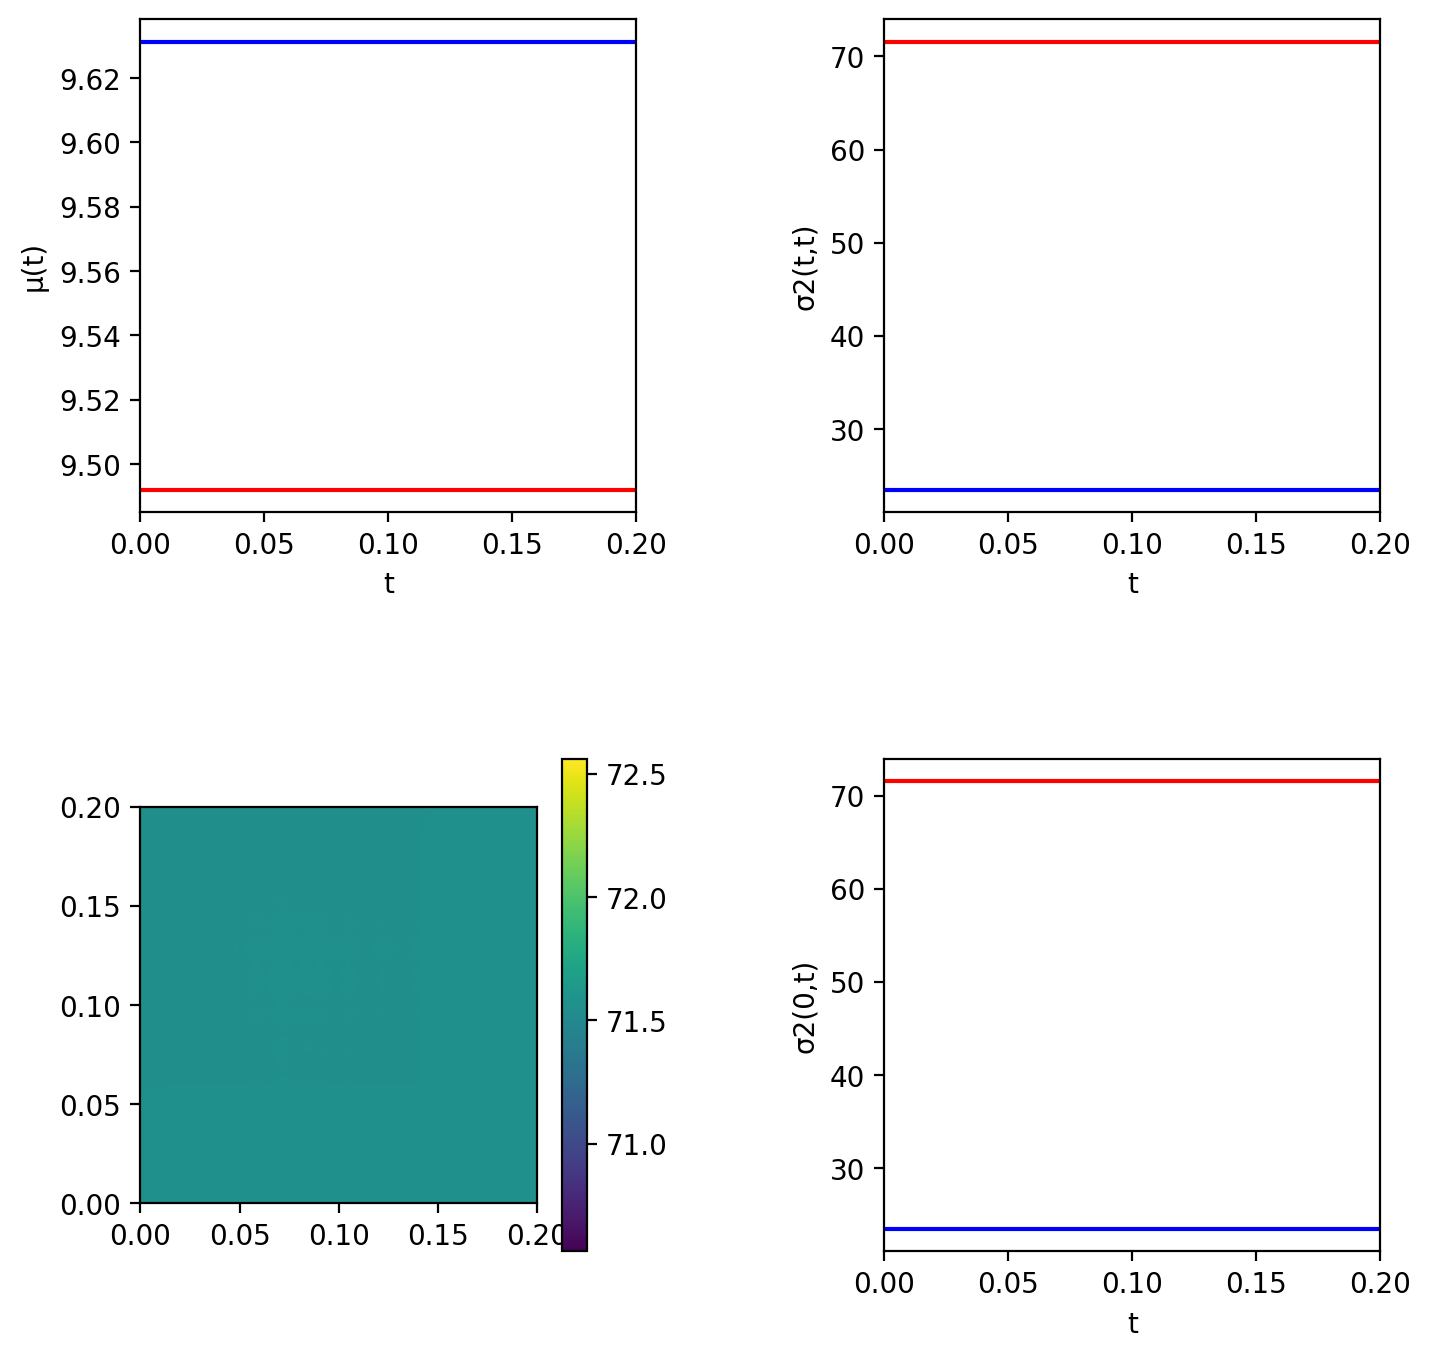

(0.0, 0.2)

In [449]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.5,wspace=0.5)

subplot(2,2,1)
plot(0.0:dt:TSave,μE,"r")
plot(0.0:dt:TSave,μI,"b")
xlabel("t")
ylabel("μ(t)")
xlim((0.0,TSave))
# ylim((minimum(μ)-1,maximum(μ)+1))

subplot(2,2,2)
plot(0.0:dt:TSave,diag(σE2),"r")
plot(0.0:dt:TSave,diag(σI2),"b")
xlabel("t")
ylabel("σ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σ2))-1,maximum(diag(σ2))+1))

subplot(2,2,3)
imshow(σE2,extent=([0.0,TSave,0.0,TSave]),vmin=minimum(σE2)-1,vmax=maximum(σE2)+1)
colorbar()

subplot(2,2,4)
plot(0.0:dt:TSave,σE2[1,:],"r")
plot(0.0:dt:TSave,σI2[1,:],"b")
xlabel("t")
ylabel("σ2(0,t)")
xlim((0.0,TSave))
# ylim((minimum(σ2[1,:])-1,
#         maximum(σ2[1,:])+1))

# subplot(2,2,4)
# plot(0.0:dt:TSave,σ2[end,end:-1:1])
# xlabel("t")
# ylabel("σ2(0,t)")
# xlim((0.0,TSave))
# ylim((minimum(σ2[end,end:-1:1])-1,
#         maximum(σ2[end,end:-1:1])+1))

In [450]:
TWrm = 1.0
TSave = 0.20
dt = 0.0025

optodmft(op,np,10^-0.81,10^1.14,5dt,2dt,dt,μE[end],μI[end],
    σE2[end,end:-1:1],σI2[end,end:-1:1]) # compile
@time ΔμE,ΔμI,σΔE2,σΔI2,ρE,ρI = optodmft(op,np,10^-0.81,10^1.14,TWrm,TSave,dt,μE[end],
    μI[end],σE2[end,end:-1:1],σI2[end,end:-1:1])

 22.150599 seconds (844.05 M allocations: 14.073 GiB, 7.92% gc time)


([-11.816199820827451, -11.816199820827439, -11.816199820827425, -11.816199820827434, -11.816199820827444, -11.816199820827451, -11.816199820827443, -11.816199820827435, -11.816199820827435, -11.816199820827443  …  -11.816199820827439, -11.816199820827432, -11.81619982082744, -11.816199820827444, -11.816199820827439, -11.816199820827432, -11.816199820827439, -11.816199820827443, -11.816199820827437, -11.81619982082743], [0.48264211370623683, 0.48264211370624505, 0.4826421137062576, 0.4826421137062523, 0.4826421137062486, 0.48264211370623744, 0.482642113706244, 0.48264211370624627, 0.48264211370625226, 0.4826421137062501  …  0.48264211370624427, 0.48264211370625204, 0.482642113706248, 0.48264211370624394, 0.4826421137062444, 0.4826421137062524, 0.48264211370624904, 0.4826421137062466, 0.48264211370624643, 0.4826421137062537], [40.18900427554516 40.189004275545095 … 40.18900427554542 40.18900427554543; 40.189004275545095 40.18900427554504 … 40.189004275545415 40.18900427554542; … ; 40.18

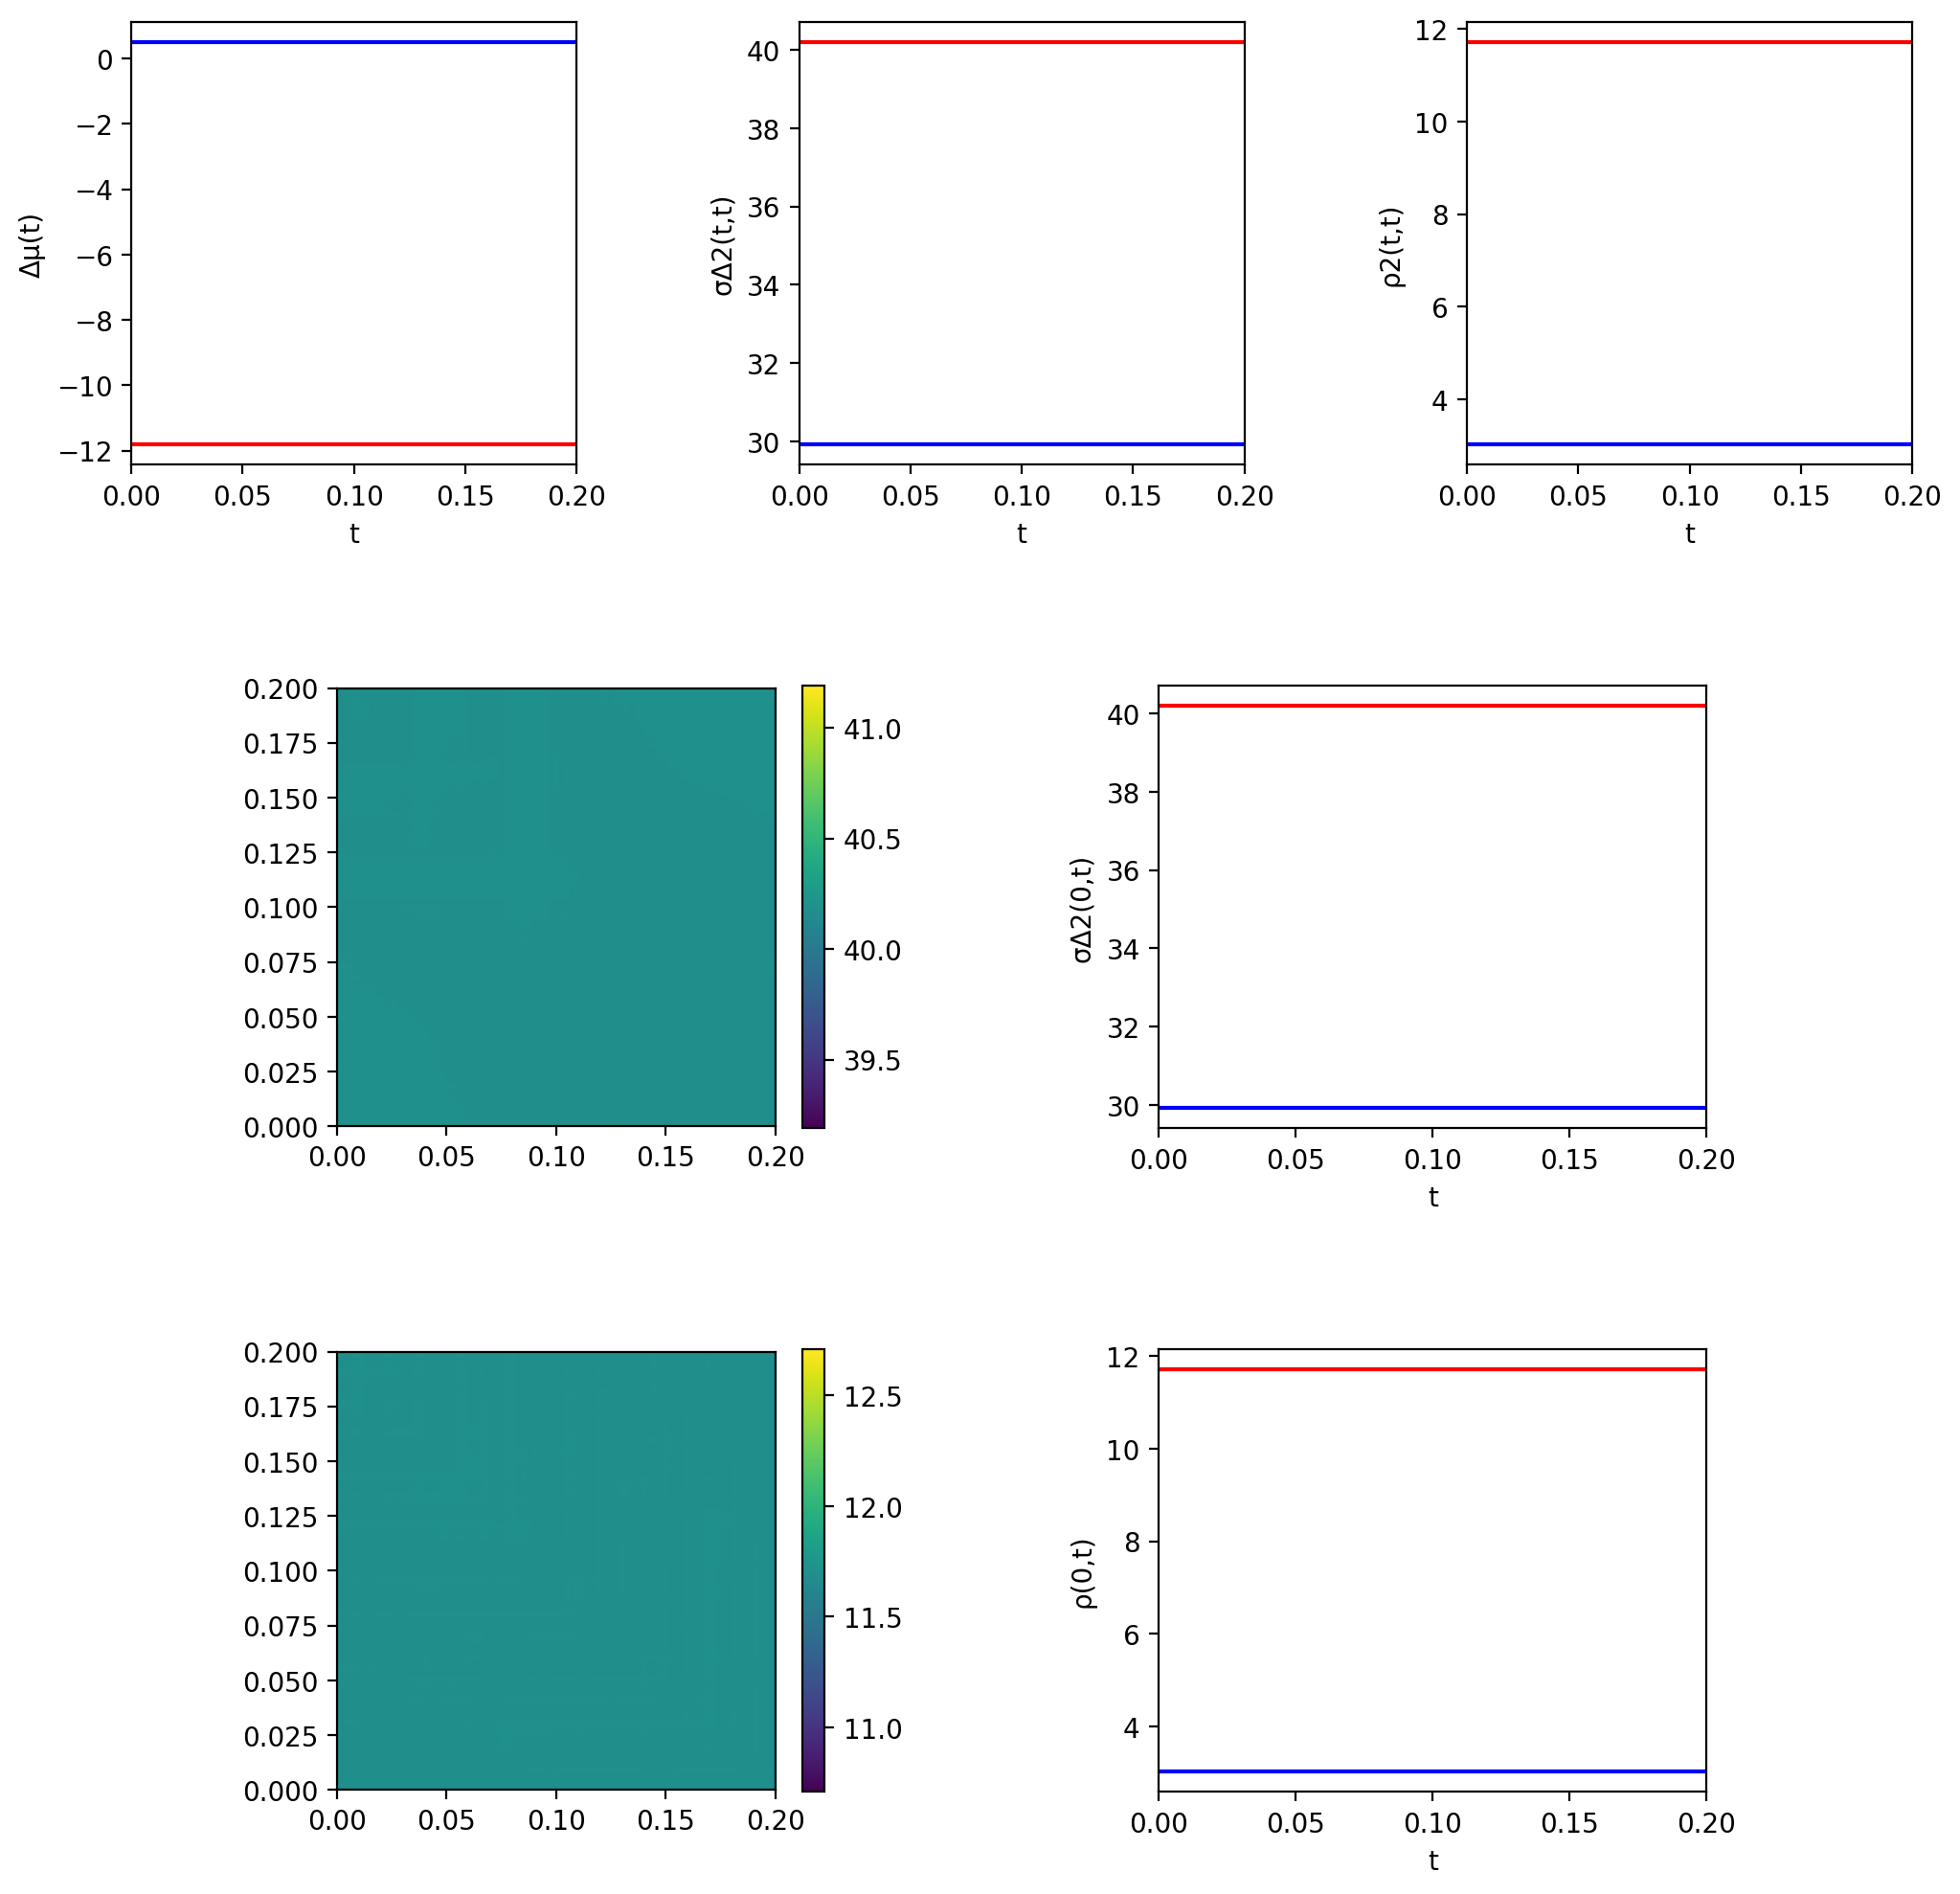

(0.0, 0.2)

In [451]:
figure(figsize=(4*3,4*3),dpi=200)
subplots_adjust(hspace=0.5,wspace=0.5)

subplot(3,3,1)
plot(0.0:dt:TSave,ΔμE,"r")
plot(0.0:dt:TSave,ΔμI,"b")
xlabel("t")
ylabel("Δμ(t)")
xlim((0.0,TSave))
# ylim((minimum(Δμ)-1,maximum(Δμ)+1))

subplot(3,3,2)
plot(0.0:dt:TSave,diag(σΔE2),"r")
plot(0.0:dt:TSave,diag(σΔI2),"b")
xlabel("t")
ylabel("σΔ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σΔ2))-1,maximum(diag(σΔ2))+1))

subplot(3,3,3)
plot(0.0:dt:TSave,diag(ρE),"r")
plot(0.0:dt:TSave,diag(ρI),"b")
xlabel("t")
ylabel("ρ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(ρ))-1,maximum(diag(ρ))+1))

subplot(3,9,(11,13))
imshow(σΔE2,extent=([0.0,TSave,0.0,TSave]),
    vmin=minimum(σΔE2)-1,vmax=maximum(σΔE2)+1)
colorbar()

subplot(3,9,(15,17))
plot(0.0:dt:TSave,σΔE2[1,:],"r")
plot(0.0:dt:TSave,σΔI2[1,:],"b")
xlabel("t")
ylabel("σΔ2(0,t)")
xlim((0.0,TSave))
# ylim((minimum(σΔ2[1,:])-1,
#         maximum(σΔ2[1,:])+1))

subplot(3,9,(20,22))
imshow(ρE,extent=([0.0,TSave,0.0,TSave]),vmin=minimum(ρE)-1,vmax=maximum(ρE)+1)
colorbar()

subplot(3,9,(24,26))
plot(0.0:dt:TSave,ρE[1,:],"r")
plot(0.0:dt:TSave,ρI[1,:],"b")
xlabel("t")
ylabel("ρ(0,t)")
xlim((0.0,TSave))
# ylim((minimum(ρ[1,:])-1,
#         maximum(ρ[1,:])+1))

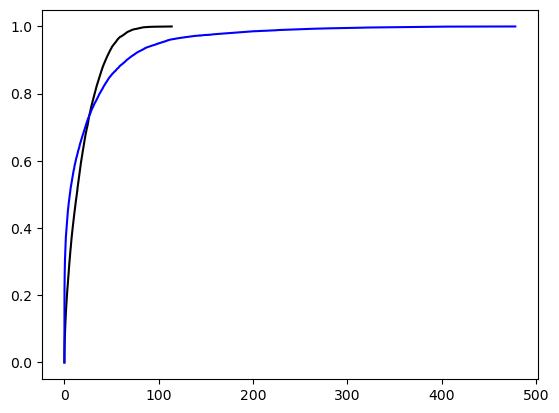

(16.285970910118433, 25.718802515093856, 16.834552301841082, 18.12023388864413)
(21.584499294250335, 32.468770390895386, 47.34904242565849, 29.067072471735784)


In [34]:
let n = 10000
    μEs = μE[end] .+ √(σE2[end,end])*randn(n)
    μIs = μI[end] .+ √(σI2[end,end])*randn(n÷4)
    μELs = μE[end]+ΔμE[end] .+ √(σE2[end,end]+σΔE2[end,end]+2ρE[end,end])*randn(n) +
            rand(LogNormal(op.μ,op.σ),n)
    μILs = μI[end]+ΔμI[end] .+ √(σI2[end,end]+σΔI2[end,end]+2ρI[end,end])*randn(n÷4)
    rEs = [Φ(rpE,μE) for μE in μEs]
    rIs = [Φ(rpI,μI) for μI in μIs]
    rELs = [Φ(rpE,μEL) for μEL in μELs]
    rILs = [Φ(rpI,μIL) for μIL in μILs]
    plot(sort([rEs;rIs]),[0:(1+np.γ)n-1;]/((1+np.γ)n),"k")
    plot(sort([rELs;rILs]),[0:(1+np.γ)n-1;]/((1+np.γ)n),"b")
    println((mean(rEs),mean(rIs),std(rEs),std(rIs)))
    println((mean(rELs),mean(rILs),std(rELs),std(rILs)))
end

In [35]:
TWrm = 1.0
TSave = 0.20
dt = 0.0025

dmft(np,10^-0.81,10^1.62,5dt,2dt,dt) # compile
@time μE,μI,σE2,σI2 = dmft(np,10^-0.81,10^1.62,TWrm,TSave,dt)

  0.390169 seconds (5.53 M allocations: 89.997 MiB)


([15.404753342658498, 15.404753342658505, 15.404753342658509, 15.404753342658507, 15.404753342658513, 15.40475334265851, 15.4047533426585, 15.404753342658504, 15.404753342658509, 15.404753342658509  …  15.404753342658534, 15.404753342658537, 15.404753342658541, 15.404753342658536, 15.40475334265854, 15.404753342658534, 15.404753342658537, 15.404753342658541, 15.404753342658536, 15.40475334265854], [20.065647007724877, 20.06564700772488, 20.06564700772488, 20.065647007724877, 20.065647007724884, 20.06564700772489, 20.065647007724877, 20.065647007724877, 20.065647007724884, 20.065647007724884  …  20.065647007724877, 20.065647007724877, 20.06564700772488, 20.065647007724877, 20.06564700772488, 20.065647007724877, 20.065647007724877, 20.06564700772488, 20.065647007724877, 20.06564700772488], [771.9412698393726 771.9412698393724 … 771.9412698393703 771.9412698393703; 771.9412698393724 771.9412698393721 … 771.9412698393703 771.9412698393703; … ; 771.9412698393703 771.9412698393703 … 771.9412

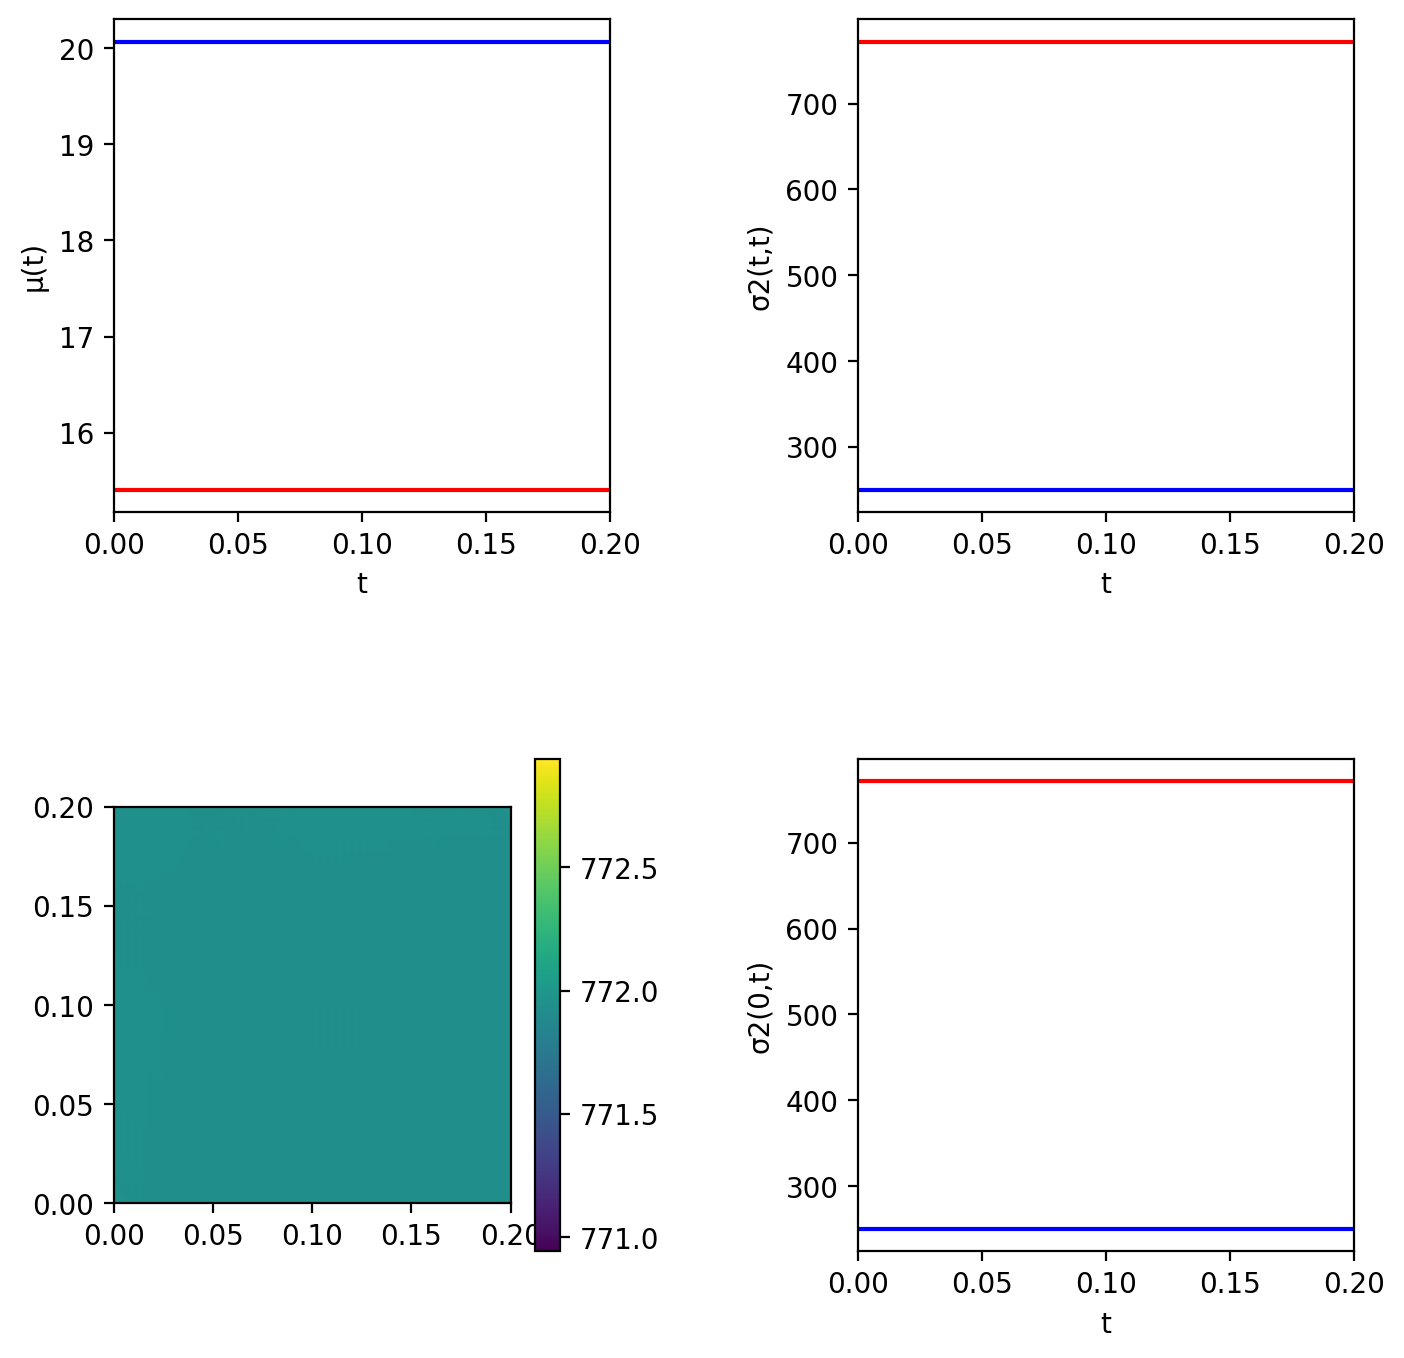

(0.0, 0.2)

In [36]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.5,wspace=0.5)

subplot(2,2,1)
plot(0.0:dt:TSave,μE,"r")
plot(0.0:dt:TSave,μI,"b")
xlabel("t")
ylabel("μ(t)")
xlim((0.0,TSave))
# ylim((minimum(μ)-1,maximum(μ)+1))

subplot(2,2,2)
plot(0.0:dt:TSave,diag(σE2),"r")
plot(0.0:dt:TSave,diag(σI2),"b")
xlabel("t")
ylabel("σ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σ2))-1,maximum(diag(σ2))+1))

subplot(2,2,3)
imshow(σE2,extent=([0.0,TSave,0.0,TSave]),vmin=minimum(σE2)-1,vmax=maximum(σE2)+1)
colorbar()

subplot(2,2,4)
plot(0.0:dt:TSave,σE2[1,:],"r")
plot(0.0:dt:TSave,σI2[1,:],"b")
xlabel("t")
ylabel("σ2(0,t)")
xlim((0.0,TSave))
# ylim((minimum(σ2[1,:])-1,
#         maximum(σ2[1,:])+1))

# subplot(2,2,4)
# plot(0.0:dt:TSave,σ2[end,end:-1:1])
# xlabel("t")
# ylabel("σ2(0,t)")
# xlim((0.0,TSave))
# ylim((minimum(σ2[end,end:-1:1])-1,
#         maximum(σ2[end,end:-1:1])+1))

In [37]:
TWrm = 1.0
TSave = 0.20
dt = 0.0025

optodmft(op,np,10^-0.81,10^1.62,5dt,2dt,dt,μE[end],μI[end],
    σE2[end,end:-1:1],σI2[end,end:-1:1]) # compile
@time ΔμE,ΔμI,σΔE2,σΔI2,ρE,ρI = optodmft(op,np,10^-0.81,10^1.62,TWrm,TSave,dt,μE[end],
    μI[end],σE2[end,end:-1:1],σI2[end,end:-1:1])

 42.791771 seconds (1.64 G allocations: 27.343 GiB, 9.36% gc time)


([-8.622789768951263, -8.62278976895126, -8.622789768951257, -8.622789768951256, -8.622789768951257, -8.62278976895126, -8.622789768951261, -8.622789768951263, -8.62278976895126, -8.622789768951257  …  -8.622789768951257, -8.62278976895126, -8.622789768951261, -8.622789768951263, -8.622789768951264, -8.622789768951263, -8.622789768951257, -8.622789768951256, -8.622789768951254, -8.622789768951256], [0.8994393239487654, 0.899439323948771, 0.8994393239487741, 0.8994393239487766, 0.8994393239487747, 0.8994393239487731, 0.8994393239487718, 0.8994393239487707, 0.8994393239487753, 0.8994393239487776  …  0.8994393239487776, 0.8994393239487755, 0.8994393239487738, 0.8994393239487724, 0.8994393239487712, 0.8994393239487654, 0.8994393239487728, 0.8994393239487756, 0.8994393239487778, 0.8994393239487757], [44.79024892320249 44.79024892320243 … 44.79024892320011 44.790248923200124; 44.79024892320243 44.79024892320237 … 44.79024892320012 44.79024892320014; … ; 44.79024892320011 44.79024892320012 … 

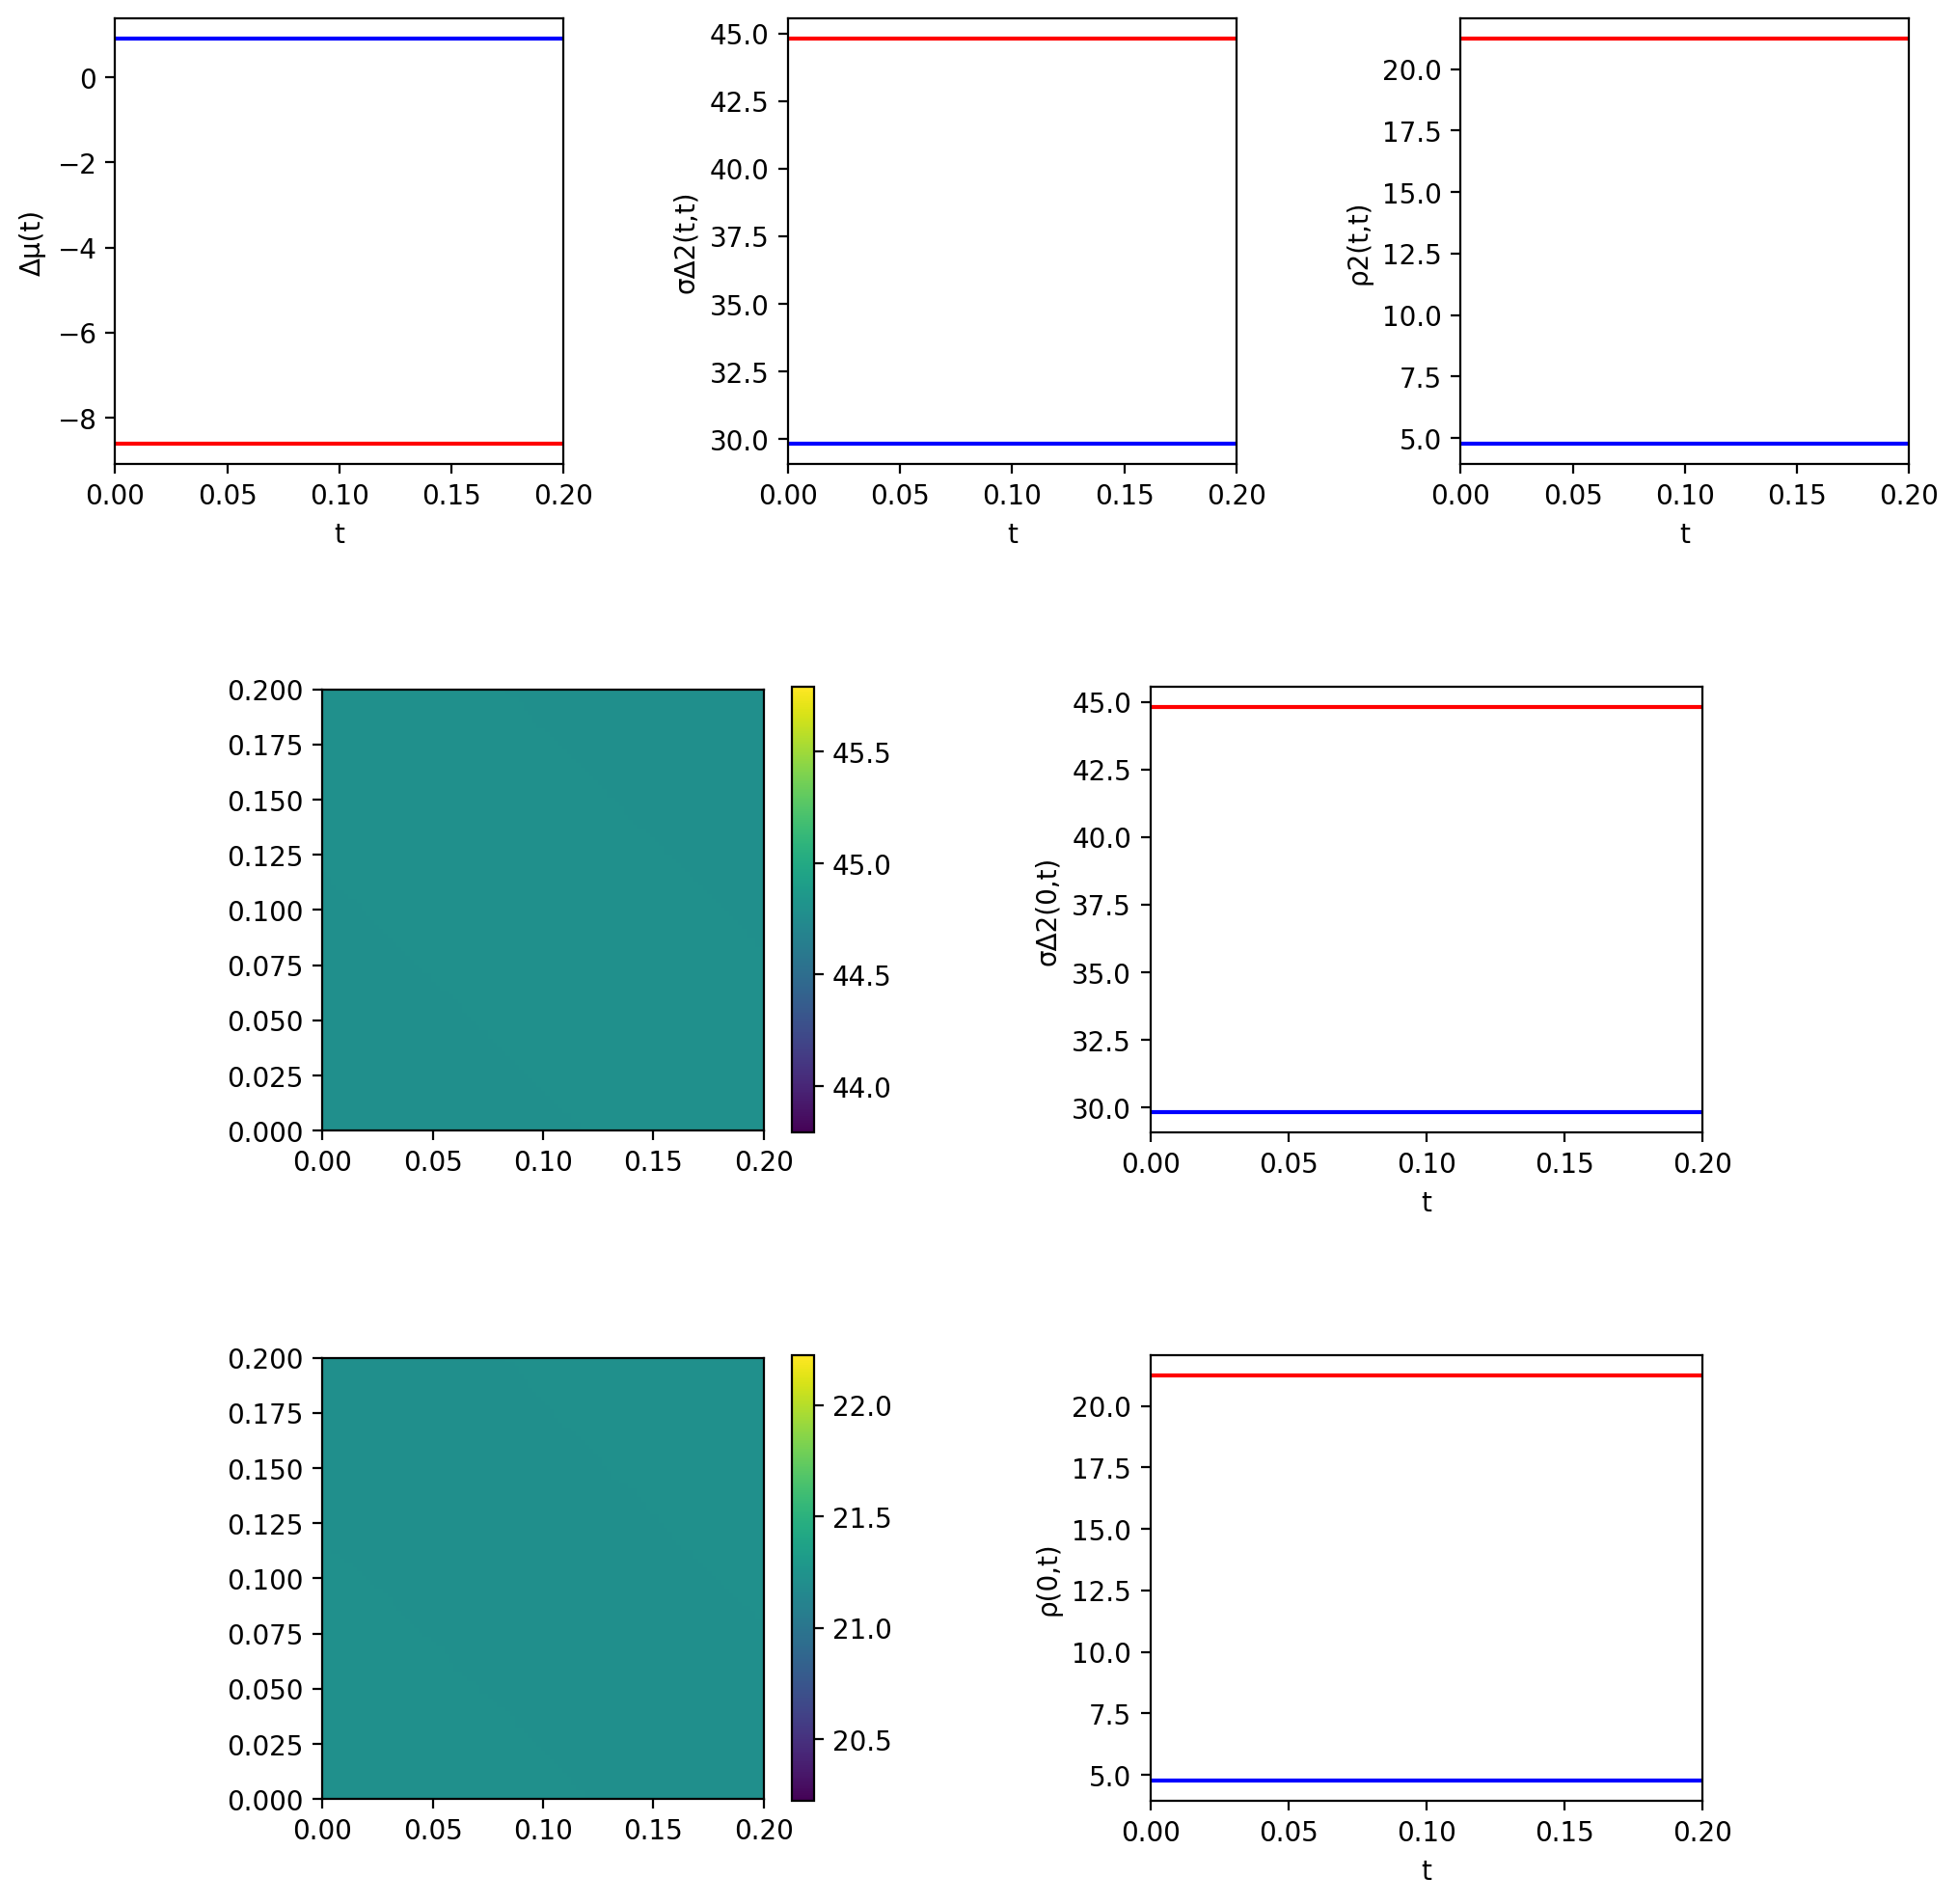

(0.0, 0.2)

In [38]:
figure(figsize=(4*3,4*3),dpi=200)
subplots_adjust(hspace=0.5,wspace=0.5)

subplot(3,3,1)
plot(0.0:dt:TSave,ΔμE,"r")
plot(0.0:dt:TSave,ΔμI,"b")
xlabel("t")
ylabel("Δμ(t)")
xlim((0.0,TSave))
# ylim((minimum(Δμ)-1,maximum(Δμ)+1))

subplot(3,3,2)
plot(0.0:dt:TSave,diag(σΔE2),"r")
plot(0.0:dt:TSave,diag(σΔI2),"b")
xlabel("t")
ylabel("σΔ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σΔ2))-1,maximum(diag(σΔ2))+1))

subplot(3,3,3)
plot(0.0:dt:TSave,diag(ρE),"r")
plot(0.0:dt:TSave,diag(ρI),"b")
xlabel("t")
ylabel("ρ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(ρ))-1,maximum(diag(ρ))+1))

subplot(3,9,(11,13))
imshow(σΔE2,extent=([0.0,TSave,0.0,TSave]),
    vmin=minimum(σΔE2)-1,vmax=maximum(σΔE2)+1)
colorbar()

subplot(3,9,(15,17))
plot(0.0:dt:TSave,σΔE2[1,:],"r")
plot(0.0:dt:TSave,σΔI2[1,:],"b")
xlabel("t")
ylabel("σΔ2(0,t)")
xlim((0.0,TSave))
# ylim((minimum(σΔ2[1,:])-1,
#         maximum(σΔ2[1,:])+1))

subplot(3,9,(20,22))
imshow(ρE,extent=([0.0,TSave,0.0,TSave]),vmin=minimum(ρE)-1,vmax=maximum(ρE)+1)
colorbar()

subplot(3,9,(24,26))
plot(0.0:dt:TSave,ρE[1,:],"r")
plot(0.0:dt:TSave,ρI[1,:],"b")
xlabel("t")
ylabel("ρ(0,t)")
xlim((0.0,TSave))
# ylim((minimum(ρ[1,:])-1,
#         maximum(ρ[1,:])+1))

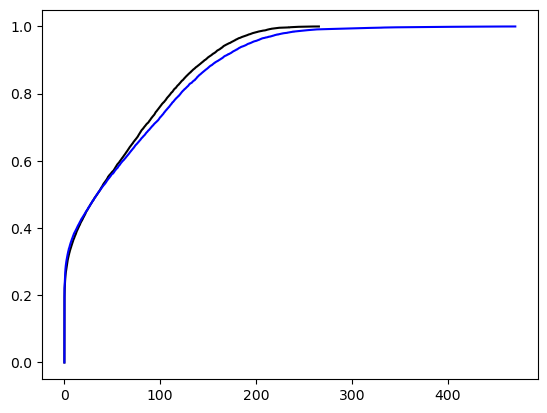

(48.713320714900746, 80.46609965666934, 56.09795145316443, 65.0571490371812)
(54.38532623471533, 85.28005411061564, 68.14061206363684, 68.73320267507142)


In [39]:
let n = 10000
    μEs = μE[end] .+ √(σE2[end,end])*randn(n)
    μIs = μI[end] .+ √(σI2[end,end])*randn(n÷4)
    μELs = μE[end]+ΔμE[end] .+ √(σE2[end,end]+σΔE2[end,end]+2ρE[end,end])*randn(n) +
            rand(LogNormal(op.μ,op.σ),n)
    μILs = μI[end]+ΔμI[end] .+ √(σI2[end,end]+σΔI2[end,end]+2ρI[end,end])*randn(n÷4)
    rEs = [Φ(rpE,μE) for μE in μEs]
    rIs = [Φ(rpI,μI) for μI in μIs]
    rELs = [Φ(rpE,μEL) for μEL in μELs]
    rILs = [Φ(rpI,μIL) for μIL in μILs]
    plot(sort([rEs;rIs]),[0:(1+np.γ)n-1;]/((1+np.γ)n),"k")
    plot(sort([rELs;rILs]),[0:(1+np.γ)n-1;]/((1+np.γ)n),"b")
    println((mean(rEs),mean(rIs),std(rEs),std(rIs)))
    println((mean(rELs),mean(rILs),std(rELs),std(rILs)))
end

# Verify Chaos

In [304]:
np = NetworkParams(3000,0.1,0.25,7.49,2.39,10.0^-0.51,1.0,2.0,0.2,rpE,rpI)

NetworkParams(3000, 0.1, 0.25, 0.2, RicciardiParams(20.0, 10.0, 10.0, 0.02, 0.002), RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002), AbstractFloat[1.0 -7.49 2.745; 3.2359365692962827 -7.733888400618116 0.6310076310127752])

In [307]:
TWrm = 1.0
TSave = 0.20
dt = 0.001

dmft(np,10^-0.51/√(6),10^1.14,5dt,2dt,dt) # compile
@time μE,μI,σE2,σI2 = dmft(np,10^-0.51/√(6),10^1.14,TWrm,TSave,dt)

  2.559715 seconds (21.76 M allocations: 354.722 MiB, 72.56% gc time)


([-9.208027103322612, -9.208062334098072, -9.208097452509165, -9.208132458991754, -9.208167353979558, -9.208202137904268, -9.208236811195484, -9.208271374280717, -9.208305827585486, -9.208340171533226  …  -9.213123245365745, -9.213143049827016, -9.21316279766854, -9.213182489078543, -9.213202124244514, -9.213221703353117, -9.213241226590352, -9.213260694141455, -9.213280106190885, -9.213299462922421], [3.7621858680333364, 3.762179470418048, 3.7621730933492223, 3.7621667367463747, 3.7621604005295115, 3.762154084618946, 3.762147788935427, 3.7621415134000586, 3.762135257934334, 3.7621290224601123  …  3.761261970671302, 3.7612583863814684, 3.761254812387528, 3.7612512486550265, 3.7612476951495974, 3.7612441518371234, 3.761240618683532, 3.7612370956548973, 3.76123358271746, 3.7612300798375475], [735.3086733518032 735.3070283650436 … 696.0984292605426 695.9640640094526; 735.3070283650436 735.3103872118628 … 696.248031915382 696.1120991413502; … ; 696.0984292605426 696.248031915382 … 735.5643

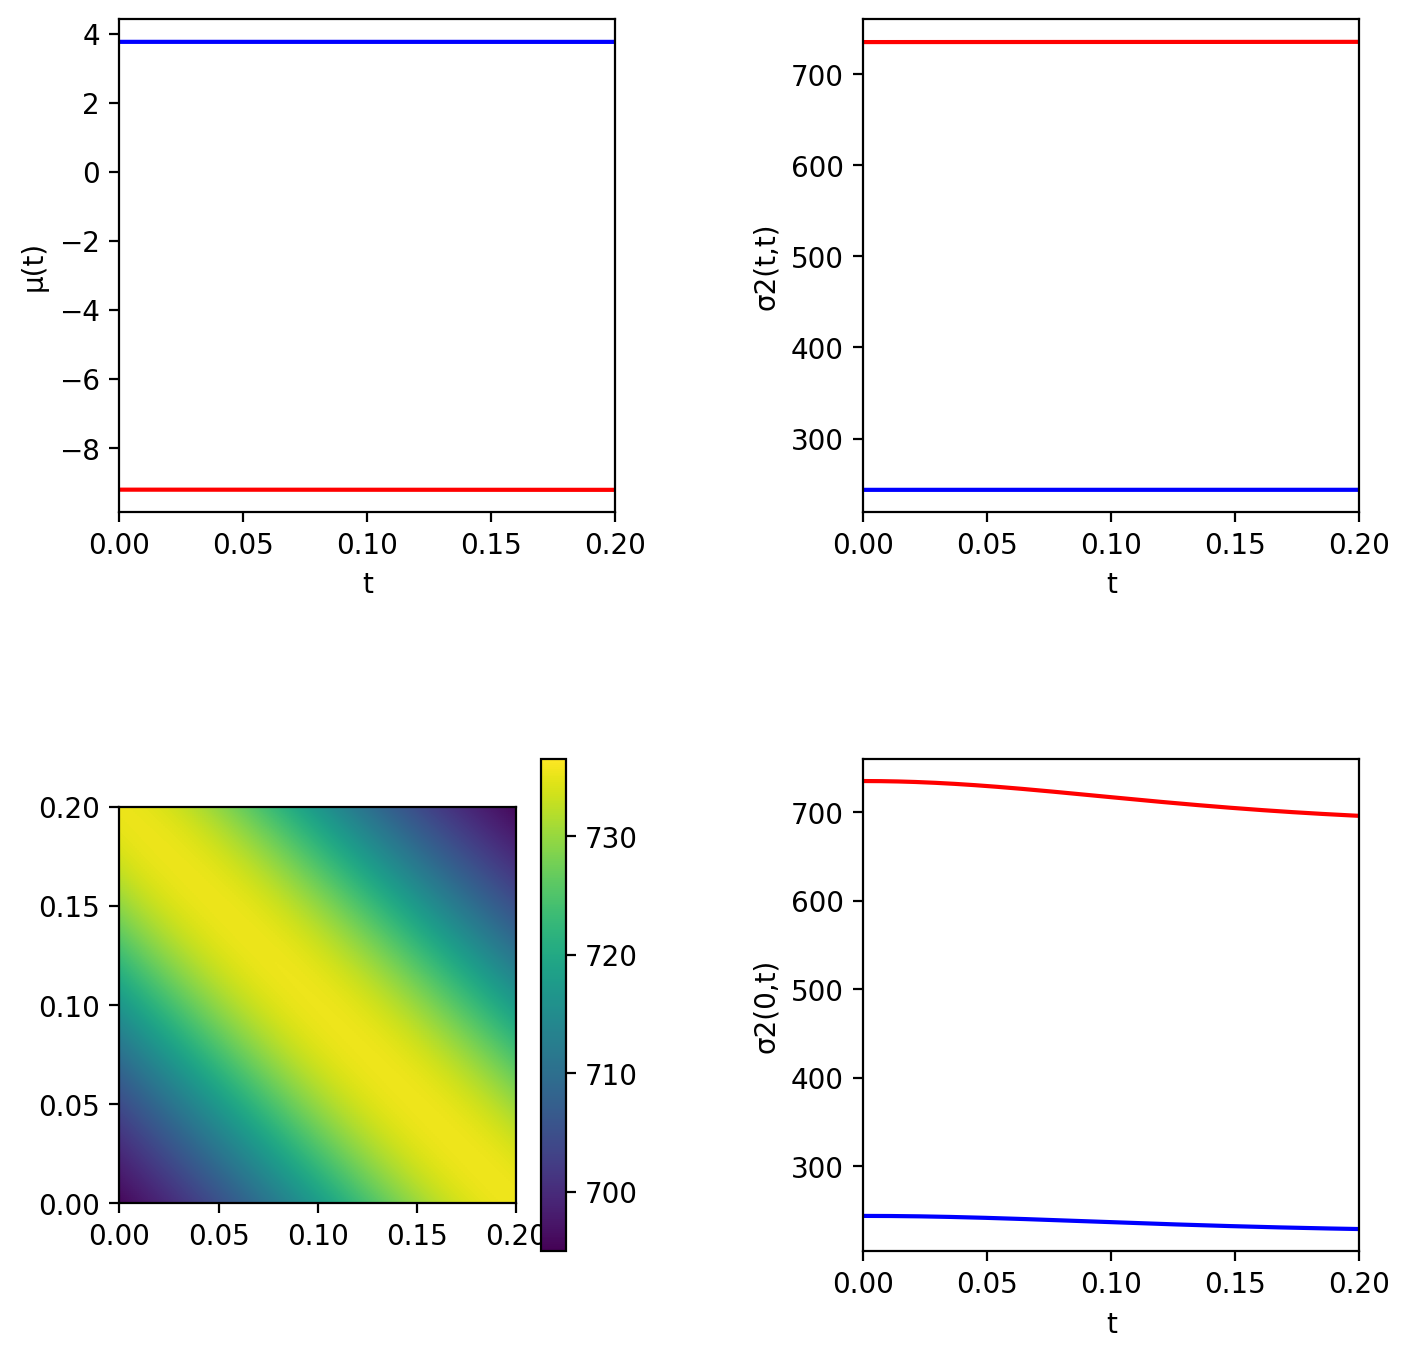

(0.0, 0.2)

In [308]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.5,wspace=0.5)

subplot(2,2,1)
plot(0.0:dt:TSave,μE,"r")
plot(0.0:dt:TSave,μI,"b")
xlabel("t")
ylabel("μ(t)")
xlim((0.0,TSave))
# ylim((minimum(μ)-1,maximum(μ)+1))

subplot(2,2,2)
plot(0.0:dt:TSave,diag(σE2),"r")
plot(0.0:dt:TSave,diag(σI2),"b")
xlabel("t")
ylabel("σ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σ2))-1,maximum(diag(σ2))+1))

subplot(2,2,3)
imshow(σE2,extent=([0.0,TSave,0.0,TSave]),vmin=minimum(σE2)-1,vmax=maximum(σE2)+1)
colorbar()

subplot(2,2,4)
plot(0.0:dt:TSave,σE2[1,:],"r")
plot(0.0:dt:TSave,σI2[1,:],"b")
xlabel("t")
ylabel("σ2(0,t)")
xlim((0.0,TSave))
# ylim((minimum(σ2[1,:])-1,
#         maximum(σ2[1,:])+1))

# subplot(2,2,4)
# plot(0.0:dt:TSave,σ2[end,end:-1:1])
# xlabel("t")
# ylabel("σ2(0,t)")
# xlim((0.0,TSave))
# ylim((minimum(σ2[end,end:-1:1])-1,
#         maximum(σ2[end,end:-1:1])+1))

In [309]:
TWrm = 1.0
TSave = 0.20
dt = 0.001

optodmft(op,np,10^-0.51/√(6),10^1.14,5dt,2dt,dt,μE[end],μI[end],
    σE2[end,end:-1:1],σI2[end,end:-1:1]) # compile
@time ΔμE,ΔμI,σΔE2,σΔI2,ρE,ρI = optodmft(op,np,10^-0.51/√(6),10^1.14,TWrm,TSave,dt,μE[end],
    μI[end],σE2[end,end:-1:1],σI2[end,end:-1:1])

165.525608 seconds (6.11 G allocations: 101.759 GiB, 7.74% gc time)


([-15.777126399731442, -15.777129577117323, -15.777132737954684, -15.777135882335305, -15.7771390103502, -15.777142122090005, -15.777145217644732, -15.777148297103809, -15.777151360556177, -15.777154408090242  …  -15.777514035542362, -15.777515236826268, -15.777516432126774, -15.777517621474562, -15.777518804900184, -15.77751998243402, -15.77752115410627, -15.777522319946975, -15.777523479986003, -15.777524634253133], [-1.0236373971184956, -1.0236378032123377, -1.023638207181409, -1.02363860903767, -1.0236390087927836, -1.023639406458541, -1.0236398020466115, -1.023640195568498, -1.0236405870357144, -1.0236409764596812  …  -1.023686864202397, -1.0236870172522878, -1.0236871695382586, -1.023687321064259, -1.0236874718341753, -1.0236876218519442, -1.023687771121407, -1.023687919646406, -1.0236880674307562, -1.0236882144783275], [570.1985638781554 570.1962855275423 … 530.1818333791731 530.0985262003568; 570.1962855275423 570.1987867875844 … 530.2723656040774 530.1846782827275; … ; 530.181

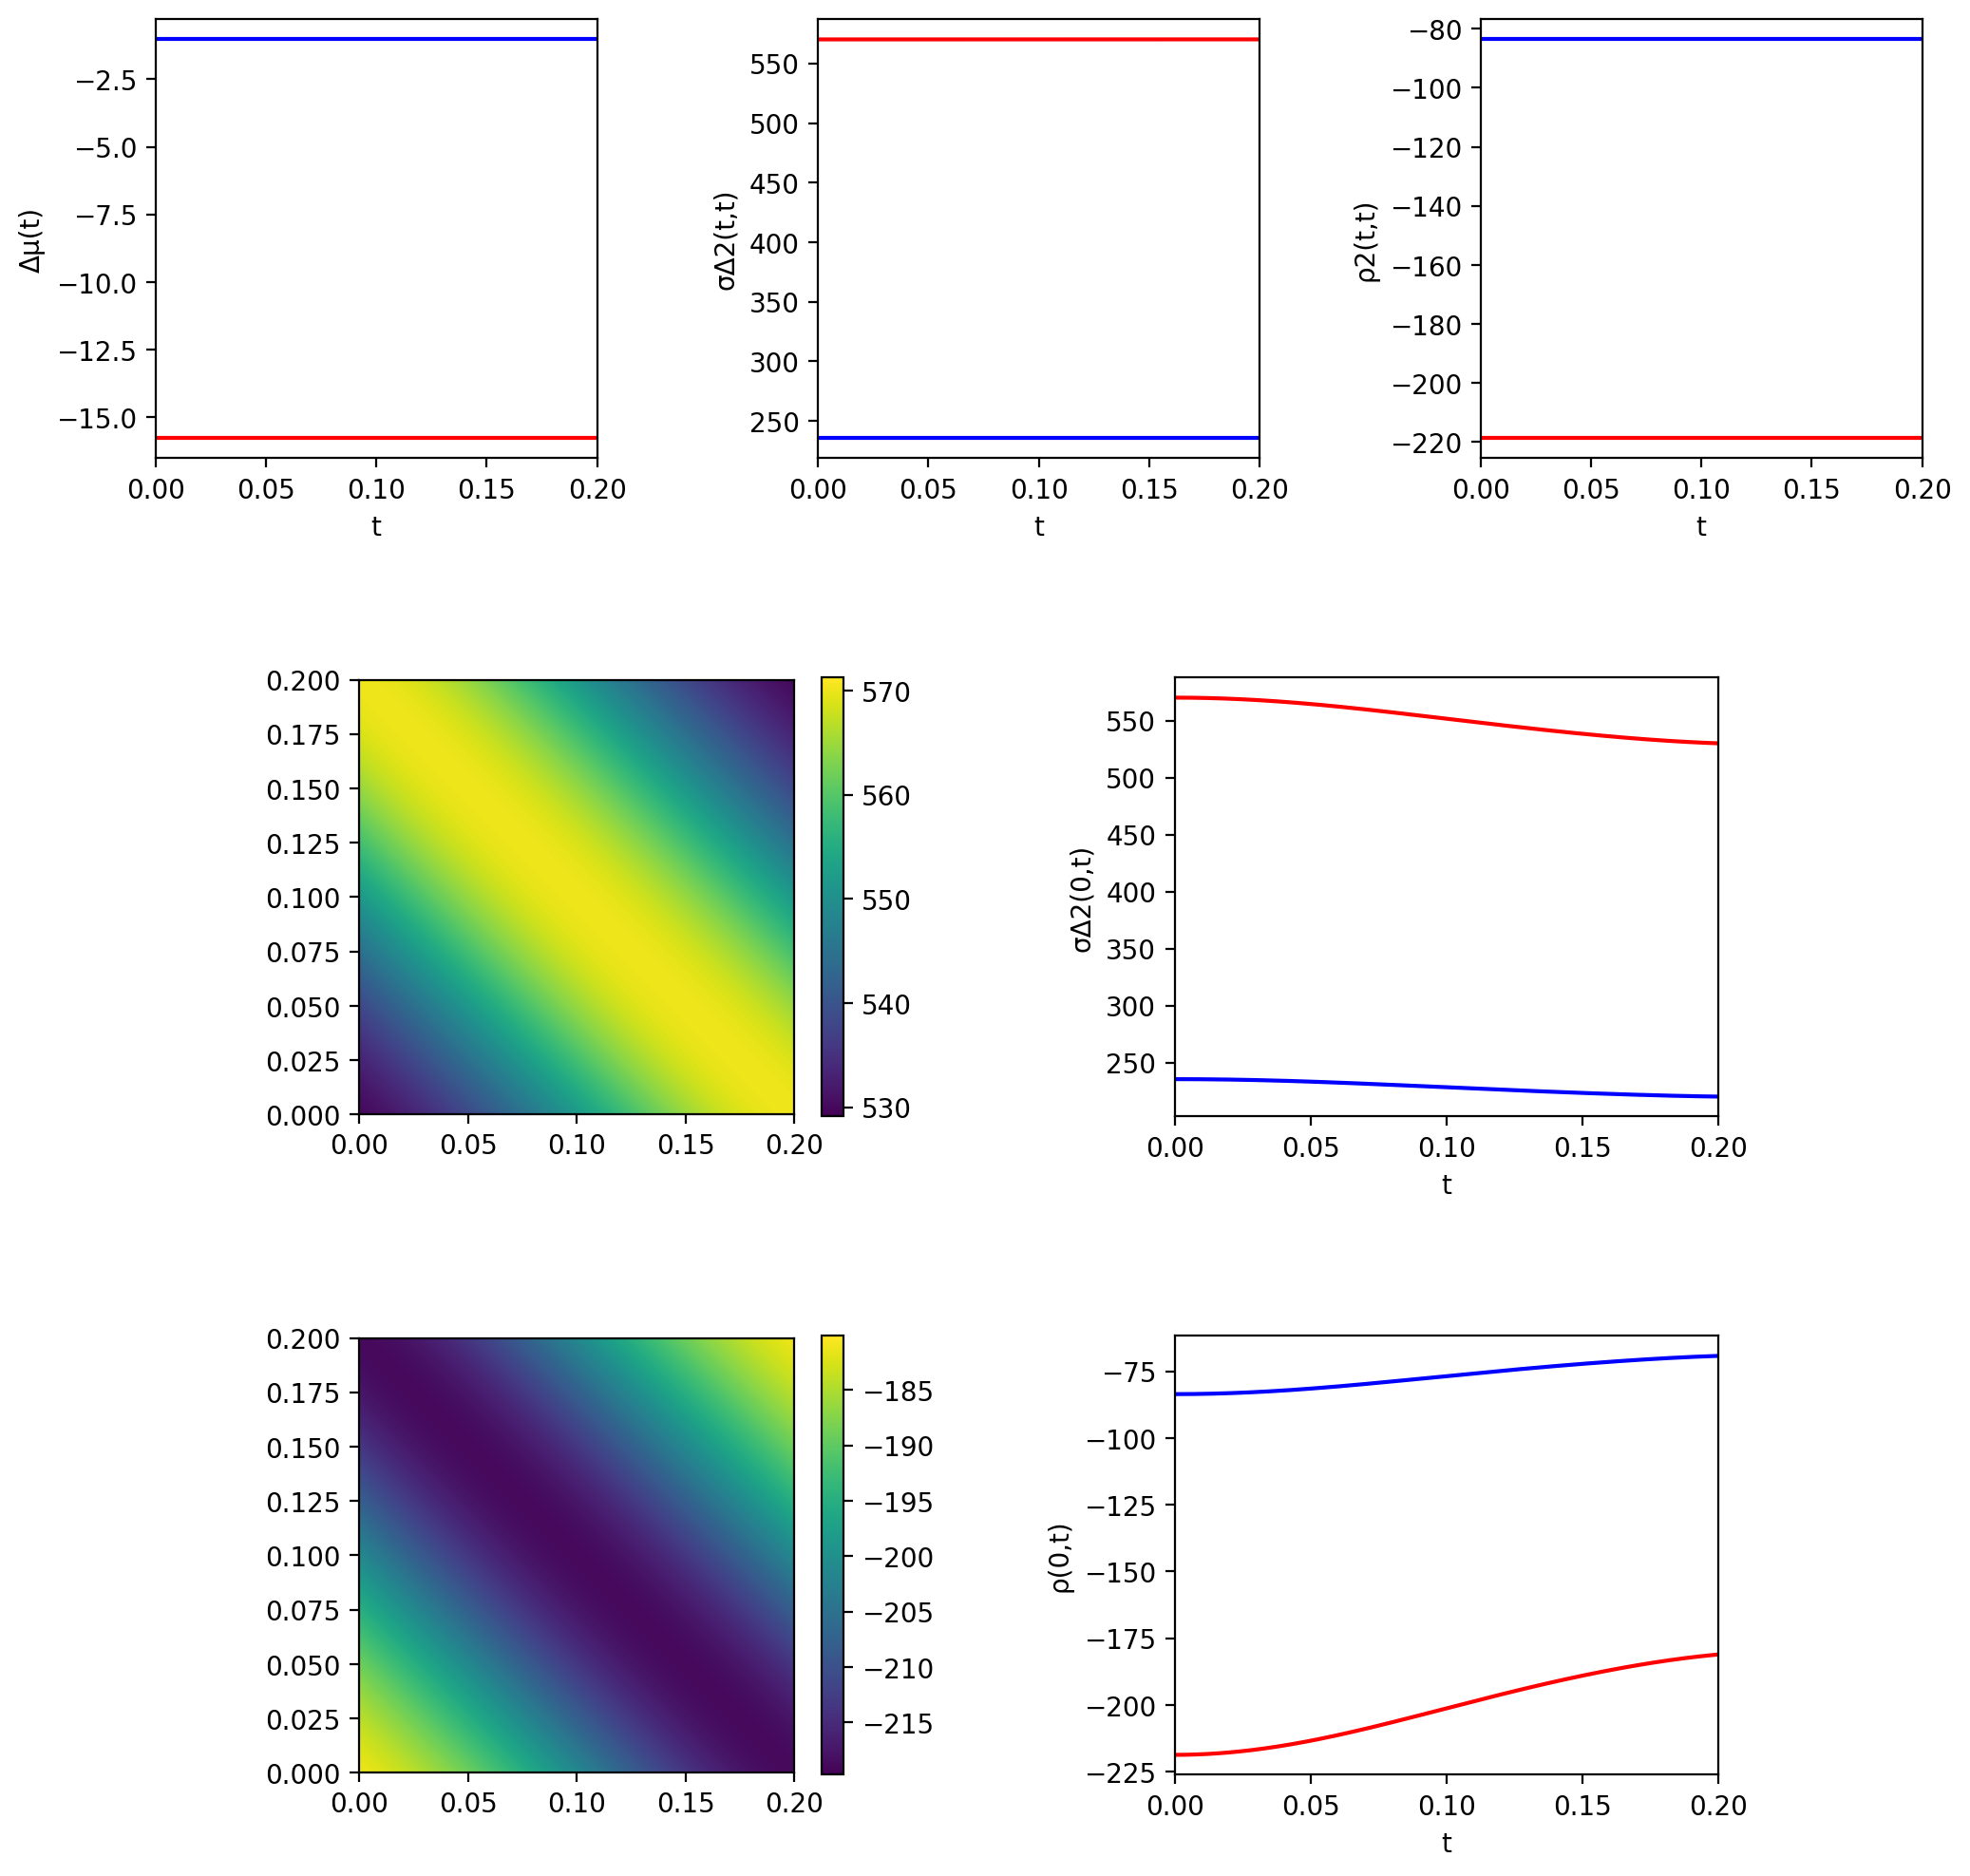

(0.0, 0.2)

In [310]:
figure(figsize=(4*3,4*3),dpi=200)
subplots_adjust(hspace=0.5,wspace=0.5)

subplot(3,3,1)
plot(0.0:dt:TSave,ΔμE,"r")
plot(0.0:dt:TSave,ΔμI,"b")
xlabel("t")
ylabel("Δμ(t)")
xlim((0.0,TSave))
# ylim((minimum(Δμ)-1,maximum(Δμ)+1))

subplot(3,3,2)
plot(0.0:dt:TSave,diag(σΔE2),"r")
plot(0.0:dt:TSave,diag(σΔI2),"b")
xlabel("t")
ylabel("σΔ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(σΔ2))-1,maximum(diag(σΔ2))+1))

subplot(3,3,3)
plot(0.0:dt:TSave,diag(ρE),"r")
plot(0.0:dt:TSave,diag(ρI),"b")
xlabel("t")
ylabel("ρ2(t,t)")
xlim((0.0,TSave))
# ylim((minimum(diag(ρ))-1,maximum(diag(ρ))+1))

subplot(3,9,(11,13))
imshow(σΔE2,extent=([0.0,TSave,0.0,TSave]),
    vmin=minimum(σΔE2)-1,vmax=maximum(σΔE2)+1)
colorbar()

subplot(3,9,(15,17))
plot(0.0:dt:TSave,σΔE2[1,:],"r")
plot(0.0:dt:TSave,σΔI2[1,:],"b")
xlabel("t")
ylabel("σΔ2(0,t)")
xlim((0.0,TSave))
# ylim((minimum(σΔ2[1,:])-1,
#         maximum(σΔ2[1,:])+1))

subplot(3,9,(20,22))
imshow(ρE,extent=([0.0,TSave,0.0,TSave]),vmin=minimum(ρE)-1,vmax=maximum(ρE)+1)
colorbar()

subplot(3,9,(24,26))
plot(0.0:dt:TSave,ρE[1,:],"r")
plot(0.0:dt:TSave,ρI[1,:],"b")
xlabel("t")
ylabel("ρ(0,t)")
xlim((0.0,TSave))
# ylim((minimum(ρ[1,:])-1,
#         maximum(ρ[1,:])+1))

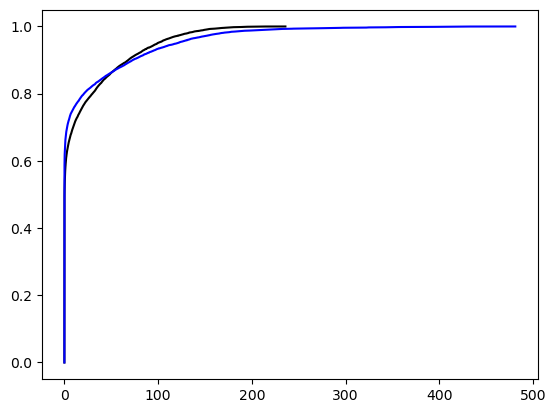

(-9.107061291944596, 3.5409838996871694, 27.3166949225181, 15.35145243706719)
(15.083661184881057, 27.68426956756596, 31.783224964635185, 41.351831867225286)
    --------------------------------    
(-15.017709406859213, 2.628436550665112, 49.53799609816586, 17.857547856880654)
(16.280012577138866, 30.70709593672913, 45.54351830951883, 47.77648389962614)


In [312]:
let n = 10000
    μEs = μE[end] .+ √(σE2[end,end])*randn(n)
    μIs = μI[end] .+ √(σI2[end,end])*randn(n÷4)
    μELs = μE[end]+ΔμE[end] .+ √(σE2[end,end]+σΔE2[end,end]+2ρE[end,end])*randn(n) +
            rand(LogNormal(op.μ,op.σ),n)
    μILs = μI[end]+ΔμI[end] .+ √(σI2[end,end]+σΔI2[end,end]+2ρI[end,end])*randn(n÷4)
    rEs = [Φ(rpE,μE) for μE in μEs]
    rIs = [Φ(rpI,μI) for μI in μIs]
    rELs = [Φ(rpE,μEL) for μEL in μELs]
    rILs = [Φ(rpI,μIL) for μIL in μILs]
    plot(sort([rEs;rIs]),[0:(1+np.γ)n-1;]/((1+np.γ)n),"k")
    plot(sort([rELs;rILs]),[0:(1+np.γ)n-1;]/((1+np.γ)n),"b")
    println((mean(μEs),mean(μIs),std(μEs),std(μIs)))
    println((mean(rEs),mean(rIs),std(rEs),std(rIs)))
    println("    --------------------------------    ")
    println((mean(μELs),mean(μILs),std(μELs),std(μILs)))
    println((mean(rELs),mean(rILs),std(rELs),std(rILs)))
end

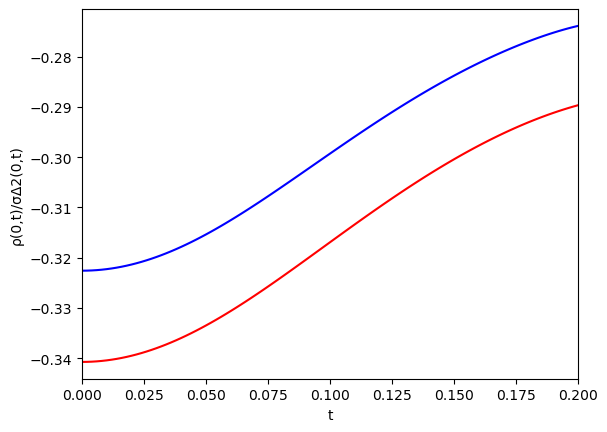

(0.0, 0.2)

In [285]:
plot(0.0:dt:TSave,ρE[1,:]./σΔE2[1,:],"r")
plot(0.0:dt:TSave,ρI[1,:]./σΔI2[1,:],"b")
xlabel("t")
ylabel("ρ(0,t)/σΔ2(0,t)")
xlim((0.0,TSave))

In [583]:
function optosim(op::OptoParams,np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,
        Twrm::AbstractFloat,Tsave::AbstractFloat,dts::AbstractFloat)
    N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    
    Eidx = 1:NE
    Iidx = NE+1:NX
    
    Crec = rand(Binomial(1,np.p),(NX,NX))
    W = zeros((NX,NX))
    W[Eidx,Eidx] .= np.W[1,1]*Crec[Eidx,Eidx]
    W[Eidx,Iidx] .= np.W[1,2]*Crec[Eidx,Iidx]
    W[Iidx,Eidx] .= np.W[2,1]*Crec[Iidx,Eidx]
    W[Iidx,Iidx] .= np.W[2,2]*Crec[Iidx,Iidx]
    W .*= J
    
    I = zeros(NX)
    I[Eidx] .= rand(Normal(J*np.K*np.W[1,3]*rX,
            √(np.K*(np.sX^2+(1-np.p)))*J*np.W[1,3]*rX),NE)
    I[Iidx] .= rand(Normal(J*np.K*np.W[2,3]*rX,
            √(np.K*(np.sX^2+(1-np.p)))*J*np.W[2,3]*rX),NI)
    
    λL = zeros(NX)
    λL[Eidx] .= rand(LogNormal(op.μ,op.σ),NE)/np.rpE.τs
    
    println((mean(λL[Eidx]),std(λL[Eidx])/mean(λL[Eidx])))
    
    Tsim = Twrm+Tsave
    τE = np.rpE.τs
    τI = np.rpI.τs
    τEinv = 1/τE
    τIinv = 1/τI
    τinv = [τEinv*ones(NE);τIinv*ones(NI)]
    tspan = (0.0,Tsim)              # define time span to simulate
    tsave = Twrm:dts:Tsim           # define times to save network state
    
#     τW = Diagonal([np.rpE.τs*ones(NE);np.rpI.τs*ones(NI)])*W
    
    beta2 = 0.045
    rtol = 1e-8
    tol = 1e-8
    gamma = 0.95
    dt = 0.017
    maxi = 10^7
    
    h0 = zeros(NX)
#     h0[Eidx] = μE[end].+√(σE2[end,end])*randn(NE)    # initialize network state
#     h0[Iidx] = μI[end].+√(σI2[end,end])*randn(NI)    # initialize network state
    r = Array{Float64}(undef,NX)     # preallocate vector of firing rates
    idxs = [1:NX;]                  # indices of neurons to measure
    function f(dh,h,nothing,t)      # function with equation of motion passed to 
                                    # DifferentialEquations
        dh .= I.-τinv.*h             # use dh vector initially to store αg-h
        for i in Eidx
            r[i] = Φ(rpE,h[i])
        end
        for i in Idx
            r[i] = Φ(rpI,h[i])
        end
#         map!(μ->Φ(rpE,μ),r[Eidx],h[Eidx])# calculate firing rates
#         map!(μ->Φ(rpI,μ),r[Iidx],h[Iidx])# calculate firing rates
        @fastmath BLAS.gemv!('N',1.0,W,r,1.0,dh)
                                    # calculate increment of local fields
                                    # in place using BLAS
    end
    prob = ODEProblem(f,h0,tspan)
                                    # initialize ODE Problem for DifferentialEquations
    sol = solve(prob,Tsit5(),reltol=rtol,abstol=tol,beta2=beta2,gamma=gamma,dt=dt,
        save_idxs=idxs,save_everystep=false,saveat=tsave,
        maxiters=maxi)              # solve ODE using Tsitouras 5/4 Runge-Kutta method
    h = reduce(hcat,sol.u)'         # extract local fields from solution
    r = Array{Float64}(undef,size(h))     # preallocate vector of firing rates
    r[:,Eidx] .= [Φ(rpE,μ) for μ in h[:,Eidx]]
    r[:,Iidx] .= [Φ(rpI,μ) for μ in h[:,Iidx]]
#     map!(μ->Φ(rpE,μ),r[:,Eidx],h[:,Eidx])# calculate firing rates
#     map!(μ->Φ(rpI,μ),r[:,Iidx],h[:,Iidx])# calculate firing rates
    
    h0 = zeros(NX)
#     h0[Eidx] = μE[end]+ΔμE[end].+√(σE2[end,end]+σΔE2[end,end]+2ρE[end,end])*randn(NE)
#     h0[Iidx] = μI[end]+ΔμI[end].+√(σI2[end,end]+σΔI2[end,end]+2ρI[end,end])*randn(NI) 
    rL = Array{Float64}(undef,NX)     # preallocate vector of firing rates
    idxs = [1:NX;]                  # indices of neurons to measure
    function fL(dhL,hL,nothing,t)      # function with equation of motion passed to 
                                    # DifferentialEquations
        dhL .= (I+λL).-τinv.*hL             # use dh vector initially to store αg-h
        for i in Eidx
            rL[i] = Φ(rpE,hL[i])
        end
        for i in Idx
            rL[i] = Φ(rpI,hL[i])
        end
#         map!(μ->Φ(rpE,μ),r[Eidx],h[Eidx])# calculate firing rates
#         map!(μ->Φ(rpI,μ),r[Iidx],h[Iidx])# calculate firing rates
        @fastmath BLAS.gemv!('N',1.0,W,rL,1.0,dhL)
                                    # calculate increment of local fields
                                    # in place using BLAS
    end
    prob = ODEProblem(fL,h0,tspan)
                                    # initialize ODE Problem for DifferentialEquations
    sol = solve(prob,Tsit5(),reltol=rtol,abstol=tol,beta2=beta2,gamma=gamma,dt=dt,
        save_idxs=idxs,save_everystep=false,saveat=tsave,
        maxiters=maxi)              # solve ODE using Tsitouras 5/4 Runge-Kutta method
    hL = reduce(hcat,solL.u)'         # extract local fields from solution
    rL = Array{Float64}(undef,size(hL))     # preallocate vector of firing rates
    rL[:,Eidx] .= [Φ(rpE,μ) for μ in hL[:,Eidx]]
    rL[:,Iidx] .= [Φ(rpI,μ) for μ in hL[:,Iidx]]
#     map!(μ->Φ(rpE,μ),r[:,Eidx],h[:,Eidx])# calculate firing rates
#     map!(μ->Φ(rpI,μ),r[:,Iidx],h[:,Iidx])# calculate firing rates
    return (I,W,h,r,hL,rL)
end

optosim (generic function with 1 method)

In [47]:
function xcorr(x,y,meansub=false,norm=false,pad=false)
    L = length(x)
    a = zeros(Complex{Float64},(pad ? 2 : 1)*L)
    b = zeros(Complex{Float64},(pad ? 2 : 1)*L)
    a[1:L] = fft(x)
    b[1:L] = fft(y)
    if meansub
        a[1] = 0.0 + 0.0im
        b[1] = 0.0 + 0.0im
    end
    c = ifft(conj(a).*b)
    if norm
        c ./= √(dot(a,a)*dot(b,b))/L
    end
    if pad
        c = c[1:2:end]
        for i in eachindex(c)
            l = min(i-1,L-i)
            c[i] *= L/(L-2l)
        end
    end
    return real.(c)
end

function acorr(hs,lags)
    out = zeros(length(lags))
#     hs .-= mean(hs,dims=2)
    hs .-= mean(hs)
    for i in eachindex(lags)
        if lags[i] >= 0
            a = @view hs[1:end-lags[i],:]
            b = @view hs[1+lags[i]:end,:]
        else
            a = @view hs[1-lags[i]:end,:]
            b = @view hs[1:end+lags[i],:]
        end
#         out[i] = dot(a,b) * size(hs,1) / (size(hs,1) - abs(lags[i]))
        out[i] = dot(a,b)/sqrt(dot(a,a)*dot(b,b))
    end
    return out
end

function pcorr(x,y)
    return dot(x,y) / √(dot(x,x) * dot(y,y))
end

pcorr (generic function with 1 method)

In [286]:
optosim(op,np,10^-0.51/√(2),10^1.14,5dt,2dt,dt) # compile
@time I,W,h,r,hL,rL = optosim(op,np,10^-0.51/√(2),10^1.14,2TWrm,TSave,dt)

(526.5603627417028, 3.132285514335645)
(529.520387988155, 3.5430805416151836)


LoadError: InterruptException:

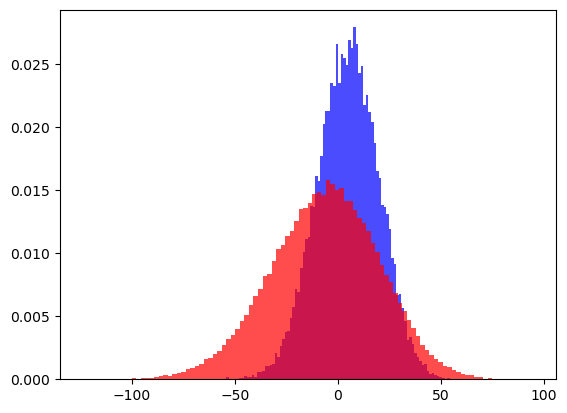

In [275]:
let N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    hE = [hs[Eidx];hs[NX.+Eidx];hs[2NX.+Eidx];hs[3NX.+Eidx];hs[4NX.+Eidx];
        hs[5NX.+Eidx];hs[6NX.+Eidx];hs[7NX.+Eidx];hs[8NX.+Eidx];hs[9NX.+Eidx];
        hs[10NX.+Eidx];hs[11NX.+Eidx];hs[12NX.+Eidx];hs[13NX.+Eidx];hs[14NX.+Eidx];
        hs[15NX.+Eidx]]
    hI = [hs[Iidx];hs[NX.+Iidx];hs[2NX.+Iidx];hs[3NX.+Iidx];hs[4NX.+Iidx];
        hs[5NX.+Iidx];hs[6NX.+Iidx];hs[7NX.+Iidx];hs[8NX.+Iidx];hs[9NX.+Iidx];
        hs[10NX.+Iidx];hs[11NX.+Iidx];hs[12NX.+Iidx];hs[13NX.+Iidx];hs[14NX.+Iidx];
        hs[15NX.+Iidx]]
    hist(hI,100,density=true,color="b",alpha=0.7)
    hist(hE,100,density=true,color="r",alpha=0.7)
    show()
end

In [276]:
let N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    hE = [hs[Eidx];hs[NX.+Eidx];hs[2NX.+Eidx];hs[3NX.+Eidx];hs[4NX.+Eidx];
        hs[5NX.+Eidx];hs[6NX.+Eidx];hs[7NX.+Eidx];hs[8NX.+Eidx];hs[9NX.+Eidx];
        hs[10NX.+Eidx];hs[11NX.+Eidx];hs[12NX.+Eidx];hs[13NX.+Eidx];hs[14NX.+Eidx];
        hs[15NX.+Eidx]]
    hI = [hs[Iidx];hs[NX.+Iidx];hs[2NX.+Iidx];hs[3NX.+Iidx];hs[4NX.+Iidx];
        hs[5NX.+Iidx];hs[6NX.+Iidx];hs[7NX.+Iidx];hs[8NX.+Iidx];hs[9NX.+Iidx];
        hs[10NX.+Iidx];hs[11NX.+Iidx];hs[12NX.+Iidx];hs[13NX.+Iidx];hs[14NX.+Iidx];
        hs[15NX.+Iidx]]
    display(OneSampleADTest(hE,Normal(mean(hE),√(var(hE)))))
    display(OneSampleADTest(hI,Normal(mean(hI),√(var(hI)))))
end

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-08

Details:
    number of observations:   80000
    sample mean:              -6.311801503115345
    sample SD:                26.161382298744716
    A² statistic:             20.250084827408372


One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.1176

Details:
    number of observations:   20000
    sample mean:              4.770230580697041
    sample SD:                14.914098258394224
    A² statistic:             1.8068230882560736


In [287]:
let N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    hEs = h[end,Eidx]
    hIs = h[end,Iidx]
    hELs = hL[end,Eidx]
    hILs = hL[end,Iidx]
    rEs = r[end,Eidx]
    rIs = r[end,Iidx]
    rELs = rL[end,Eidx]
    rILs = rL[end,Iidx]
    plot(sort([rEs;rIs]),[0:NX-1;]/NX,"k")
    plot(sort([rELs;rILs]),[0:NX-1;]/NX,"b")
    println((mean(hEs),mean(hIs),std(hEs),std(hIs)))
    println((mean(rEs),mean(rIs),std(rEs),std(rIs)))
    println("    --------------------------------    ")
    println((mean(hELs),mean(hILs),std(hELs),std(hILs)))
    println((mean(rELs),mean(rILs),std(rELs),std(rILs)))
end

LoadError: BoundsError: attempt to access 101×6250 Matrix{Float64} at index [101, 1:10000]

In [288]:
let ts = [0.0:dt:TSave;]
    N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    plot(ts,σE2[end,end:-1:1],"k")
    plot(ts,acorr(h[:,Eidx],[0:round(Int,TSave/dt);])*var(h[:,Eidx]),"r--")
    plot(ts,σI2[end,end:-1:1],"k")
    plot(ts,acorr(h[:,Iidx],[0:round(Int,TSave/dt);])*var(h[:,Iidx]),"b--")
    
#     plot(ts,σE2[end,end:-1:1]+σΔE2[end,end:-1:1]+2ρE[end,end:-1:1],"k")
#     plot(ts,acorr(hL[:,Eidx],[0:round(Int,TSave/dt);])*var(hL[:,Eidx]),"r:")
#     plot(ts,σI2[end,end:-1:1]+σΔI2[end,end:-1:1]+2ρI[end,end:-1:1],"k")
#     plot(ts,acorr(hL[:,Iidx],[0:round(Int,TSave/dt);])*var(hL[:,Iidx]),"b:")
    
    println((μE[end],mean(h[:,Eidx])))
    println((μI[end],mean(h[:,Iidx])))
    
#     println((μE[end]+ΔμE[end],mean(hL[:,Eidx])))
#     println((μI[end]+ΔμI[end],mean(hL[:,Iidx])))
end

LoadError: BoundsError: attempt to access 101×6250 adjoint(::Matrix{Float64}) with eltype Float64 at index [1:101, 1:10000]

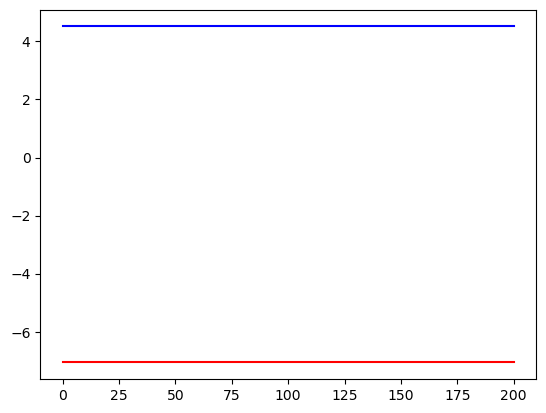

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac64372100>

In [370]:
let N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    plot(mean(h[:,Eidx],dims=2),"r")
    plot(mean(h[:,Iidx],dims=2),"b")
end

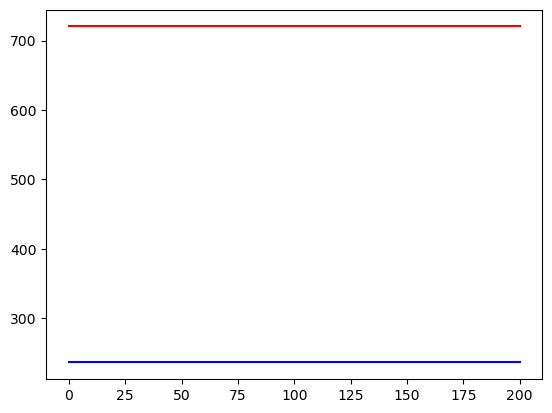

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac644a0cd0>

In [371]:
let N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    plot(var(h[:,Eidx],dims=2),"r")
    plot(var(h[:,Iidx],dims=2),"b")
end

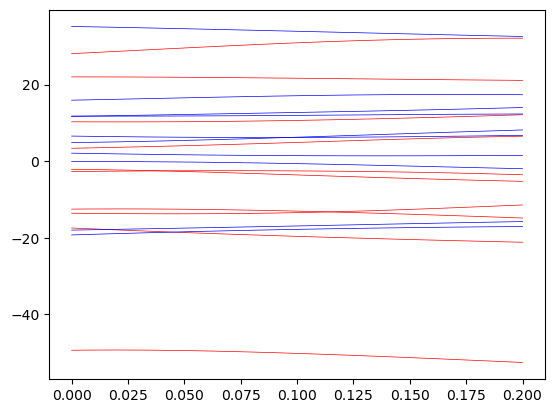

In [51]:
let ts = [0.0:dt:TSave;]
    N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    for i in 1:10
        plot(ts,h[:,i],"r",lw=0.5)
    end
    for i in 1:10
        plot(ts,h[:,NE+i],"b",lw=0.5)
    end
end

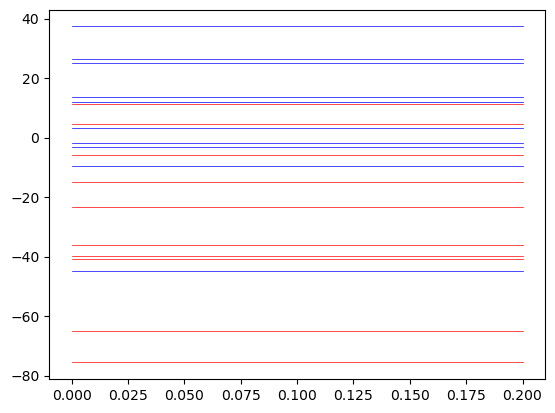

In [52]:
let ts = [0.0:dt:TSave;]
    N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    Eidx = 1:NE
    Iidx = NE+1:NX
    for i in 1:10
        plot(ts,hL[:,i],"r",lw=0.5)
    end
    for i in 1:10
        plot(ts,hL[:,NE+i],"b",lw=0.5)
    end
end

In [296]:
let N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    println((NE,NI))
    
    Eidx = 1:NE
    Iidx = NE+1:NX
    
    expand = 10
    ExpEidx = 1:expand*NE
    ExpIidx = expand*NE+1:expand*NX
    
    J = 1.0
    rX = 1.0
    
    Crec = rand(Binomial(1,np.p),(expand*NX,NX))
    W = zeros((expand*NX,NX))
    W[ExpEidx,Eidx] .= np.W[1,1]*Crec[ExpEidx,Eidx]
    W[ExpEidx,Iidx] .= np.W[1,2]*Crec[ExpEidx,Iidx]
    W[ExpIidx,Eidx] .= np.W[2,1]*Crec[ExpIidx,Eidx]
    W[ExpIidx,Iidx] .= np.W[2,2]*Crec[ExpIidx,Iidx]
    W .*= J
    
    I = zeros(expand*NX)
    I[ExpEidx] .= rand(Normal(J*np.K*np.W[1,3]*rX,
            √(np.K*(np.sX^2+(1-np.p)))*J*np.W[1,3]*rX),expand*NE)
    I[ExpIidx] .= rand(Normal(J*np.K*np.W[2,3]*rX,
            √(np.K*(np.sX^2+(1-np.p)))*J*np.W[2,3]*rX),expand*NI)
    
    display([mean(sum(W[ExpEidx,Eidx],dims=2)) mean(sum(W[ExpEidx,Iidx],dims=2)) mean(I[ExpEidx])/rX;
            mean(sum(W[ExpIidx,Eidx],dims=2)) mean(sum(W[Iidx,Iidx],dims=2)) mean(I[ExpIidx])/rX])
    display(J*np.K*np.W.*[1 np.γ 1;
                     1 np.γ 1])
    
    display([var(sum(W[ExpEidx,Eidx],dims=2)) var(sum(W[ExpEidx,Iidx],dims=2)) var(I[ExpEidx])/rX;
            var(sum(W[ExpIidx,Eidx],dims=2)) var(sum(W[ExpIidx,Iidx],dims=2)) var(I[ExpIidx])/rX])
    display(J^2*np.K*(1-np.p)*np.W.^2 .*[1 np.γ (np.sX^2+(1-np.p))/(1-np.p);
                     1 np.γ (np.sX^2+(1-np.p))/(1-np.p)])
end

2×3 Matrix{Float64}:
  499.974  -936.177  1372.03
 1618.29   -935.681   315.329

2×3 Matrix{Float64}:
  500.0   -936.25   1372.5
 1617.97  -966.736   315.504

2×3 Matrix{Float64}:
  452.019  6363.92  3596.72
 4738.67   6774.23   185.705

2×3 Matrix{Float64}:
  450.0   6311.26  3541.46
 4712.08  6728.97   187.14

(5000, 1250)


In [222]:
let N = round(Int,np.K/np.p)
    NE = N
    NI = round(Int,N*np.γ)
    NX = NE + NI
    println((NE,NI))
    
    Eidx = 1:NE
    Iidx = NE+1:NX
    
    J = 1.0
    rX = 1.0
    
    Crec = rand(Binomial(1,np.p),(NX,NX))
    W = zeros((NX,NX))
    W[Eidx,Eidx] .= np.W[1,1]*Crec[Eidx,Eidx]
    W[Eidx,Iidx] .= np.W[1,2]*Crec[Eidx,Iidx]
    W[Iidx,Eidx] .= np.W[2,1]*Crec[Iidx,Eidx]
    W[Iidx,Iidx] .= np.W[2,2]*Crec[Iidx,Iidx]
    W .*= J
    
    display(mean(Crec))
    display(var(Crec))
end

0.1000023552

0.09000188645850134

(5000, 1250)
